# Person Data Analysis

This notebook contains the analysis of initial person authority data from 4 different Belgian Federal Scientific Institutes:

* Royal Library of Belgium
* Royal Institute for Cultural Heritage
* Royal Museums of Art and History
* Royal Museums of Fine Arts

Data dumps from each instiution were received or downloaded in different XML formats. In the following we will count how often MetaBelgica-relevant data fields are filled in, which will also entail standardization and uniformization of date and location values. This will not only allow us a comprehensive view across the data sources, but also ease future tasks of integrating the data by identifying the overlap of person authorities.

Several CSV files are generated by this notebook. Those files either contain data that needs to be checked and curated manually or contain standardized values that can be used to enrich the respective data source. For example, thousands of previously undstandardized dates from MARC field `100$d` at KBR are standardized and can be used to enrich the records' MARC field `046`.

In [1]:
# setting to autoreload Python files if they have changed
%load_ext autoreload
%autoreload 2

# used software libraries for data management
import pandas as pd
import json
import ast
import os
import numpy as np

# used software libraries for visualization
from venn import venn
import matplotlib.pyplot as plt
import seaborn as sns

# used own software libraries
import notebook_utils
import utils
from xml_to_csv.xml_to_csv import main as xml_to_csv
import xml_to_csv.utils as xml_to_csv_utils
from geoname_enrichment.geoname_enrichment import main as enrich_with_geoname
from split_place_country import main as split_place_country

## Data extraction

We first extract the data and count how often some specific fields are filled in. Below you can see a general configuration that defines relevant file names.
There currently seems to be a bug when calling the streaming-based extraction script from within the notebook (only executed when `extractAgain = True`). Hence we recommend to call the extraction scripts from the command line beforehand and keep `extractAgain` to `False`.

At the end of this section the data of the MetaBelgica partners are available in different Pandas dataframes.

In [2]:
# ##################################################################################################
# SCRIPT CONFIGURATION

extractAgain = False
enrichGeoAgain = False # this entails calling an API for each and every record and hence can take a while
useEnriched100d = True # use extracted standardized KBR 100$d dates for dates statistics
statsDataframes = []

# config file that specifies many regular expression patterns for the extraction of diverse date values
dateMappingConfigFile = 'date-mapping.json'

# ##################################################################################################
# OUTPUT FILES
outputDir = 'stats'

# duplicate authority identifiers in data sources (usually empty)
duplicateAutIDofMainDf = os.path.join(outputDir, 'duplicate-autID-main-dataframe.csv')

# duplicate authority identifiers when merging main df with enriched 1:n files 
duplicateAutIDofMainDfCategories = os.path.join(outputDir, 'duplicate-autID-enriched.csv')

# duplicate authority identifiers after merging main df with 1:n file '100d-dates'
kbrDuplicate100dDateValues = os.path.join(outputDir, 'duplicate-values-kbr-100d.csv')

duplicateBirthDates = os.path.join(outputDir, 'duplicate-birth-dates.csv')
duplicateDeathDates = os.path.join(outputDir, 'duplicate-death-dates.csv')

# Dates in this file needs to be checked and splitted manually
kbr100dDateSplitProblem = os.path.join(outputDir, 'kbr-100d-split-problem.csv')

# Dates in these files can be used to enrich 046$f (birth) and 046$g (death) dates automatically
kbr100dDateCertainBirthDates = os.path.join(outputDir, 'kbr-birthDates-certain.csv')
kbr100dDateCertainDeathDates = os.path.join(outputDir, 'kbr-deathDates-certain.csv')

# Dates in these files still need to be curated manually
kbr100dDateCertainBirthDatesNotParsed = os.path.join(outputDir, 'kbr-birthDates-certain-not-parsed.csv')
kbr100dDateCertainDeathDatesNotParsed = os.path.join(outputDir, 'kbr-deathDates-certain-not-parsed.csv')

# Dates in these files can be used to indicate an uncertain birth/death date in 046$f/046$g
kbr100dDateUncertainBirthDates = os.path.join(outputDir, 'kbr-birthDates-uncertain.csv')
kbr100dDateUncertainDeathDates = os.path.join(outputDir, 'kbr-deathDates-uncertain.csv')

# Dates in these files still need to be curated manually
kbr100dDateUncertainBirthDatesNotParsed = os.path.join(outputDir, 'kbr-birthDates-uncertain-not-parsed.csv')
kbr100dDateUncertainDeathDatesNotParsed = os.path.join(outputDir, 'kbr-deathDates-uncertain-not-parsed.csv')

# Dates in these files can be used to enrich 046$s and 046$t (structured flourish start and flourish end)
kbr100dDateFormattedFlourishStart = os.path.join(outputDir, 'kbr-flourish-date-start.csv')
kbr100dDateFormattedFlourishEnd = os.path.join(outputDir, 'kbr-flourish-date-end.csv')

# Dates in these files still need to be curated manually
kbr100dDateFormattedFlourishStartNotParsed = os.path.join(outputDir, 'kbr-flourish-date-start-not-parsed.csv')
kbr100dDateFormattedFlourishEndNotParsed = os.path.join(outputDir, 'kbr-flourish-date-end-not-parsed.csv')

In [3]:
# this dictionary contains relevant filenames and variables to build subsequent result files per data source
extractInfo = {
              "KIK-IRPA": {"inputFilename":"kik-irpa/KIK-IRPA_the_PEOPLE.xml", 
                           "outputFilename": "kik-irpa/kik-irpa-data.csv", 
                           "configFilename": "extract-config-kik-irpa.json",
                           "dateConfigFilename": dateMappingConfigFile,
                           "prefix":"kik-irpa-data",
                           "geo-enriched-birth-place": "kik-irpa/kik-irpa-data-birthPlace-enriched.csv",
                           "geo-enriched-death-place": "kik-irpa/kik-irpa-data-deathPlace-enriched.csv"
                          },
            "KBR": {"inputFilename":"kbr/2024-05-17_apep-enriched.xml", 
                       "outputFilename": "kbr/kbr-data.csv", 
                       "100dDatesFilename": "kbr/kbr-data-dates100d.csv",
                       "configFilename": "extract-config-kbr.json", 
                       "dateConfigFilename": dateMappingConfigFile,
                       "prefix":"kbr-data",
                       "geo-enriched-birth-place": "kbr/kbr-data-birthPlace-enriched.csv",
                       "geo-enriched-death-place": "kbr/kbr-data-deathPlace-enriched.csv"
                   },
              "KMSKB": {"inputFilename":"kmskb/2023-11-10-RMFAB-FabritiusCreators.xml", 
                        "outputFilename": "kmskb/kmskb-data.csv", 
                        "configFilename": "extract-config-kmskb.json", 
                        "dateConfigFilename": dateMappingConfigFile,
                        "prefix":"kmskb-data",
                        "geo-enriched-birth-place": "kmskb/kmskb-data-birthPlace-enriched.csv",
                        "geo-enriched-death-place": "kmskb/kmskb-data-deathPlace-enriched.csv"
                       },
              "KMKG": {"inputFilename":"kmkg/Authors_KMKG-MRAH.xml", 
                       "outputFilename": "kmkg/kmkg-data.csv", 
                       "configFilename": "extract-config-kmkg.json",
                       "dateConfigFilename": dateMappingConfigFile,
                       "prefix":"kmkg-data",
                       "geo-enriched-birth-place": "kmkg/kmkg-data-birthPlace-enriched.csv",
                       "geo-enriched-death-place": "kmkg/kmkg-data-deathPlace-enriched.csv"
                      }
              }

In [4]:
# extract CSV data from the specified XML files
# (as mentioned above, due to a bug when calling from the Jupyter notebook 
# ideally call the xml_to_csv script on the commandline)
#
if extractAgain:
    for dataSource, info in extractInfo.items():

        logFileName = os.path.join(os.path.dirname(info['outputFilename']), f'{info["prefix"]}.log')
        print(f'Extracting data from {dataSource} (logging to {logFileName})')
        xml_to_csv([info['inputFilename']], info['outputFilename'], info['configFilename'], info['dateConfigFilename'], info['prefix'], False, logFile=logFileName)


The following piece of code reads data from the extraction step into different dataframes. The extraction phase created one main CSV file per data source as well as different CSV files per column, e.g. `kbr-data.csv` as well as `kbr-birthDate.csv` or `kbr-deathDate.csv`.

All main CSV files will be available in the variable `df` and content of specific data sources can be filtered via the column `dataSource`. For example `df[df['dataSource'] == 'KBR']`.

Similarly all column-specific CSV files will be loaded into single dataframes. To have these dataframes available at one place, they will be added to the dictionary `valueDataframes`. Thus all `1:n` birth date values can be accessed in a dataframe stored in `valueDataframes['birthDate']`. Retrieving all birth date values from KBR is then possible by calling `valueDataframes['birthDate'][valueDataframes['birthDate']['dataSource'] == 'KBR']`.

Or simplified for readability `birthDateDf = valueDataframes['birthDate']` and then afterwards `birthDateDf[birthDateDf['dataSource'] == 'KBR']`.

In [5]:
# load CSV data into Pandas dataframes
#

# a list of dataframes per data source that later will be used to create a single merged dataframe
dataframes = []

# a dictionary of dataframes of specific columns
# merged versions will be available via the variable valueDataframes
# For example valueDataframes['birthDate'] will be a single dataframe 
# with all birthDate values of the different data sources that can be filtered on the column 'dataSource'
allValueDataframes = {'birthDate': [], 'deathDate': [], 'birthPlace': [], 'deathPlace': []}
valueDataframes = allValueDataframes.copy()

for dataSource, info in extractInfo.items():
    
    # read main dataframe
    currentDf = pd.read_csv(info['outputFilename'], 
                            converters={"name": utils.jsonParser, 
                                        "isni": utils.jsonParser, 
                                        "birthDate": utils.jsonParser, 
                                        "deathDate": utils.jsonParser, 
                                        "alternateNames": utils.jsonParser,
                                        "nameComponents": utils.jsonParser,
                                        "pseudonyms": utils.jsonParser, 
                                        "viaf": utils.jsonParser, 
                                        "bnf": utils.jsonParser, 
                                        "birthPlace": utils.jsonParser, 
                                        "deathPlace": utils.jsonParser}, 
                            keep_default_na=False)
    
    # explicitly indicate the data source in a separate column
    currentDf['dataSource'] = dataSource
    
    dataframes.append(currentDf)
    
    # read dataframes per value
    for col, colList in allValueDataframes.items():
        colFile = info['outputFilename'].replace('.csv', f'-{col}.csv')
        print(f'processing {colFile}')
        currentColDf = pd.read_csv(colFile, keep_default_na=False)
        # explicitly indicate the data source in a separate column
        currentColDf['dataSource'] = dataSource
        currentColDf = currentColDf.drop_duplicates()
        currentColDf = currentColDf.set_index('autID')
        colList.append(currentColDf)
        
for col, colList in allValueDataframes.items():
    valueDataframes[col] = pd.concat(colList)
    
df = pd.concat(dataframes)
df = df.set_index('autID')

processing kik-irpa/kik-irpa-data-birthDate.csv
processing kik-irpa/kik-irpa-data-deathDate.csv
processing kik-irpa/kik-irpa-data-birthPlace.csv
processing kik-irpa/kik-irpa-data-deathPlace.csv


/tmp/ipykernel_19332/1460940519.py:17: DtypeWarning: Columns (3,6,8,10,12,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  currentDf = pd.read_csv(info['outputFilename'],


processing kbr/kbr-data-birthDate.csv
processing kbr/kbr-data-deathDate.csv
processing kbr/kbr-data-birthPlace.csv
processing kbr/kbr-data-deathPlace.csv
processing kmskb/kmskb-data-birthDate.csv
processing kmskb/kmskb-data-deathDate.csv
processing kmskb/kmskb-data-birthPlace.csv
processing kmskb/kmskb-data-deathPlace.csv
processing kmkg/kmkg-data-birthDate.csv
processing kmkg/kmkg-data-deathDate.csv
processing kmkg/kmkg-data-birthPlace.csv
processing kmkg/kmkg-data-deathPlace.csv


In [6]:
df[df.index =='kmskb|509/2126']

isni                                               name  \
autID                                                                    
kmskb|509/2126  NaN  [MEESTER VAN FLÃMALLE / MAÃTRE DE FLÃMALLE,...   

               alternateNames birthDate-original  \
autID                                              
kmskb|509/2126            NaN                      

                                                        birthDate  \
autID                                                               
kmskb|509/2126  [{'birthDate': '1375~', 'rule': 'circa_year', ...   

               deathDate-original  \
autID                               
kmskb|509/2126                      

                                                        deathDate  \
autID                                                               
kmskb|509/2126  [{'deathDate': '1444', 'rule': 'simplePattern'...   

               birthPlace-original birthPlace deathPlace-original deathPlace  \
autID                                                                          
kmskb|509/2126                 NaN        NaN                 NaN        NaN   

               dataSource pseudonyms dates100d viaf nameComponents  bnf  \
autID                                                                     
kmskb|509/2126      KMSKB        NaN       NaN  NaN            NaN  NaN   

               gender nationality  
autID                              
kmskb|509/2126    NaN         NaN

In [7]:
valueDataframes['birthDate'][valueDataframes['birthDate'].index == 'kmskb|509/2126']

birthDate birthDate-original        rule dataSource
autID                                                             
kmskb|509/2126     1375~           ca. 1375  circa_year      KMSKB

In [8]:
df[df.index == 'kmskb|509/2557']

isni name alternateNames birthDate-original  \
autID                                                        
kmskb|509/2557  NaN  NaN            NaN                      

                                                        birthDate  \
autID                                                               
kmskb|509/2557  [{'birthDate': '1821', 'rule': 'simplePattern'...   

               deathDate-original  \
autID                               
kmskb|509/2557                      

                                                        deathDate  \
autID                                                               
kmskb|509/2557  [{'deathDate': '1884', 'rule': 'simplePattern'...   

               birthPlace-original birthPlace deathPlace-original deathPlace  \
autID                                                                          
kmskb|509/2557                 NaN        NaN                 NaN        NaN   

               dataSource pseudonyms dates100d viaf  \
autID                                                 
kmskb|509/2557      KMSKB        NaN       NaN  NaN   

                                                   nameComponents  bnf gender  \
autID                                                                           
kmskb|509/2557  [{'lastName': 'van Imschoot;van Imschoot;van I...  NaN    NaN   

               nationality  
autID                       
kmskb|509/2557         NaN

In [9]:
# preview of the main dataframe containing data from the main CSV files per data source
df

isni              name alternateNames  \
autID                                                              
kik-irpa|3                  NaN      [Flammarion]            NaN   
kik-irpa|19                 NaN    [Loze, Pierre]            NaN   
kik-irpa|22                 NaN          [Lannoo]            NaN   
kik-irpa|33                 NaN          [[s.n.]]         [s.n.]   
kik-irpa|42                 NaN          [Masson]            NaN   
...                         ...               ...            ...   
kmkg|5750    [0000000114445455]  [Zoritchak, Yan]            NaN   
kmkg|4830                   NaN      [Zuccarelli]            NaN   
kmkg|2315                   NaN           [Zumpe]            NaN   
kmkg|407442                 NaN               NaN            NaN   
kmkg|564442                 NaN               NaN            NaN   

            birthDate-original birthDate deathDate-original deathDate  \
autID                                                                   
kik-irpa|3                           NaN                          NaN   
kik-irpa|19                          NaN                          NaN   
kik-irpa|22                          NaN                          NaN   
kik-irpa|33                          NaN                          NaN   
kik-irpa|42                          NaN                          NaN   
...                        ...       ...                ...       ...   
kmkg|5750                            NaN                          NaN   
kmkg|4830                            NaN                          NaN   
kmkg|2315                            NaN                          NaN   
kmkg|407442                          NaN                          NaN   
kmkg|564442                          NaN                          NaN   

            birthPlace-original  \
autID                             
kik-irpa|3                        
kik-irpa|19                       
kik-irpa|22                       
kik-irpa|33                       
kik-irpa|42                       
...                         ...   
kmkg|5750                   NaN   
kmkg|4830                   NaN   
kmkg|2315                   NaN   
kmkg|407442                 NaN   
kmkg|564442                 NaN   

                                                    birthPlace  \
autID                                                            
kik-irpa|3                                                 NaN   
kik-irpa|19                                                NaN   
kik-irpa|22                                                NaN   
kik-irpa|33                                                NaN   
kik-irpa|42                                                NaN   
...                                                        ...   
kmkg|5750    [{'birthTown': 'Ždiar', 'birthCountry': 'Slova...   
kmkg|4830                                                  NaN   
kmkg|2315                                                  NaN   
kmkg|407442                                                NaN   
kmkg|564442                                                NaN   

            deathPlace-original deathPlace dataSource pseudonyms dates100d  \
autID                                                                        
kik-irpa|3                             NaN   KIK-IRPA        NaN       NaN   
kik-irpa|19                            NaN   KIK-IRPA        NaN       NaN   
kik-irpa|22                            NaN   KIK-IRPA        NaN       NaN   
kik-irpa|33                            NaN   KIK-IRPA        NaN       NaN   
kik-irpa|42                            NaN   KIK-IRPA        NaN       NaN   
...                         ...        ...        ...        ...       ...   
kmkg|5750                   NaN        NaN       KMKG        NaN       NaN   
kmkg|4830                   NaN        NaN       KMKG        NaN       NaN   
kmkg|2315                   NaN        NaN       KMKG        NaN       NaN   
kmkg|407442        

In [10]:
df[df.index == 'kmskb|509/2579']

isni name alternateNames birthDate-original  \
autID                                                        
kmskb|509/2579  NaN  NaN            NaN                      

                                                        birthDate  \
autID                                                               
kmskb|509/2579  [{'birthDate': '1761', 'rule': 'simplePattern'...   

               deathDate-original  \
autID                               
kmskb|509/2579                      

                                                        deathDate  \
autID                                                               
kmskb|509/2579  [{'deathDate': '1845', 'rule': 'simplePattern'...   

               birthPlace-original birthPlace deathPlace-original deathPlace  \
autID                                                                          
kmskb|509/2579                 NaN        NaN                 NaN        NaN   

               dataSource pseudonyms dates100d viaf  \
autID                                                 
kmskb|509/2579      KMSKB        NaN       NaN  NaN   

                                                   nameComponents  bnf gender  \
autID                                                                           
kmskb|509/2579  [{'lastName': 'Boilly;Boilly', 'firstName': 'L...  NaN    NaN   

               nationality  
autID                       
kmskb|509/2579         NaN

In [11]:
valueDataframes['birthDate'][valueDataframes['birthDate'].index == 'kik-irpa|68']

birthDate birthDate-original           rule dataSource
autID                                                             
kik-irpa|68      1525               1525  simplePattern   KIK-IRPA

In [12]:
valueDataframes['birthDate'][valueDataframes['birthDate']['dataSource'] == 'KIK-IRPA']

birthDate birthDate-original           rule dataSource
autID                                                                 
kik-irpa|64          1935               1935  simplePattern   KIK-IRPA
kik-irpa|68          1525               1525  simplePattern   KIK-IRPA
kik-irpa|69          1924               1924  simplePattern   KIK-IRPA
kik-irpa|112         1892               1892  simplePattern   KIK-IRPA
kik-irpa|113         1944               1944  simplePattern   KIK-IRPA
...                   ...                ...            ...        ...
kik-irpa|265271      1945               1945  simplePattern   KIK-IRPA
kik-irpa|265273      1942               1942  simplePattern   KIK-IRPA
kik-irpa|265277      1970               1970  simplePattern   KIK-IRPA
kik-irpa|265279      1930               1930  simplePattern   KIK-IRPA
kik-irpa|265283      1935               1935  simplePattern   KIK-IRPA

[16595 rows x 4 columns]

In [13]:
# test for duplicate detection
duplicateTestDf = pd.DataFrame([
    {'autID': '1', 'birthDate': '1930', 'rule': 'simplePattern', 'otherCol': [{'id': '1', 'val': 'A'}]},
    {'autID': '1', 'birthDate': '1931', 'rule': 'simplePattern', 'otherCol': [{'id': '2', 'val': 'A'}]},
    {'autID': '2', 'birthDate': '1930', 'rule': 'simplePattern', 'otherCol': [{'id': '1', 'val': 'A'}]},
    {'autID': '3', 'birthDate': '1890', 'rule': 'simplePattern', 'otherCol': np.nan},
    {'autID': '3', 'birthDate': '1890', 'rule': 'simplePattern', 'otherCol': np.nan}
])
duplicateTestDf = duplicateTestDf.set_index('autID')
duplicateTestDf

birthDate           rule                   otherCol
autID                                                    
1          1930  simplePattern  [{'id': '1', 'val': 'A'}]
1          1931  simplePattern  [{'id': '2', 'val': 'A'}]
2          1930  simplePattern  [{'id': '1', 'val': 'A'}]
3          1890  simplePattern                        NaN
3          1890  simplePattern                        NaN

In [14]:
# fails because of lists in 'otherCol'
#
# duplicateTestDf[duplicateTestDf.duplicated()] 

# lists handled correctly, but wrongly reports a duplicate, 
# because index is not taken into account, only values of columns
#
# duplicateTestDf[duplicateTestDf.astype(str).duplicated()]

# correct duplicate detection by taking index and list values into account
#
duplicateTestDf.reset_index()[duplicateTestDf.reset_index().astype(str).duplicated()]


autID birthDate           rule otherCol
4     3      1890  simplePattern      NaN

In [15]:
# duplicate only marks the duplicates, not all occurrences
duplicateTestDf.astype(str).duplicated()

autID
1    False
1    False
2     True
3    False
3     True
dtype: bool

In [16]:
df.index[df.index.duplicated()]

Index([], dtype='object', name='autID')

In [17]:
# Detect duplicate authority identifiers of main dataframe
# remove possible duplicates, but keep them in separate file to analyse further
duplicates_indices = df.index[df.index.duplicated()].unique()
df[df.index.isin(duplicates_indices)].to_csv(duplicateAutIDofMainDf)
df = df[~df.index.isin(duplicates_indices)]

In [18]:
# number of rows per data source in the main CSV (one person authority record is one row)
df['dataSource'].value_counts(dropna=False)

dataSource
KBR         939959
KIK-IRPA     82059
KMKG          7484
KMSKB         3472
Name: count, dtype: int64

In [19]:
# Build name in case there is no name, but name components
# this was specifically the case for some of the KMSKB data
df['nameTest'] = np.nan
df['nameTest'] = df.apply(lambda row: notebook_utils.extractCompleteName(row['nameComponents']), axis=1)
df['name'] = np.where(df['name'].isna(), df['nameTest'], df['name'])
df = df.drop(columns=['nameTest'])

## KBR MARC field 046 date enrichment from field 100d
Date information in KBR authorities is stored in two places: MARC field `100$d` for certain and uncertain birth and death year (possibly only an indicative flourish date) as well as MARC field `046` containing subfields for certain birth and death year, subfield `046$f` respectively `046$g`.
This section contains code to extract birth and death year from field `100$d` in EDTF format for authorities where no date is mentioned in field `046`. Therefore it helps to complete the picture for the analysis and also to enrich MARC field 046 in KBR's catalogue.

We start by splitting the single field `100$d` into _birth date_ and _death date_ components. Splitting up those components is already difficult due to the various patterns. Please note that we have a Python software library to standardize uncertain dates into EDTF based on detecting patterns with different regular expressions (`xml_to_csv_utils.parseComplexDate`). However, that software library works on a single data field only, not on a combination of birth and death date. Therefore we use another set of regular expressions here below to split as much data as possible. Afterwards we use the mentioned software library to standardize the extracted dates.
For easier maintenance, we subsequently build the regular expressionn based on smaller regular expressions: this is easier to read and better to maintain than a single very long regular expression.

In [20]:
# Build regex pattern to correctly split most of the dates
# The Series at the end shows some representative examples and helps to verify that the regex works

# smaller regular expressions for specific pieces that will be part of composite expressions
regexTwoYearDigitDotsDashes = r'(?:\d{2}[.-]{2})'
regexTwoYearQuestionMark = r'(?:\d{2}[\?]{2})'
regexYear = r'[°]*\d{3,4}'
regexCentury = r'\d{2}\s*[e]*\s*(?:)'
regexYearOnly = r'^\d{2,4}(?=$)'
regexSlashDate = r'\d{1,2}\/\d{1,2}\/\d{2,4}'
regexText = r'[A-zÀ-ÿ\.,\…\s\?]*\s*'


# composit regular expression: regexText and afterwards other regular expressions with or condition
regexBirthWithPreceedingText = '%s(?:%s|%s|%s|%s|%s)' % (regexText, regexYear, 
                                                            regexTwoYearDigitDotsDashes, 
                                                            regexTwoYearQuestionMark,  
                                                            regexYearOnly, regexSlashDate)

# composit regular expressoin: different regular expressions with an or condition, followed by regexText
regexBirthWithSucceedingText = '(?:%s|%s|%s|%s|%s|%s)%s' % (regexYear, regexCentury,
                                                            regexTwoYearDigitDotsDashes, 
                                                            regexTwoYearQuestionMark, 
                                                            regexYearOnly, regexSlashDate, regexText)


# some more smaller regular expressions used together with the composite expressions
regexEmptyBirth = r'^[-]{1}'
regexQuestionmarkBirth = r'^[\?]{1,4}\s*(?=-)'
regexEmptyBirthDots = r'^[.]{2,4}(?=-)'
regexEmptyBirthDotsUnicode = r'^[…](?=-)'

# final regular expression that is either one the composite expressions or other expressions
testRegex = '(%s|%s|%s|%s|%s|%s|%s)' % (regexSlashDate, regexEmptyBirth, regexQuestionmarkBirth, 
                                  regexEmptyBirthDots, regexEmptyBirthDotsUnicode, 
                                  regexBirthWithPreceedingText,
                                  regexBirthWithSucceedingText)

# birth year should end up in column 1, death year in column 2
# and column 0 should only have a value if the splitting was not correct
pd.Series(['...-1845', 
           '…-1849',
           '1620-1682', 
           'Anvers, 1638 - Anvers, 1710', 
           '17-- - 1812',
           '16',
           '23/08/1970',
           'Text 23/08/1970',
           '-1880',
           '?1789',
           '?-1708',
           '°1992',
           '18.?',
           '????-1920',
           '..-1687',
           '17e siècle',
           '17e s.',
           '17??-',
           '19..-',
           '15??-16??',
           '1790?',
           '17---1800',
           '878-942 abbé de Cluny',
           'Licentiaat in de rechten',
           '1870-']).str.split(testRegex, n=1, expand=True)

0                1                   2
0                                         ...               -1845
1                                           …               -1849
2                                        1620               -1682
3                                Anvers, 1638      - Anvers, 1710
4                                        17--              - 1812
5                                          16                    
6                                  23/08/1970                    
7                             Text 23/08/1970                    
8                                           -                1880
9                                       ?1789                    
10                                          ?               -1708
11                                      °1992                    
12                                       18.?                    
13                                       ????               -1920
14                                         ..               -1687
15                                 17e siècle                    
16                                     17e s.                    
17                                       17??                   -
18                                       19..                   -
19                                       15??               -16??
20                                       1790                   ?
21                                       17--               -1800
22                                        878  -942 abbé de Cluny
23  Licentiaat in de rechten             None                None
24                                       1870                   -

In [21]:
# get KBR 100$d dates
dates100d = pd.read_csv(extractInfo['KBR']['100dDatesFilename'], keep_default_na=True)

# remove surrounding brackets, e.g. "[1860-...]" becomes "1860-..."
dates100d['dates100d'] = dates100d['dates100d'].str.replace(r'^[\[\(\<](.*)[\]\)\>]$', r'\1', regex=True)

# extract birth and death date from MARC field 100$d
# in case the splitting did not work as expected, there will be data in the 'splitProblem' column
dates100d[['splitProblem','birthDate100d', 'deathDate100d']] = dates100d['dates100d'].str.split(testRegex, n=1, expand=True)
dates100d.loc[dates100d['dates100d'].isna(), ['birthDate100d', 'deathDate100d']] = np.nan
dates100d.loc[dates100d['splitProblem'] == '', ['splitProblem']] = np.nan
dates100d['autID'] = dates100d['autID'].astype(str)
dates100d = dates100d.set_index('autID')

# remove dash from death date (remainder of splitting), e.g. "-1880" becomes "1880"
dates100d['deathDate100d'] = dates100d['deathDate100d'].astype(str).str.lstrip('-')

# remove trailing dot if there is a single dot only
# e.g. "1980." becomes "1980", but "19.." stays the same
dates100d['deathDate100d'] = dates100d['deathDate100d'].str.replace(r'(?<!\.)\.$', '', regex=True)


In [22]:
# Examples of correctly splitted dates
dates100d[dates100d['birthDate100d'].notna()]

dates100d splitProblem birthDate100d deathDate100d
autID                                                             
kbr|22382300         1969          NaN          1969              
kbr|14195573    1492-1552          NaN          1492          1552
kbr|14166091  1791 – 1870          NaN          1791        – 1870
kbr|14632099        1968-          NaN          1968              
kbr|22139748    1948-....          NaN          1948          ....
...                   ...          ...           ...           ...
kbr|22386748      c. 1594          NaN       c. 1594              
kbr|22386763    1833-1914          NaN          1833          1914
kbr|22386777    1841-1918          NaN          1841          1918
kbr|22386799    1857-1902          NaN          1857          1902
kbr|22386851    1859-1928          NaN          1859          1928

[210949 rows x 4 columns]

In [23]:
# Examples of cases that were not correctly splitted
dates100d[dates100d['splitProblem'].notna()]

dates100d  \
autID                                                           
kbr|14513147                                      XIXe-XXe s.   
kbr|22382101                                              Dr.   
kbr|14630253                                      <1530>-1610   
kbr|14510035                                      XIXe-XXe s.   
kbr|14657156  Prêtre du diocèse Malines-Bruxelles, théologien   
...                                                       ...   
kbr|22301201                                      XIXe-XXe s.   
kbr|22306736                                      XIXe-XXe s.   
kbr|22334214                                 fl. 15th century   
kbr|22337943                                       [?] - 1511   
kbr|22383309                                       ±1500-1558   

                                                 splitProblem birthDate100d  \
autID                                                                         
kbr|14513147                                      XIXe-XXe s.          None   
kbr|22382101                                              Dr.          None   
kbr|14630253                                                <          1530   
kbr|14510035                                      XIXe-XXe s.          None   
kbr|14657156  Prêtre du diocèse Malines-Bruxelles, théologien          None   
...                                                       ...           ...   
kbr|22301201                                      XIXe-XXe s.          None   
kbr|22306736                                      XIXe-XXe s.          None   
kbr|22334214                                             fl.   15th century   
kbr|22337943                                            [?] -          1511   
kbr|22383309                                                ±          1500   

             deathDate100d  
autID                       
kbr|14513147          None  
kbr|22382101          None  
kbr|14630253        >-1610  
kbr|14510035          None  
kbr|14657156          None  
...                    ...  
kbr|22301201          None  
kbr|22306736          None  
kbr|22334214                
kbr|22337943                
kbr|22383309          1558  

[5678 rows x 4 columns]

Afterwards we take the dataframe containing KBR date information from MARC field `046` and merge it with the dataframe of the `100$d` date components. We join by the authority ID and then are able to filter for cases where we for example do not have a `046` date, but where we have a `100$d` date.
This new dataframe is called `dateDiff`, it will contain both birth date and date information from both MARC fields. Please note that we take the main output CSV of KBR as input of authorities, because when taking only the 1:n birth date or death date CSV files, we would only get authorities that _already_ have `046` date information. Because we take the main output CSV as input the `birthDate` and `deathDate` column will contain lists of JSON objects. However, for the enrichment this is not important as we only need to filter for cases where `birthDate` or `deathDate` are `null`.

In [24]:
# update 046 birth date and death date frame with previously unknown clear values from 100$d

# join KBR records with 100$d dates frame to get 046 dates next to 100$d dates
kbrDates = df[df['dataSource'] == 'KBR'][['birthDate', 'deathDate']].copy()
dateDiff = kbrDates.join(dates100d, how='inner', on='autID')

# both empty and None should become NaN for proper filtering/counting afterwards
dateDiff.replace("", np.nan, inplace=True)
dateDiff.replace({None: np.nan}, inplace=True)



In [25]:
dateDiff.index[dateDiff.index.duplicated()]

Index(['kbr|19606247', 'kbr|13939238', 'kbr|14651455', 'kbr|14913795',
       'kbr|14913795', 'kbr|14464005', 'kbr|14464005', 'kbr|14688225',
       'kbr|14441400', 'kbr|14441400', 'kbr|14420258', 'kbr|20872835',
       'kbr|14497742', 'kbr|13988415', 'kbr|14288942', 'kbr|10039123',
       'kbr|14817889', 'kbr|14817889', 'kbr|14503551', 'kbr|14587160',
       'kbr|13995867', 'kbr|14750296', 'kbr|14705177', 'kbr|14809823',
       'kbr|14809823', 'kbr|14826616', 'kbr|14826616', 'kbr|20812049',
       'kbr|20812049', 'kbr|20813084', 'kbr|20813084', 'kbr|20765127',
       'kbr|19580063', 'kbr|19580063', 'kbr|20995426', 'kbr|20995426'],
      dtype='object', name='autID')

In [26]:
# manual check on a few examples
dateDiff[(dateDiff.index == 'kbr|14568766') | (dateDiff.index == 'kbr|20890208') | (dateDiff.index == 'kbr|14266203') | (dateDiff.index == 'kbr|19606247')]

birthDate  \
autID                                                             
kbr|19606247  [{'birthDate': '1741-03-13', 'rule': 'simplePa...   
kbr|19606247  [{'birthDate': '1741-03-13', 'rule': 'simplePa...   
kbr|14266203                                                NaN   
kbr|14568766                                                NaN   

                                                      deathDate  dates100d  \
autID                                                                        
kbr|19606247  [{'deathDate': '1790-02-20', 'rule': 'simplePa...  1741-1790   
kbr|19606247  [{'deathDate': '1790-02-20', 'rule': 'simplePa...  1765-1790   
kbr|14266203                                                NaN      19--?   
kbr|14568766                                                NaN  17---1800   

             splitProblem birthDate100d deathDate100d  
autID                                                  
kbr|19606247          NaN          1741          1790  
kbr|19606247          NaN          1765          1790  
kbr|14266203          NaN          19--             ?  
kbr|14568766          NaN          17--          1800

In [27]:
# there might be a few duplicates, those we store separately in a CSV and remove afterwards
# they can be checked and manually fixed in the data source afterwards
duplicate_indices = dateDiff.index[dateDiff.index.duplicated()].unique()
dateDiff[dateDiff.index.isin(duplicate_indices)].to_csv(kbrDuplicate100dDateValues)
dateDiff = dateDiff[~dateDiff.index.isin(duplicate_indices)]

# manual check on a few examples
dateDiff[(dateDiff.index == 'kbr|14568766') | (dateDiff.index == 'kbr|20890208') | (dateDiff.index == 'kbr|14266203') | (dateDiff.index == 'kbr|19606247')]

birthDate deathDate  dates100d splitProblem birthDate100d  \
autID                                                                    
kbr|14266203       NaN       NaN      19--?          NaN          19--   
kbr|14568766       NaN       NaN  17---1800          NaN          17--   

             deathDate100d  
autID                       
kbr|14266203             ?  
kbr|14568766          1800

In [28]:
df[df.index == 'kbr|14266203']

isni      name alternateNames birthDate-original birthDate  \
autID                                                                     
kbr|14266203  NaN  [[s.n.]]            NaN                          NaN   

             deathDate-original deathDate birthPlace-original birthPlace  \
autID                                                                      
kbr|14266203                          NaN                            NaN   

             deathPlace-original deathPlace dataSource pseudonyms  \
autID                                                               
kbr|14266203                            NaN        KBR        NaN   

                dates100d viaf nameComponents  bnf gender nationality  
autID                                                                  
kbr|14266203  ['[19--?]']  NaN            NaN  NaN    NaN         NaN

In [29]:
kbrDates[kbrDates.index == 'kbr|14266203']

birthDate deathDate
autID                           
kbr|14266203       NaN       NaN

In [30]:
# remove placeholder values such as "..." and "....", but keep dots like in "16.."
placeholderPatternsList = [r'^\.{3,}$', 
                           r'^-$', 
                           r'^-\.\.\.$', 
                           r'^- \.\.\.$', 
                           r'^-…$', 
                           r'^\.\.\.\.$', 
                           r'^-\.\.\.\.$', 
                           r'^- \.\.\.\.$', 
                           r'^\?-\.\.\.\.$', 
                           r'^\?-\?$',
                           r'^\?-$', 
                           r'^\?$', 
                           r'^-\.\.\.\.\.$', 
                           r'^-\.\.\.\.\?$', 
                           r'^-\.\.$', 
                           r'^-[\?]?$']

notebook_utils.replacePlaceholderValues(dateDiff, 'birthDate100d', placeholderPatternsList)
notebook_utils.replacePlaceholderValues(dateDiff, 'deathDate100d', placeholderPatternsList)

# test to check one specific entity
dateDiff[(dateDiff.index == '14568766') | (dateDiff.index == '20890208') | (dateDiff.index == '14266203')]

Empty DataFrame
Columns: [birthDate, deathDate, dates100d, splitProblem, birthDate100d, deathDate100d]
Index: []

In [31]:
# do some tests
testDateDf = pd.DataFrame([{'046Date': np.nan, 'value': '1904‏'},
                           {'046Date': '1880', 'value': '1880?'},
                           {'046Date': np.nan, 'value': '1935?'},
                           {'046Date': np.nan, 'value': '19..-'},
                           {'046Date': np.nan, 'value': '19..'},
                           {'046Date': np.nan, 'value': '...'}])
notebook_utils.replacePlaceholderValues(testDateDf, 'value', placeholderPatternsList)
testDateDf

046Date  value
0     NaN  1904‏
1    1880  1880?
2     NaN  1935?
3     NaN  19..-
4     NaN   19..
5     NaN    NaN

In [32]:
dateDiff[(dateDiff.index == 'kbr|14568766') | (dateDiff.index == 'kbr|20890208') | (dateDiff.index == 'kbr|14266203')]['birthDate100d'].str.rstrip('- ')#.replace('', np.nan)

autID
kbr|14266203    19
kbr|14568766    17
Name: birthDate100d, dtype: object

In [33]:
# fix dates like "1830 -" to "1830"
#dateDiff['birthDate100d'] = dateDiff['birthDate100d'].str.rstrip('- ').replace('', np.nan)


# If a date is a flourish date, also add the flourish text to the death date column
# E.g. "flor. ca. 1858-1881" should become "flor. ca. 1851" and "flor. ca. 1881"
# otherwise the death date would seem certain.
dateDiff['deathDate100d'] = np.where(
    dateDiff['birthDate100d'].str.startswith('fl') & dateDiff['deathDate100d'].notna(),
    dateDiff['birthDate100d'].str.extract(r'^(fl[^0-9]*)')[0].fillna('') + dateDiff['deathDate100d'].fillna(''),
    dateDiff['deathDate100d']
)

dateDiff[(dateDiff['birthDate'].isna()) & (dateDiff['birthDate100d'].notna())]
#birthDateDiff = pd.merge(valueDataframes['birthDate']

birthDate deathDate    dates100d splitProblem birthDate100d  \
autID                                                                      
kbr|22382300       NaN       NaN         1969          NaN          1969   
kbr|14166091       NaN       NaN  1791 – 1870          NaN          1791   
kbr|14275389       NaN       NaN    1965-....          NaN          1965   
kbr|14410973       NaN       NaN        19..-          NaN          19..   
kbr|14723044       NaN       NaN        1975-          NaN          1975   
...                ...       ...          ...          ...           ...   
kbr|22386748       NaN       NaN      c. 1594          NaN       c. 1594   
kbr|22386763       NaN       NaN    1833-1914          NaN          1833   
kbr|22386777       NaN       NaN    1841-1918          NaN          1841   
kbr|22386799       NaN       NaN    1857-1902          NaN          1857   
kbr|22386851       NaN       NaN    1859-1928          NaN          1859   

             deathDate100d  
autID                       
kbr|22382300           NaN  
kbr|14166091        – 1870  
kbr|14275389           NaN  
kbr|14410973           NaN  
kbr|14723044           NaN  
...                    ...  
kbr|22386748           NaN  
kbr|22386763          1914  
kbr|22386777          1918  
kbr|22386799          1902  
kbr|22386851          1928  

[168427 rows x 6 columns]

In [34]:
# test to check one specific entity
dateDiff[(dateDiff.index == 'kbr|14568766') | (dateDiff.index == 'kbr|14266203')]

birthDate deathDate  dates100d splitProblem birthDate100d  \
autID                                                                    
kbr|14266203       NaN       NaN      19--?          NaN          19--   
kbr|14568766       NaN       NaN  17---1800          NaN          17--   

             deathDate100d  
autID                       
kbr|14266203           NaN  
kbr|14568766          1800

In [35]:
dateDiff[(dateDiff['deathDate'].isna()) & (dateDiff['deathDate100d'].notna())]

birthDate deathDate  \
autID                                                                       
kbr|14166091                                                NaN       NaN   
kbr|22386122  [{'birthDate': '1914-03-28', 'rule': 'simplePa...       NaN   
kbr|22385987                                                NaN       NaN   
kbr|14250610                                                NaN       NaN   
kbr|14315077                                                NaN       NaN   
...                                                         ...       ...   
kbr|22386740                                                NaN       NaN   
kbr|22386763                                                NaN       NaN   
kbr|22386777                                                NaN       NaN   
kbr|22386799                                                NaN       NaN   
kbr|22386851                                                NaN       NaN   

                dates100d splitProblem birthDate100d deathDate100d  
autID                                                               
kbr|14166091  1791 – 1870          NaN          1791        – 1870  
kbr|22386122    1914-1934          NaN          1914          1934  
kbr|22385987    1716-1788          NaN          1716          1788  
kbr|14250610    1857-1931          NaN          1857          1931  
kbr|14315077    1951-2011          NaN          1951          2011  
...                   ...          ...           ...           ...  
kbr|22386740    1856-1904          NaN          1856          1904  
kbr|22386763    1833-1914          NaN          1833          1914  
kbr|22386777    1841-1918          NaN          1841          1918  
kbr|22386799    1857-1902          NaN          1857          1902  
kbr|22386851    1859-1928          NaN          1859          1928  

[114700 rows x 6 columns]

In [36]:
# update 046 death date with uncertain flourish dates previosly unknown
notebook_utils.markDates100dType(dateDiff, 'birthDate', 'birthDate100d', 'deathDate100d', 'splitProblem', 'birthDate100dType')
notebook_utils.markDates100dType(dateDiff, 'deathDate', 'deathDate100d', 'birthDate100d', 'splitProblem', 'deathDate100dType')

In [37]:
# test to check one specific entity
dateDiff[(dateDiff.index == 'kbr|14568766') | (dateDiff.index == 'kbr|14266203')]

birthDate deathDate  dates100d splitProblem birthDate100d  \
autID                                                                    
kbr|14266203       NaN       NaN      19--?          NaN          19--   
kbr|14568766       NaN       NaN  17---1800          NaN          17--   

             deathDate100d birthDate100dType deathDate100dType  
autID                                                           
kbr|14266203           NaN         uncertain            noDate  
kbr|14568766          1800         uncertain           certain

After splitting and marking dates we get the following statistics about splitted `100$d` dates.

* **Irrelevant**: The `100$d` date component of those rows are not important, because we also have a `046` date
* **Uncertain**: The date contains text or special characters such as `?` or `.` indicating an uncertain date like `19..`
* **Certain**: A full date or year
* **noDate**: After splitting no date could be extracted, for example `-1930` does not contain a birth date, only a death date component after the dash
* **splitProblem**: The dates could not be split correctly, there was an additional extra column with information

In [38]:
dateDiff['birthDate100dType'].value_counts(dropna=False)

birthDate100dType
certain         121708
uncertain        37521
irrelevant       23462
noDate           19024
splitProblem     13961
Name: count, dtype: int64

In [39]:
dateDiff['deathDate100dType'].value_counts(dropna=False)

deathDate100dType
certain         88718
noDate          87131
uncertain       20167
irrelevant      13401
splitProblem     6259
Name: count, dtype: int64

In [40]:
dateDiff[(dateDiff.index == 'kbr|14568766') | (dateDiff.index == 'kbr|14266203')]

birthDate deathDate  dates100d splitProblem birthDate100d  \
autID                                                                    
kbr|14266203       NaN       NaN      19--?          NaN          19--   
kbr|14568766       NaN       NaN  17---1800          NaN          17--   

             deathDate100d birthDate100dType deathDate100dType  
autID                                                           
kbr|14266203           NaN         uncertain            noDate  
kbr|14568766          1800         uncertain           certain

After splitting `100$d` dates and categorizing rows we can apply our software library to standardize date values to EDTF. Afterwards we can create different CSV files that can further be used for manual cleaning or bulk import to KBR's Library Management system. Additionally we can use the standardized `certain`  and `uncertain` `100$d` birth date and death date components to enrich missing `046` dates in our export. Please note that after the created CSV files were used to clean up KBR's Library Management System, a new data export will already contain more high quality and enriched data.

In [41]:
# read the coniguration with regular expressions for date parsing
# and build needed lookup data structures needed for subsequent calls to our software library
with open(dateMappingConfigFile) as dateConfigFile:
    dateMappingConfig = json.load(dateConfigFile) 
monthMapping = xml_to_csv_utils.buildMonthMapping(dateMappingConfig)

In [42]:
# example of how the function to parse common date patterns is used
xml_to_csv_utils.parseDate('750',['%Y'])

'750'

In [43]:
# example of how the function to parse more complex date patterns with our configuration is used
xml_to_csv_utils.parseComplexDate('Before 1900', dateMappingConfig, monthMapping)

('[..1900]', 'before_year')

In [44]:
# example of how the higher level function to parse any date is used 
# (internally this calls the previously mentioned parseDate and parseComplexDate)
xml_to_csv_utils.handleTypeDate('fakeId', '750', dateMappingConfig, monthMapping)

('750', 'simplePattern')

In [45]:
# example of how the higher level function to parse any date is used 
# (internally this calls the previously mentioned parseDate and parseComplexDate)
xml_to_csv_utils.handleTypeDate('fakeId', 'flor. 18--', dateMappingConfig, monthMapping)

('[..18XX]', 'flourish_century')

In [46]:
dateDiff[dateDiff['birthDate100dType'].isin(['certain'])]

birthDate deathDate    dates100d splitProblem birthDate100d  \
autID                                                                      
kbr|22382300       NaN       NaN         1969          NaN          1969   
kbr|14166091       NaN       NaN  1791 – 1870          NaN          1791   
kbr|14275389       NaN       NaN    1965-....          NaN          1965   
kbr|14723044       NaN       NaN        1975-          NaN          1975   
kbr|14682200       NaN       NaN    1980-....          NaN          1980   
...                ...       ...          ...          ...           ...   
kbr|22386740       NaN       NaN    1856-1904          NaN          1856   
kbr|22386763       NaN       NaN    1833-1914          NaN          1833   
kbr|22386777       NaN       NaN    1841-1918          NaN          1841   
kbr|22386799       NaN       NaN    1857-1902          NaN          1857   
kbr|22386851       NaN       NaN    1859-1928          NaN          1859   

             deathDate100d birthDate100dType deathDate100dType  
autID                                                           
kbr|22382300           NaN           certain            noDate  
kbr|14166091        – 1870           certain           certain  
kbr|14275389           NaN           certain            noDate  
kbr|14723044           NaN           certain            noDate  
kbr|14682200           NaN           certain            noDate  
...                    ...               ...               ...  
kbr|22386740          1904           certain           certain  
kbr|22386763          1914           certain           certain  
kbr|22386777          1918           certain           certain  
kbr|22386799          1902           certain           certain  
kbr|22386851          1928           certain           certain  

[121708 rows x 8 columns]

In [47]:
# This function from the xml_to_csv software library tries to standardize date values to EDTF.
# It returns both the standardized date value as well as the rule that was used to standardize
#
# Please note that usually this function is part of the more general xml_to_csv script
# hence there is some logging 

# standardize birth dates
dateDiff = notebook_utils.applyEDTFStandardization(
    dateDiff,
    type_column='birthDate100dType',  # The column that has to be filtered
    type_list=['certain', 'uncertain'],  # Valid values for the type column
    date_column='birthDate100d',
    new_columns=['birthDate100dEDTF', 'birthDate100dEDTFRule'],  # List of columns for the function result
    func=xml_to_csv_utils.handleTypeDate,  # The function to apply to matching rows
    dateMapping=dateMappingConfig,  
    monthMapping=monthMapping  
)

# standardize death dates
dateDiff = notebook_utils.applyEDTFStandardization(
    dateDiff,
    type_column='deathDate100dType',  # The column that has to be filtered
    type_list=['certain', 'uncertain'],  # Valid values for the type column
    date_column='deathDate100d',
    new_columns=['deathDate100dEDTF', 'deathDate100dEDTFRule'],  # List of columns for the function result
    func=xml_to_csv_utils.handleTypeDate,  # The function to apply to matching rows
    dateMapping=dateMappingConfig,  
    monthMapping=monthMapping 
)


kbr|14519932: no match with parseDate or parseComplexDate for 03..
kbr|22234465: no match with parseDate or parseComplexDate for ..
kbr|10246877: no match with parseDate or parseComplexDate for ..
kbr|22090725: no match with parseDate or parseComplexDate for 03..
kbr|22038338: no match with parseDate or parseComplexDate for 08.?
kbr|14364191: no match with parseDate or parseComplexDate for 03.?
kbr|14368758: no match with parseDate or parseComplexDate for 04..
kbr|14505790: no match with parseDate or parseComplexDate for 01..
kbr|14067725: no match with parseDate or parseComplexDate for 05..
kbr|14479583: no match with parseDate or parseComplexDate for 01.?
kbr|14480101: no match with parseDate or parseComplexDate for 01..
kbr|14480103: no match with parseDate or parseComplexDate for 07..
kbr|14457895: no match with parseDate or parseComplexDate for 04..
kbr|14509393: no match with parseDate or parseComplexDate for 01..
kbr|14053838: no match with parseDate or parseComplexDate for 05..

kbr|14436273: no match with parseDate or parseComplexDate for 03..
kbr|14435801: no match with parseDate or parseComplexDate for 06..
kbr|14437136: no match with parseDate or parseComplexDate for 07..
kbr|14457851: no match with parseDate or parseComplexDate for 00..
kbr|14460701: no match with parseDate or parseComplexDate for ..
kbr|14461131: no match with parseDate or parseComplexDate for ..
kbr|14465761: no match with parseDate or parseComplexDate for 04..
kbr|14405421: no match with parseDate or parseComplexDate for ..
kbr|14666535: no match with parseDate or parseComplexDate for ????
kbr|14721534: no match with parseDate or parseComplexDate for ????
kbr|13947679: no match with parseDate or parseComplexDate for 03..
kbr|13949968: no match with parseDate or parseComplexDate for 02..
kbr|13977802: no match with parseDate or parseComplexDate for 03..
kbr|13979262: no match with parseDate or parseComplexDate for 07..
kbr|13982165: no match with parseDate or parseComplexDate for 04..
k

kbr|14627067: no match with parseDate or parseComplexDate for 01..
kbr|14637326: no match with parseDate or parseComplexDate for 05..
kbr|14643716: no match with parseDate or parseComplexDate for ..
kbr|14662460: no match with parseDate or parseComplexDate for ..
kbr|14680867: no match with parseDate or parseComplexDate for ..
kbr|14691469: no match with parseDate or parseComplexDate for ..
kbr|14694069: no match with parseDate or parseComplexDate for 00..
kbr|14718426: no match with parseDate or parseComplexDate for 07..
kbr|14720144: no match with parseDate or parseComplexDate for 00..
kbr|14731357: no match with parseDate or parseComplexDate for ????
kbr|14805482: no match with parseDate or parseComplexDate for 08..
kbr|14812290: no match with parseDate or parseComplexDate for 03..
kbr|20712376: no match with parseDate or parseComplexDate for 02.?
kbr|21010554: no match with parseDate or parseComplexDate for 03..
kbr|21027536: no match with parseDate or parseComplexDate for 04..
kbr

kbr|14597835: no match with parseDate or parseComplexDate for ...(U.S.)
kbr|14599407: no match with parseDate or parseComplexDate for ...?
kbr|14126183: no match with parseDate or parseComplexDate for ?-16..
kbr|14053838: no match with parseDate or parseComplexDate for ?-05..?
kbr|14077390: no match with parseDate or parseComplexDate for ?-18..
kbr|14431951: no match with parseDate or parseComplexDate for Feb. 10-
kbr|14098188: no match with parseDate or parseComplexDate for ?-15..
kbr|14117251: no match with parseDate or parseComplexDate for 01.?
kbr|14141499: no match with parseDate or parseComplexDate for 04-25
kbr|14186769: no match with parseDate or parseComplexDate for ?-17..
kbr|14197985: no match with parseDate or parseComplexDate for 01..
kbr|14199508: no match with parseDate or parseComplexDate for ..
kbr|14220579: no match with parseDate or parseComplexDate for 04..
kbr|14262041: no match with parseDate or parseComplexDate for 02..
kbr|14270100: no match with parseDate or pa

kbr|14695251: no match with parseDate or parseComplexDate for 04..
kbr|14723529: no match with parseDate or parseComplexDate for ????
kbr|14707269: no match with parseDate or parseComplexDate for 03..
kbr|14705519: no match with parseDate or parseComplexDate for XVIe s
kbr|14727139: no match with parseDate or parseComplexDate for 04..
kbr|20717944: no match with parseDate or parseComplexDate for 02..? av. J.-C
kbr|14039043: no match with parseDate or parseComplexDate for ?-06.?
kbr|13979023: no match with parseDate or parseComplexDate for AD-ca 50 AD
kbr|13977345: no match with parseDate or parseComplexDate for fl 83
kbr|13952331: no match with parseDate or parseComplexDate for (Botosani)-
kbr|13968658: no match with parseDate or parseComplexDate for ?-15..
kbr|13967802: no match with parseDate or parseComplexDate for July 4-
kbr|13974135: no match with parseDate or parseComplexDate for 03..
kbr|13968423: no match with parseDate or parseComplexDate for [12--]
kbr|13952458: no match wit

kbr|14581231: no match with parseDate or parseComplexDate for 01..
kbr|14613648: no match with parseDate or parseComplexDate for ?]-[18--?
kbr|14626479: no match with parseDate or parseComplexDate for ?-16-?
kbr|14636965: no match with parseDate or parseComplexDate for ?-03..?
kbr|14636968: no match with parseDate or parseComplexDate for 03.?
kbr|14651618: no match with parseDate or parseComplexDate for fl. ca. ca. 16..
kbr|14656109: no match with parseDate or parseComplexDate for 06..
kbr|14695603: no match with parseDate or parseComplexDate for XVIe s
kbr|14699690: no match with parseDate or parseComplexDate for ?-04..
kbr|14723629: no match with parseDate or parseComplexDate for ????
kbr|14723377: no match with parseDate or parseComplexDate for ????
kbr|14752760: no match with parseDate or parseComplexDate for fl. , expert
kbr|14752971: no match with parseDate or parseComplexDate for fl. 60
kbr|14753326: no match with parseDate or parseComplexDate for /14th cent
kbr|14752953: no mat

kbr|14551095: no match with parseDate or parseComplexDate for ca
kbr|14016771: no match with parseDate or parseComplexDate for fl. typographus
kbr|14809641: no match with parseDate or parseComplexDate for botanico
kbr|13997114: no match with parseDate or parseComplexDate for fl. , notarius
kbr|13997116: no match with parseDate or parseComplexDate for fl. , notarius
kbr|14011575: no match with parseDate or parseComplexDate for fl. 14
kbr|14483703: no match with parseDate or parseComplexDate for fl. copiste
kbr|14520559: no match with parseDate or parseComplexDate for fl. pontifical ambassador in Armenia
kbr|14524510: no match with parseDate or parseComplexDate for fl. Franciscanus
kbr|14524962: no match with parseDate or parseComplexDate for fl. Franciscanus
kbr|14525072: no match with parseDate or parseComplexDate for fl. Jesuita
kbr|14526032: no match with parseDate or parseComplexDate for fl. kapelaan van aartsbisschop Matthias Hovius
kbr|14526217: no match with parseDate or parseCom

kbr|20660423: no match with parseDate or parseComplexDate for décès
kbr|20664369: no match with parseDate or parseComplexDate for décès
kbr|20663090: no match with parseDate or parseComplexDate for décès
kbr|20660206: no match with parseDate or parseComplexDate for décès
kbr|20661504: no match with parseDate or parseComplexDate for décès
kbr|20660635: no match with parseDate or parseComplexDate for décès
kbr|20660961: no match with parseDate or parseComplexDate for décès
kbr|20660128: no match with parseDate or parseComplexDate for décès
kbr|19921773: no match with parseDate or parseComplexDate for décès
kbr|19923678: no match with parseDate or parseComplexDate for decès
kbr|20664117: no match with parseDate or parseComplexDate for décès
kbr|20664217: no match with parseDate or parseComplexDate for décès
kbr|19937248: no match with parseDate or parseComplexDate for décès
kbr|20880169: no match with parseDate or parseComplexDate for décès
kbr|20952058: no match with parseDate or parseCo

kbr|20893281: no match with parseDate or parseComplexDate for décès
kbr|20893282: no match with parseDate or parseComplexDate for décès
kbr|20879467: no match with parseDate or parseComplexDate for décès
kbr|20832004: no match with parseDate or parseComplexDate for décès
kbr|20764263: no match with parseDate or parseComplexDate for décès
kbr|20756768: no match with parseDate or parseComplexDate for décès
kbr|20719849: no match with parseDate or parseComplexDate for décès
kbr|20721706: no match with parseDate or parseComplexDate for décès
kbr|20728920: no match with parseDate or parseComplexDate for décès
kbr|20696697: no match with parseDate or parseComplexDate for décès
kbr|20679947: no match with parseDate or parseComplexDate for décès
kbr|20680301: no match with parseDate or parseComplexDate for décès
kbr|19971051: no match with parseDate or parseComplexDate for décès
kbr|19974759: no match with parseDate or parseComplexDate for décès
kbr|19928116: no match with parseDate or parseCo

kbr|20659579: no match with parseDate or parseComplexDate for décès
kbr|20664978: no match with parseDate or parseComplexDate for décès
kbr|19968715: no match with parseDate or parseComplexDate for décès
kbr|19969567: no match with parseDate or parseComplexDate for décès
kbr|19976511: no match with parseDate or parseComplexDate for décès
kbr|20654131: no match with parseDate or parseComplexDate for décès
kbr|19961659: no match with parseDate or parseComplexDate for décès
kbr|19962657: no match with parseDate or parseComplexDate for décès
kbr|19968653: no match with parseDate or parseComplexDate for décès
kbr|19947273: no match with parseDate or parseComplexDate for décès
kbr|19952861: no match with parseDate or parseComplexDate for décès
kbr|19927476: no match with parseDate or parseComplexDate for décès
kbr|19906906: no match with parseDate or parseComplexDate for overlijden
kbr|19838691: no match with parseDate or parseComplexDate for décès
kbr|19873036: no match with parseDate or pa

kbr|20803802: no match with parseDate or parseComplexDate for décès
kbr|20763970: no match with parseDate or parseComplexDate for décès
kbr|20767094: no match with parseDate or parseComplexDate for décès
kbr|20761785: no match with parseDate or parseComplexDate for décès
kbr|20754080: no match with parseDate or parseComplexDate for décès
kbr|20732674: no match with parseDate or parseComplexDate for décès
kbr|20690119: no match with parseDate or parseComplexDate for décès
kbr|20667679: no match with parseDate or parseComplexDate for décès
kbr|20665334: no match with parseDate or parseComplexDate for décès
kbr|20654567: no match with parseDate or parseComplexDate for décès
kbr|20654889: no match with parseDate or parseComplexDate for décès
kbr|20658164: no match with parseDate or parseComplexDate for décès
kbr|19976324: no match with parseDate or parseComplexDate for décès
kbr|19970320: no match with parseDate or parseComplexDate for décès
kbr|19944758: no match with parseDate or parseCo

kbr|19576810: no match with parseDate or parseComplexDate for décès
kbr|19566943: no match with parseDate or parseComplexDate for décès
kbr|19563161: no match with parseDate or parseComplexDate for décès
kbr|19554755: no match with parseDate or parseComplexDate for décès
kbr|19555426: no match with parseDate or parseComplexDate for décès
kbr|19549197: no match with parseDate or parseComplexDate for décès
kbr|19546021: no match with parseDate or parseComplexDate for décès
kbr|19516535: no match with parseDate or parseComplexDate for décès
kbr|19188037: no match with parseDate or parseComplexDate for décès
kbr|18784099: no match with parseDate or parseComplexDate for décès
kbr|20880241: no match with parseDate or parseComplexDate for décès
kbr|20852703: no match with parseDate or parseComplexDate for décès
kbr|20786715: no match with parseDate or parseComplexDate for décès
kbr|20786896: no match with parseDate or parseComplexDate for décès
kbr|20803811: no match with parseDate or parseCo

kbr|19544432: no match with parseDate or parseComplexDate for décès
kbr|19352637: no match with parseDate or parseComplexDate for décès
kbr|19516566: no match with parseDate or parseComplexDate for décès
kbr|19517140: no match with parseDate or parseComplexDate for décès
kbr|19517174: no match with parseDate or parseComplexDate for décès
kbr|19187972: no match with parseDate or parseComplexDate for décès
kbr|19194513: no match with parseDate or parseComplexDate for décès
kbr|18752429: no match with parseDate or parseComplexDate for décès
kbr|18784205: no match with parseDate or parseComplexDate for décès
kbr|18752097: no match with parseDate or parseComplexDate for décès
kbr|20882068: no match with parseDate or parseComplexDate for décès
kbr|20847244: no match with parseDate or parseComplexDate for décès
kbr|20848015: no match with parseDate or parseComplexDate for décès
kbr|20859350: no match with parseDate or parseComplexDate for décès
kbr|20812047: no match with parseDate or parseCo

kbr|19546721: no match with parseDate or parseComplexDate for décès
kbr|19549170: no match with parseDate or parseComplexDate for décès
kbr|19555200: no match with parseDate or parseComplexDate for décès
kbr|19519830: no match with parseDate or parseComplexDate for décès
kbr|19543291: no match with parseDate or parseComplexDate for décès
kbr|19516081: no match with parseDate or parseComplexDate for décès
kbr|19517933: no match with parseDate or parseComplexDate for décès
kbr|19518438: no match with parseDate or parseComplexDate for décès
kbr|19518960: no match with parseDate or parseComplexDate for décès
kbr|19194442: no match with parseDate or parseComplexDate for décès
kbr|20876125: no match with parseDate or parseComplexDate for décès
kbr|20880224: no match with parseDate or parseComplexDate for décès
kbr|20880388: no match with parseDate or parseComplexDate for décès
kbr|20881662: no match with parseDate or parseComplexDate for décès
kbr|20831981: no match with parseDate or parseCo

kbr|19551147: no match with parseDate or parseComplexDate for décès
kbr|19551534: no match with parseDate or parseComplexDate for décès
kbr|19516312: no match with parseDate or parseComplexDate for décès
kbr|19517835: no match with parseDate or parseComplexDate for décès
kbr|19518243: no match with parseDate or parseComplexDate for décès
kbr|18869923: no match with parseDate or parseComplexDate for décès
kbr|20889948: no match with parseDate or parseComplexDate for décès
kbr|20835973: no match with parseDate or parseComplexDate for décès
kbr|20849095: no match with parseDate or parseComplexDate for décès
kbr|20850097: no match with parseDate or parseComplexDate for décès
kbr|20857706: no match with parseDate or parseComplexDate for décès
kbr|20784769: no match with parseDate or parseComplexDate for décès
kbr|20784889: no match with parseDate or parseComplexDate for décès
kbr|20786936: no match with parseDate or parseComplexDate for décès
kbr|20733347: no match with parseDate or parseCo

kbr|20660253: no match with parseDate or parseComplexDate for décès
kbr|19978342: no match with parseDate or parseComplexDate for décès
kbr|19979308: no match with parseDate or parseComplexDate for décès
kbr|20654161: no match with parseDate or parseComplexDate for décès
kbr|19973038: no match with parseDate or parseComplexDate for décès
kbr|19939264: no match with parseDate or parseComplexDate for décès
kbr|19910381: no match with parseDate or parseComplexDate for décès
kbr|19919003: no match with parseDate or parseComplexDate for décès
kbr|19919490: no match with parseDate or parseComplexDate for décès
kbr|19907936: no match with parseDate or parseComplexDate for décès
kbr|19908087: no match with parseDate or parseComplexDate for décès
kbr|19878456: no match with parseDate or parseComplexDate for décès
kbr|19885566: no match with parseDate or parseComplexDate for décès
kbr|19610974: no match with parseDate or parseComplexDate for décès
kbr|19580313: no match with parseDate or parseCo

kbr|19945010: no match with parseDate or parseComplexDate for décès
kbr|19937297: no match with parseDate or parseComplexDate for décès
kbr|19937303: no match with parseDate or parseComplexDate for décès
kbr|19940132: no match with parseDate or parseComplexDate for décès
kbr|19891165: no match with parseDate or parseComplexDate for décès
kbr|19863744: no match with parseDate or parseComplexDate for décès
kbr|19884459: no match with parseDate or parseComplexDate for décès
kbr|19602230: no match with parseDate or parseComplexDate for décès
kbr|19862632: no match with parseDate or parseComplexDate for décès
kbr|19579745: no match with parseDate or parseComplexDate for décès
kbr|19580038: no match with parseDate or parseComplexDate for décès
kbr|19551682: no match with parseDate or parseComplexDate for décès
kbr|19516581: no match with parseDate or parseComplexDate for décès
kbr|20980493: no match with parseDate or parseComplexDate for overlijden
kbr|20847989: no match with parseDate or pa

kbr|20813048: no match with parseDate or parseComplexDate for décès
kbr|20815062: no match with parseDate or parseComplexDate for décès
kbr|20725210: no match with parseDate or parseComplexDate for décès
kbr|20742230: no match with parseDate or parseComplexDate for décès
kbr|20754627: no match with parseDate or parseComplexDate for décès
kbr|20766004: no match with parseDate or parseComplexDate for décès
kbr|20673849: no match with parseDate or parseComplexDate for décès
kbr|20680147: no match with parseDate or parseComplexDate for décès
kbr|20681636: no match with parseDate or parseComplexDate for décès
kbr|20662997: no match with parseDate or parseComplexDate for décès
kbr|20663296: no match with parseDate or parseComplexDate for décès
kbr|19970467: no match with parseDate or parseComplexDate for décès
kbr|19974113: no match with parseDate or parseComplexDate for décès
kbr|19976575: no match with parseDate or parseComplexDate for décès
kbr|19978534: no match with parseDate or parseCo

kbr|20771652: no match with parseDate or parseComplexDate for décès
kbr|20686131: no match with parseDate or parseComplexDate for décès
kbr|20719506: no match with parseDate or parseComplexDate for décès
kbr|19973321: no match with parseDate or parseComplexDate for décès
kbr|19973455: no match with parseDate or parseComplexDate for décès
kbr|19974559: no match with parseDate or parseComplexDate for décès
kbr|20653895: no match with parseDate or parseComplexDate for décès
kbr|19945714: no match with parseDate or parseComplexDate for décès
kbr|19968136: no match with parseDate or parseComplexDate for décès
kbr|19970486: no match with parseDate or parseComplexDate for décès
kbr|19923600: no match with parseDate or parseComplexDate for decès
kbr|19939748: no match with parseDate or parseComplexDate for décès
kbr|19906030: no match with parseDate or parseComplexDate for décès
kbr|19919913: no match with parseDate or parseComplexDate for date de naissance
kbr|19921711: no match with parseDat

kbr|19563056: no match with parseDate or parseComplexDate for décès
kbr|19517170: no match with parseDate or parseComplexDate for décès
kbr|19517466: no match with parseDate or parseComplexDate for décès
kbr|19547758: no match with parseDate or parseComplexDate for décès
kbr|20868408: no match with parseDate or parseComplexDate for décès
kbr|20879591: no match with parseDate or parseComplexDate for décès
kbr|20880604: no match with parseDate or parseComplexDate for décès
kbr|20769696: no match with parseDate or parseComplexDate for décès
kbr|20821677: no match with parseDate or parseComplexDate for décès
kbr|20868172: no match with parseDate or parseComplexDate for décès
kbr|20740647: no match with parseDate or parseComplexDate for décès
kbr|20753494: no match with parseDate or parseComplexDate for décès
kbr|20765156: no match with parseDate or parseComplexDate for décès
kbr|20769515: no match with parseDate or parseComplexDate for décès
kbr|20670017: no match with parseDate or parseCo

kbr|19923958: no match with parseDate or parseComplexDate for decès
kbr|19907048: no match with parseDate or parseComplexDate for décès
kbr|19908951: no match with parseDate or parseComplexDate for décès
kbr|19595736: no match with parseDate or parseComplexDate for décès
kbr|19608622: no match with parseDate or parseComplexDate for décès
kbr|19609039: no match with parseDate or parseComplexDate for décès
kbr|19610184: no match with parseDate or parseComplexDate for décès
kbr|19835777: no match with parseDate or parseComplexDate for décès
kbr|19564337: no match with parseDate or parseComplexDate for décès
kbr|19576686: no match with parseDate or parseComplexDate for décès
kbr|19588051: no match with parseDate or parseComplexDate for décès
kbr|19545875: no match with parseDate or parseComplexDate for décès
kbr|19553805: no match with parseDate or parseComplexDate for décès
kbr|18819727: no match with parseDate or parseComplexDate for décès
kbr|19280483: no match with parseDate or parseCo

kbr|19944999: no match with parseDate or parseComplexDate for décès
kbr|19946930: no match with parseDate or parseComplexDate for décès
kbr|19582873: no match with parseDate or parseComplexDate for décès
kbr|19598452: no match with parseDate or parseComplexDate for décès
kbr|19598475: no match with parseDate or parseComplexDate for décès
kbr|19555010: no match with parseDate or parseComplexDate for décès
kbr|19574062: no match with parseDate or parseComplexDate for décès
kbr|18819736: no match with parseDate or parseComplexDate for décès
kbr|20872158: no match with parseDate or parseComplexDate for décès
kbr|20880212: no match with parseDate or parseComplexDate for décès
kbr|20881459: no match with parseDate or parseComplexDate for décès
kbr|20805369: no match with parseDate or parseComplexDate for décès
kbr|20852561: no match with parseDate or parseComplexDate for décès
kbr|19976878: no match with parseDate or parseComplexDate for décès
kbr|19887929: no match with parseDate or parseCo

kbr|20831944: no match with parseDate or parseComplexDate for décès
kbr|20834295: no match with parseDate or parseComplexDate for décès
kbr|20859075: no match with parseDate or parseComplexDate for décès
kbr|19280506: no match with parseDate or parseComplexDate for décès
kbr|19835835: no match with parseDate or parseComplexDate for décès
kbr|19940024: no match with parseDate or parseComplexDate for décès
kbr|19940844: no match with parseDate or parseComplexDate for décès
kbr|19940850: no match with parseDate or parseComplexDate for décès
kbr|18751845: no match with parseDate or parseComplexDate for décès
kbr|10245988: no match with parseDate or parseComplexDate for décès
kbr|10245177: no match with parseDate or parseComplexDate for décès
kbr|10243632: no match with parseDate or parseComplexDate for décès
kbr|20865180: no match with parseDate or parseComplexDate for décès
kbr|20738521: no match with parseDate or parseComplexDate for décès
kbr|20758744: no match with parseDate or parseCo

kbr|10193151: no match with parseDate or parseComplexDate for décès
kbr|14020163: no match with parseDate or parseComplexDate for - Schaerbeek, ...
kbr|14468773: no match with parseDate or parseComplexDate for ??
kbr|14658773: no match with parseDate or parseComplexDate for , beeldhouwer
kbr|10195853: no match with parseDate or parseComplexDate for decès
kbr|10232869: no match with parseDate or parseComplexDate for décès
kbr|10179844: no match with parseDate or parseComplexDate for décès
kbr|14120472: no match with parseDate or parseComplexDate for ????
kbr|10225265: no match with parseDate or parseComplexDate for décès
kbr|21712772: no match with parseDate or parseComplexDate for ???
kbr|14627445: no match with parseDate or parseComplexDate for ?-17-?
kbr|21622583: no match with parseDate or parseComplexDate for (fl.)
kbr|21584053: no match with parseDate or parseComplexDate for / eeuw (première moitié)
kbr|21568828: no match with parseDate or parseComplexDate for - 2OOO
kbr|21559007:

kbr|14762952: no match with parseDate or parseComplexDate for fl. , libraire
kbr|14761410: no match with parseDate or parseComplexDate for .-18...
kbr|14757070: no match with parseDate or parseComplexDate for fl. 53
kbr|14752925: no match with parseDate or parseComplexDate for fl. 63
kbr|14685343: no match with parseDate or parseComplexDate for .-18...
kbr|14657450: no match with parseDate or parseComplexDate for (?)
kbr|14641258: no match with parseDate or parseComplexDate for fl. /8-87
kbr|14622579: no match with parseDate or parseComplexDate for ?-17-?
kbr|14610904: no match with parseDate or parseComplexDate for [18--?]
kbr|14565216: no match with parseDate or parseComplexDate for fl. consul generaal van Belgià« in Amsterdam
kbr|14394079: no match with parseDate or parseComplexDate for fl. 73?
kbr|14392516: no match with parseDate or parseComplexDate for fl. 85
kbr|14367776: no match with parseDate or parseComplexDate for ?-17..
kbr|14342620: no match with parseDate or parseComplex

kbr|10192729: no match with parseDate or parseComplexDate for décès
kbr|10192752: no match with parseDate or parseComplexDate for décès
kbr|10193073: no match with parseDate or parseComplexDate for décès
kbr|10193317: no match with parseDate or parseComplexDate for décès
kbr|10193576: no match with parseDate or parseComplexDate for décès
kbr|10193707: no match with parseDate or parseComplexDate for décès
kbr|10189454: no match with parseDate or parseComplexDate for décès
kbr|10189463: no match with parseDate or parseComplexDate for décès
kbr|10189508: no match with parseDate or parseComplexDate for décès
kbr|10189628: no match with parseDate or parseComplexDate for décès
kbr|10189796: no match with parseDate or parseComplexDate for décès
kbr|10190442: no match with parseDate or parseComplexDate for décès
kbr|10190662: no match with parseDate or parseComplexDate for décès
kbr|10191249: no match with parseDate or parseComplexDate for décès
kbr|10191457: no match with parseDate or parseCo

kbr|13979164: no match with parseDate or parseComplexDate for 05..
kbr|13979196: no match with parseDate or parseComplexDate for 00.?
kbr|13983858: no match with parseDate or parseComplexDate for May 13-
kbr|13986715: no match with parseDate or parseComplexDate for ?-95
kbr|13989120: no match with parseDate or parseComplexDate for (vivant)
kbr|14001301: no match with parseDate or parseComplexDate for , musicologo, etnomusicologo, Conservatorio di Bologna
kbr|14001303: no match with parseDate or parseComplexDate for , musicologo
kbr|14013089: no match with parseDate or parseComplexDate for 01..
kbr|14022995: no match with parseDate or parseComplexDate for /3 BC
kbr|14038535: no match with parseDate or parseComplexDate for 00..
kbr|14039136: no match with parseDate or parseComplexDate for 08..
kbr|14040535: no match with parseDate or parseComplexDate for - ?
kbr|14040543: no match with parseDate or parseComplexDate for - ?
kbr|14041073: no match with parseDate or parseComplexDate for - ?

kbr|14459105: no match with parseDate or parseComplexDate for c. 48
kbr|14466606: no match with parseDate or parseComplexDate for (Singapore)-
kbr|14466747: no match with parseDate or parseComplexDate for - ?
kbr|14469528: no match with parseDate or parseComplexDate for fl.85
kbr|14471075: no match with parseDate or parseComplexDate for ??
kbr|14472562: no match with parseDate or parseComplexDate for PC
kbr|14480766: no match with parseDate or parseComplexDate for ?-??
kbr|14480918: no match with parseDate or parseComplexDate for ?-??
kbr|14483469: no match with parseDate or parseComplexDate for fl. kloosterzuster
kbr|14492138: no match with parseDate or parseComplexDate for _18--
kbr|14492649: no match with parseDate or parseComplexDate for Lexicograpge italien
kbr|14497999: no match with parseDate or parseComplexDate for _15--
kbr|14498388: no match with parseDate or parseComplexDate for fl. Cistercian monk
kbr|14499009: no match with parseDate or parseComplexDate for fl. , governor 

kbr|14628347: no match with parseDate or parseComplexDate for ?-18-?
kbr|14628709: no match with parseDate or parseComplexDate for ?-19-?
kbr|14628765: no match with parseDate or parseComplexDate for ?-19-?
kbr|14629141: no match with parseDate or parseComplexDate for ?-17-?
kbr|14630104: no match with parseDate or parseComplexDate for ?-17--
kbr|14630985: no match with parseDate or parseComplexDate for ?-18-?
kbr|14633481: no match with parseDate or parseComplexDate for ?-17-?
kbr|14634739: no match with parseDate or parseComplexDate for /8-?
kbr|14634901: no match with parseDate or parseComplexDate for /9--
kbr|14637226: no match with parseDate or parseComplexDate for , kindercoach
kbr|14643365: no match with parseDate or parseComplexDate for , interieurarchitecte
kbr|14644169: no match with parseDate or parseComplexDate for fl. 82?
kbr|14644188: no match with parseDate or parseComplexDate for fl. 7
kbr|14650814: no match with parseDate or parseComplexDate for ?-18-?
kbr|14656634: no

kbr|21129359: no match with parseDate or parseComplexDate for 04..
kbr|21129390: no match with parseDate or parseComplexDate for 04..
kbr|21129407: no match with parseDate or parseComplexDate for 04..
kbr|21151615: no match with parseDate or parseComplexDate for 08..
kbr|21224720: no match with parseDate or parseComplexDate for 06.?
kbr|21322424: no match with parseDate or parseComplexDate for , active in France
kbr|21573284: no match with parseDate or parseComplexDate for BC
kbr|21573288: no match with parseDate or parseComplexDate for AD
kbr|21579039: no match with parseDate or parseComplexDate for (15.02)
kbr|21624412: no match with parseDate or parseComplexDate for ?-...
kbr|21702456: no match with parseDate or parseComplexDate for ?-19..?
kbr|21733961: no match with parseDate or parseComplexDate for ?-19..?
kbr|21734130: no match with parseDate or parseComplexDate for ?-19..
kbr|21799003: no match with parseDate or parseComplexDate for /20e siècle
kbr|21882543: no match with parse

After standardizing relevant values we can start putting the different categories of data in different CSV files or use the data for further steps.

* Dates that could not be split properly need to be checked manually or need to be further refined
* Birth and death dates that are certain can be used to automatically update the `046$f` and `046$t` MARC subfields at the KBR catalogue and can further be used in this notebook merged with the values we already obtained from `046`
* Flourish dates taken from `100$d` can be used to update the `046$s` and `046$t` subfields at the KBR catalogue
* Uncertain dates as well as uncertain birth dates derived from flourish dates can be used as uncertain birth dates

In [48]:
flourishMask = (dateDiff['birthDate100dType'] == 'uncertain') & (dateDiff['birthDate100d'].astype(str).str.startswith(('f', 'Floruit')))
uncertainWithoutFlourishMask = (dateDiff['birthDate100dType'] == 'uncertain') & (~dateDiff['birthDate100d'].astype(str).str.startswith(('f', 'Floruit')))
birthColumns = ['birthDate100d', 'birthDate100dEDTF', 'birthDate100dEDTFRule']
deathColumns = ['deathDate100d', 'deathDate100dEDTF', 'deathDate100dEDTFRule']

# save 100d dates that could not be split properly
dateDiff[(dateDiff['birthDate100dType'] == 'splitProblem') 
         | (dateDiff['deathDate100dType'] == 'splitProblem')][['dates100d']].to_csv(kbr100dDateSplitProblem)

# Types of dates were marked before we actually parsed the data
# This means that some dates marked as e.g. "uncertain"
# could not be parsed and standardized to a uncertain EDTF date with an existing pattern, 
# those values should be excluded and stored separately

# first the certain dates that could be parsed
dateDiff[ (dateDiff['birthDate100dType'] == 'certain') & (dateDiff['birthDate100dEDTF'].notna())][birthColumns].to_csv(kbr100dDateCertainBirthDates)
dateDiff[ (dateDiff['deathDate100dType'] == 'certain') & (dateDiff['deathDate100dEDTF'].notna())][deathColumns].to_csv(kbr100dDateCertainDeathDates)

# then the certain dates that could not be parsed
dateDiff[ (dateDiff['birthDate100dType'] == 'certain') & (dateDiff['birthDate100dEDTF'].isna())][birthColumns].to_csv(kbr100dDateCertainBirthDatesNotParsed)
dateDiff[ (dateDiff['deathDate100dType'] == 'certain') & (dateDiff['deathDate100dEDTF'].isna())][deathColumns].to_csv(kbr100dDateCertainDeathDatesNotParsed)

# similarly for Flourish and uncertain dates
#
# save uncertain dates that could be parsed
dateDiff[uncertainWithoutFlourishMask & dateDiff['birthDate100dEDTF'].notna()][birthColumns].to_csv(kbr100dDateUncertainBirthDates)
dateDiff[uncertainWithoutFlourishMask & dateDiff['deathDate100dEDTF'].notna()][deathColumns].to_csv(kbr100dDateUncertainDeathDates)

# save uncertain dates that could not be parsed
dateDiff[uncertainWithoutFlourishMask & dateDiff['birthDate100dEDTF'].isna()][birthColumns].to_csv(kbr100dDateUncertainBirthDatesNotParsed)
dateDiff[uncertainWithoutFlourishMask & dateDiff['deathDate100dEDTF'].isna()][deathColumns].to_csv(kbr100dDateUncertainDeathDatesNotParsed)


# save flourish dates that could be parsed
dateDiff[flourishMask & dateDiff['birthDate100dEDTF'].notna()][birthColumns].to_csv(kbr100dDateFormattedFlourishStart)
dateDiff[flourishMask & dateDiff['deathDate100dEDTF'].notna()][deathColumns].to_csv(kbr100dDateFormattedFlourishEnd)

# save flourish dates that could not be parsed
dateDiff[flourishMask & dateDiff['birthDate100dEDTF'].isna()][birthColumns].to_csv(kbr100dDateFormattedFlourishStartNotParsed)
dateDiff[flourishMask & dateDiff['deathDate100dEDTF'].isna()][deathColumns].to_csv(kbr100dDateFormattedFlourishEndNotParsed)
                                      

In [49]:
dateDiff[dateDiff.index == 'kbr|14519932']

birthDate deathDate  dates100d splitProblem birthDate100d  \
autID                                                                    
kbr|14519932       NaN       NaN  03..-03..          NaN          03..   

             deathDate100d birthDate100dType deathDate100dType  \
autID                                                            
kbr|14519932          03..         uncertain         uncertain   

             birthDate100dEDTF birthDate100dEDTFRule deathDate100dEDTF  \
autID                                                                    
kbr|14519932              None                  None              None   

             deathDate100dEDTFRule  
autID                               
kbr|14519932                  None

In [50]:
valueDataframes['birthDate']

birthDate birthDate-original                rule dataSource
autID                                                                   
kik-irpa|64       1935               1935       simplePattern   KIK-IRPA
kik-irpa|68       1525               1525       simplePattern   KIK-IRPA
kik-irpa|69       1924               1924       simplePattern   KIK-IRPA
kik-irpa|112      1892               1892       simplePattern   KIK-IRPA
kik-irpa|113      1944               1944       simplePattern   KIK-IRPA
...                ...                ...                 ...        ...
kmkg|2491      1609-11      Novembre 1609  written_month_year       KMKG
kmkg|86444        1900               1900       simplePattern       KMKG
kmkg|212440       1953               1953       simplePattern       KMKG
kmkg|4006         1795               1795       simplePattern       KMKG
kmkg|5678        1943~            c. 1943          circa_year       KMKG

[44373 rows x 4 columns]

In the following we actually enrich missing 046 dates with date information from 100$d, meaning that we merge the dataframes that we prepared before. More concretely we use the following merge strategy:

* left join of `df` with birthDate dataframe to ensure we have all authorities (with and without date info)
* left join of the previous with deathDate dataframe
* left join of the previous with enriched 100$d dates

The columns `birthDate` and `deathDate` of the dataframe `df` contain a list of JSON objects. Enough information to count if null or not, but not enough information for quick date comparisons. Additionally the mix of NaN values and lists sometimes lead to errors when applying a function on the dataframe.
When merging the dataframes we will have a conflict of the column names. Therefore we store the single `birthDate`/`deathDate` information from the dataframe `valueDataframes['birthDate']` with the column names `birthDate_value` respectively `deathDate_value`. This may lead to duplicates if a person has several birth or death dates, but we filter out the duplicates and store them in a seperate file to analyze further if needed.

After merging we will have the following structure of date-related columns:

* columns `birthDateEDTF`/`deathDateEDTF` with the merged date information from date-specific df as well as 100$d enrichment
* columns `birthDate`/`deathDate` with the list-values from `df`
* columns `birthDate_value`/`deathDate_value` with the (EDTF) values from date-specific df

In [51]:
# first a left join of the main dataframe df with birthDate dataframe
# we also ensure that the column 'rule' is renamed to 'birthDate_rule' to avoid name collisions
df_enriched100d = df.merge(valueDataframes['birthDate'][['birthDate', 'rule']], 
                     left_index=True, right_index=True, how='left', suffixes=(None, '_value'))
df_enriched100d = df_enriched100d.rename(columns={'rule': 'birthDate_rule'})


In [52]:
valueDataframes['birthDate'][valueDataframes['birthDate'].index == 'kik-irpa|68']

birthDate birthDate-original           rule dataSource
autID                                                             
kik-irpa|68      1525               1525  simplePattern   KIK-IRPA

In [53]:
df_enriched100d[df_enriched100d.index == 'kik-irpa|68']

isni                 name  \
autID                                   
kik-irpa|68  NaN  [Bruegel, Pieter I]   

                                                alternateNames  \
autID                                                            
kik-irpa|68  [Breugel, Pieter I, Breughel, Pieter I, Bruege...   

            birthDate-original  \
autID                            
kik-irpa|68                      

                                                     birthDate  \
autID                                                            
kik-irpa|68  [{'birthDate': '1525', 'rule': 'simplePattern'...   

            deathDate-original  \
autID                            
kik-irpa|68                      

                                                     deathDate  \
autID                                                            
kik-irpa|68  [{'deathDate': '1569', 'rule': 'simplePattern'...   

            birthPlace-original  birthPlace deathPlace-original  ...  \
autID                                                            ...   
kik-irpa|68        ['Pays-Bas']  [Pays-Bas]         ['Brussel']  ...   

            dataSource pseudonyms dates100d viaf nameComponents  bnf gender  \
autID                                                                         
kik-irpa|68   KIK-IRPA        NaN       NaN  NaN            NaN  NaN    NaN   

            nationality birthDate_value birthDate_rule  
autID                                                   
kik-irpa|68         NaN            1525  simplePattern  

[1 rows x 21 columns]

In [54]:
# remove duplicates that might have come up by merging
# do not keep one of the duplicates, but move them all to a separate CSV to check
duplicate_enrichment_indices_birth = df_enriched100d.index[df_enriched100d.index.duplicated()].unique()
df_enriched100d[df_enriched100d.index.isin(duplicate_enrichment_indices_birth)].to_csv(duplicateBirthDates)
df_enriched100d = df_enriched100d[~df_enriched100d.index.isin(duplicate_enrichment_indices_birth)]

In [55]:
# number of rows in original dataframe
df.shape[0]

1032974

In [56]:
# number of rows after merging with 1:n birth date CSV
df_enriched100d.shape[0]

1032972

In [57]:
df.index.difference(df_enriched100d.index)

Index(['kbr|14220052', 'kmskb|509/2573'], dtype='object', name='autID')

In [58]:
valueDataframes['birthDate'][valueDataframes['birthDate'].index == 'kbr|14220052']

birthDate birthDate-original           rule dataSource
autID                                                                
kbr|14220052        1907               1907  simplePattern        KBR
kbr|14220052  1946-02-05         1946-02-05  simplePattern        KBR

In [59]:
# the duplicate was removed completely
df_enriched100d[df_enriched100d.index == 'kbr|14220052']

Empty DataFrame
Columns: [isni, name, alternateNames, birthDate-original, birthDate, deathDate-original, deathDate, birthPlace-original, birthPlace, deathPlace-original, deathPlace, dataSource, pseudonyms, dates100d, viaf, nameComponents, bnf, gender, nationality, birthDate_value, birthDate_rule]
Index: []

[0 rows x 21 columns]

In [60]:
# secondly a left join of the previously created dataframe with the deathDate dataframe
df_enriched100d = df_enriched100d.merge(valueDataframes['deathDate'][['deathDate', 'rule']], 
                     left_index=True, right_index=True, how='left', suffixes=(None, '_value'))
df_enriched100d = df_enriched100d.rename(columns={'rule': 'deathDate_rule'})

In [61]:
df_enriched100d.columns

Index(['isni', 'name', 'alternateNames', 'birthDate-original', 'birthDate',
       'deathDate-original', 'deathDate', 'birthPlace-original', 'birthPlace',
       'deathPlace-original', 'deathPlace', 'dataSource', 'pseudonyms',
       'dates100d', 'viaf', 'nameComponents', 'bnf', 'gender', 'nationality',
       'birthDate_value', 'birthDate_rule', 'deathDate_value',
       'deathDate_rule'],
      dtype='object')

In [62]:
duplicate_enrichment_indices_death = df_enriched100d.index[df_enriched100d.index.duplicated()].unique()
df_enriched100d[df_enriched100d.index.isin(duplicate_enrichment_indices_death)].to_csv(duplicateDeathDates)
df_enriched100d = df_enriched100d[~df_enriched100d.index.isin(duplicate_enrichment_indices_death)]

In [63]:
df_enriched100d.shape[0]

1032971

In [64]:
# finally a left join of the previously created dataframe with 100$d date information
df_enriched100d = df_enriched100d.merge(dateDiff[['birthDate100dEDTF', 'birthDate100dType', 'birthDate100dEDTFRule', 'deathDate100dEDTF', 'deathDate100dType', 'deathDate100dEDTFRule']], 
                     left_index=True, right_index=True, how='left')

In [65]:
# a list of the columns that are now present in the newly merged dataframe
df_enriched100d.columns

Index(['isni', 'name', 'alternateNames', 'birthDate-original', 'birthDate',
       'deathDate-original', 'deathDate', 'birthPlace-original', 'birthPlace',
       'deathPlace-original', 'deathPlace', 'dataSource', 'pseudonyms',
       'dates100d', 'viaf', 'nameComponents', 'bnf', 'gender', 'nationality',
       'birthDate_value', 'birthDate_rule', 'deathDate_value',
       'deathDate_rule', 'birthDate100dEDTF', 'birthDate100dType',
       'birthDate100dEDTFRule', 'deathDate100dEDTF', 'deathDate100dType',
       'deathDate100dEDTFRule'],
      dtype='object')

In [66]:
df_enriched100d.index[df_enriched100d.index.duplicated()]

Index([], dtype='object', name='autID')

In [67]:
df_enriched100d.shape[0]

1032971

In [68]:
enrichedMask100dBirthDatesToEnrich = (df_enriched100d['dataSource'] == 'KBR') \
                & (df_enriched100d['birthDate_value'].isna()) \
                & (df_enriched100d['birthDate100dType'].isin(['certain', 'uncertain'])) \
                & (df_enriched100d['birthDate100dEDTF'].notna())

enrichedMask100dDeathDatesToEnrich = (df_enriched100d['dataSource'] == 'KBR') \
                & (df_enriched100d['deathDate_value'].isna()) \
                & (df_enriched100d['deathDate100dType'].isin(['certain', 'uncertain'])) \
                & (df_enriched100d['deathDate100dEDTF'].notna())

In [69]:
# Number of KBR records without 046 birth date
df_enriched100d[(df_enriched100d['dataSource'] == 'KBR')
                & (df_enriched100d['birthDate_value'].isna())].shape[0]

916098

In [70]:
# Number of KBR records without 046 birth date that can be enriched with certain dates
df_enriched100d[(df_enriched100d['dataSource'] == 'KBR')
                & (df_enriched100d['birthDate_value'].isna())
                & (df_enriched100d['birthDate100dType'] == 'certain')
                & (df_enriched100d['birthDate100dEDTF'].notna())].shape[0]

121707

In [71]:
# Number of KBR records without 046 birth date that can be enriched with uncertain dates
df_enriched100d[(df_enriched100d['dataSource'] == 'KBR')
                & (df_enriched100d['birthDate_value'].isna())
                & (df_enriched100d['birthDate100dType'] == 'uncertain')
                & (df_enriched100d['birthDate100dEDTF'].notna())].shape[0]

37243

In [72]:
# Number of KBR records without 046 birth date that can be enriched with any date
df_enriched100d[(df_enriched100d['dataSource'] == 'KBR')
                & (df_enriched100d['birthDate_value'].isna())
                & (df_enriched100d['birthDate100dType'].isin(['certain', 'uncertain']))
                & (df_enriched100d['birthDate100dEDTF'].notna())].shape[0]

158950

In [73]:
# Number of KBR records without 046 death date that can be enriched with certain dates
df_enriched100d[(df_enriched100d['dataSource'] == 'KBR')
                & (df_enriched100d['deathDate_value'].isna())
                & (df_enriched100d['deathDate100dType'] == 'certain')
                & (df_enriched100d['deathDate100dEDTF'].notna())].shape[0]

88712

In [74]:
# Number of KBR records without 046 death date that can be enriched with certain dates
df_enriched100d[(df_enriched100d['dataSource'] == 'KBR')
                & (df_enriched100d['deathDate_value'].isna())
                & (df_enriched100d['deathDate100dType'] == 'uncertain')
                & (df_enriched100d['deathDate100dEDTF'].notna())].shape[0]

16947

In [75]:
# Number of KBR records without 046 death date that can be enriched with certain dates
df_enriched100d[(df_enriched100d['dataSource'] == 'KBR')
                & (df_enriched100d['deathDate_value'].isna())
                & (df_enriched100d['deathDate100dType'].isin(['certain', 'uncertain']))
                & (df_enriched100d['deathDate100dEDTF'].notna())].shape[0]

105659

In [76]:
# fill missing NaN in birthDate_value and deathDate_value with 100$d-standardized data if possible
df_enriched100d.loc[enrichedMask100dBirthDatesToEnrich, 'birthDate_value'] = df_enriched100d.loc[enrichedMask100dBirthDatesToEnrich, 'birthDate100dEDTF']
df_enriched100d.loc[enrichedMask100dDeathDatesToEnrich, 'deathDate_value'] = df_enriched100d.loc[enrichedMask100dDeathDatesToEnrich, 'deathDate100dEDTF']



In [77]:
# make the combination of EDTF-standardized 046 data and 100$d data available 
# in the columns birthDateEDTF respectively deathDateEDTF
df_enriched100d['birthDateEDTF'] = np.where(df_enriched100d['birthDate_value'].notna(),
                                        df_enriched100d['birthDate_value'],
                                        df_enriched100d['birthDate'])

df_enriched100d['deathDateEDTF'] = np.where(df_enriched100d['deathDate_value'].notna(),
                                        df_enriched100d['deathDate_value'],
                                        df_enriched100d['deathDate'])

## Overview
In the following we generate an overview table of filled datafields per data source.
We do this based on the original data as well as based on the enriched data. Like this we can see how many more dates are available thanks to standardizing `100$d` dates at KBR.

Please note that the total sums are slightly different due to the removal of duplicates.

In [78]:
# Example JSON config
overview_table_config_json = """
{
  "features": [
    {
      "label": "Number of person records",
      "column": "autID",
      "percentage": false
    },
    {
      "label": "with ISNI",
      "column": "isni",
      "percentage": true
    },
    {
      "label": "with VIAF",
      "column": "viaf",
      "percentage": true
    },
    {
      "label": "with birth date value",
      "column": "birthDateEDTF",
      "percentage": true
    },
    {
      "label": "with death date value",
      "column": "deathDateEDTF",
      "percentage": true
    },
    {
      "label": "with birth place value",
      "column": "birthPlace",
      "percentage": true
    },
    {
      "label": "with death place value",
      "column": "deathPlace",
      "percentage": true
    }
  ],
  "dataSources": {
      "dataSourcesColumnName": "dataSource",
      "dataSourcesNames": ["KBR", "KIK-IRPA", "KMSKB", "KMKG"]
  }
}
"""

# Load JSON config
overviewConfig = json.loads(overview_table_config_json)

### Datafield stats without 100d enrichment

In [79]:
statsDf = df.copy()
statsDf['birthDateEDTF'] = statsDf['birthDate']
statsDf['deathDateEDTF'] = statsDf['deathDate']
totals_without_100d_enrichment = notebook_utils.compute_totals(statsDf, overviewConfig)


notebook_utils.render_markdown_table(totals_without_100d_enrichment)

| Feature | KBR | KIK-IRPA | KMSKB | KMKG |
| --- | --- | --- | --- | --- |
| Number of person records | 939,959 | 82,059 | 3,472 | 7,484 |
| with ISNI | 513,826 (<strong>55%</strong>) | 868 (<strong>1%</strong>) | 0 (<strong>0%</strong>) | 1,162 (<strong>16%</strong>) |
| with VIAF | 8,822 (<strong>1%</strong>) | 0 (<strong>0%</strong>) | 0 (<strong>0%</strong>) | 0 (<strong>0%</strong>) |
| with birth date value | 23,861 (<strong>3%</strong>) | 16,595 (<strong>20%</strong>) | 2,859 (<strong>82%</strong>) | 1,056 (<strong>14%</strong>) |
| with death date value | 13,644 (<strong>1%</strong>) | 13,949 (<strong>17%</strong>) | 2,512 (<strong>72%</strong>) | 851 (<strong>11%</strong>) |
| with birth place value | 21,148 (<strong>2%</strong>) | 3,100 (<strong>4%</strong>) | 2,694 (<strong>78%</strong>) | 1,886 (<strong>25%</strong>) |
| with death place value | 12,279 (<strong>1%</strong>) | 2,705 (<strong>3%</strong>) | 2,306 (<strong>66%</strong>) | 1,447 (<strong>19%</strong>) |

### Datafield stats with 100d enrichment

In [80]:
totals_with_100d_enrichment = notebook_utils.compute_totals(df_enriched100d, overviewConfig)
notebook_utils.render_markdown_table(totals_with_100d_enrichment, totals_without_100d_enrichment)

| Feature | KBR | KIK-IRPA | KMSKB | KMKG |
| --- | --- | --- | --- | --- |
| Number of person records | 939,958 | 82,059 | 3,471 | 7,483 |
| with ISNI | 513,825 (<strong>55%</strong>) | 868 (<strong>1%</strong>) | 0 (<strong>0%</strong>) | 1,162 (<strong>16%</strong>) |
| with VIAF | 8,822 (<strong>1%</strong>) | 0 (<strong>0%</strong>) | 0 (<strong>0%</strong>) | 0 (<strong>0%</strong>) |
| with birth date value | 182,810 (<strong>19%</strong> <span style='color:green;'>+17%</span>) | 16,595 (<strong>20%</strong>) | 2,858 (<strong>82%</strong>) | 1,056 (<strong>14%</strong>) |
| with death date value | 119,302 (<strong>13%</strong> <span style='color:green;'>+11%</span>) | 13,949 (<strong>17%</strong>) | 2,511 (<strong>72%</strong>) | 850 (<strong>11%</strong>) |
| with birth place value | 21,148 (<strong>2%</strong>) | 3,100 (<strong>4%</strong>) | 2,694 (<strong>78%</strong>) | 1,886 (<strong>25%</strong>) |
| with death place value | 12,279 (<strong>1%</strong>) | 2,705 (<strong>3%</strong>) | 2,306 (<strong>66%</strong>) | 1,447 (<strong>19%</strong>) |

In [81]:
if useEnriched100d:
    birthDateDf = df_enriched100d.copy()
    birthDateDf.loc[birthDateDf['birthDate_rule'].isna(), 'birthDate_rule'] = birthDateDf.loc[birthDateDf['birthDate_rule'].isna(), 'birthDate100dEDTFRule'] 
    birthDateDf = birthDateDf[birthDateDf['birthDateEDTF'].notna()].rename(columns={'birthDate_rule': 'rule'})[['birthDateEDTF', 'birthDate-original', 'rule', 'dataSource']]

    deathDateDf = df_enriched100d.copy()
    deathDateDf.loc[deathDateDf['deathDate_rule'].isna(), 'deathDate_rule'] = deathDateDf.loc[deathDateDf['deathDate_rule'].isna(), 'deathDate100dEDTFRule'] 
    deathDateDf = deathDateDf[deathDateDf['deathDateEDTF'].notna()].rename(columns={'deathDate_rule': 'rule'})[['deathDateEDTF', 'deathDate-original', 'rule', 'dataSource']]

    statsDf = df_enriched100d.copy()
else:
    birthDateDf = valueDataframes['birthDate'].rename(columns={'birthDate': 'birthDateEDTF'})
    deathDateDf = valueDataframes['deathDate'].rename(columns={'deathDate': 'deathDateEDTF'})
    statsDf = df.copy()

In [82]:
birth_date_stats = utils.compute_column_percentage(statsDf, group_col='dataSource', count_col='autID', percentage_col='birthDateEDTF')
death_date_stats = utils.compute_column_percentage(statsDf, group_col='dataSource', count_col='autID', percentage_col='deathDateEDTF')
isni_stats = utils.compute_column_percentage(statsDf, group_col='dataSource', count_col='autID', percentage_col='isni')
viaf_stats = utils.compute_column_percentage(statsDf, group_col='dataSource', count_col='autID', percentage_col='viaf')
birth_place_stats = utils.compute_column_percentage(statsDf, group_col='dataSource', count_col='autID', percentage_col='birthPlace')
death_place_stats = utils.compute_column_percentage(statsDf, group_col='dataSource', count_col='autID', percentage_col='deathPlace')


### Datafield stats visualizations

In [83]:
statsDataframes = [isni_stats, viaf_stats, birth_date_stats, death_date_stats, birth_place_stats, death_place_stats]
variables = ['isni', 'viaf', 'birthDateEDTF', 'deathDateEDTF', 'birthPlace', 'deathPlace']

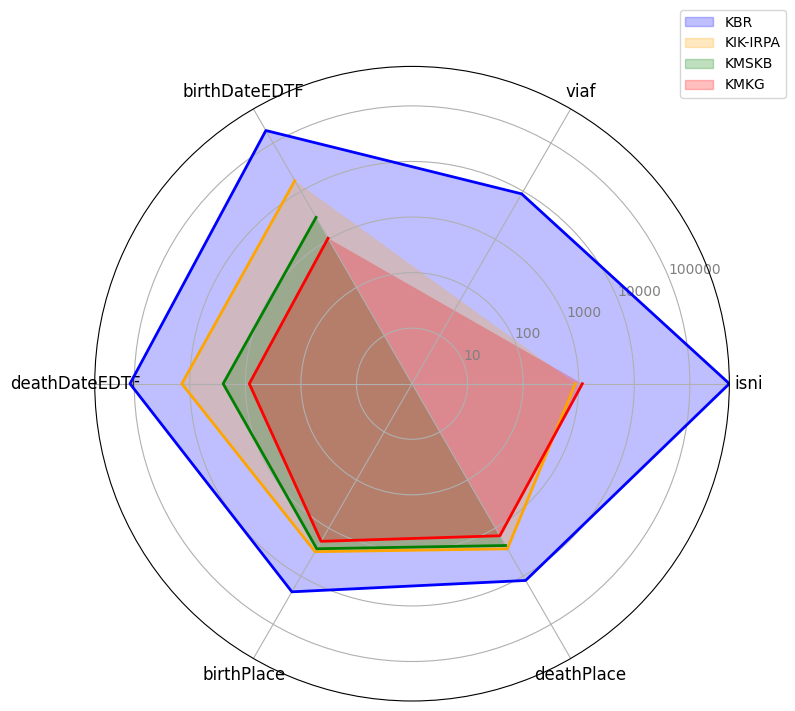

In [84]:
notebook_utils.plotRadarChart(statsDataframes, variables)

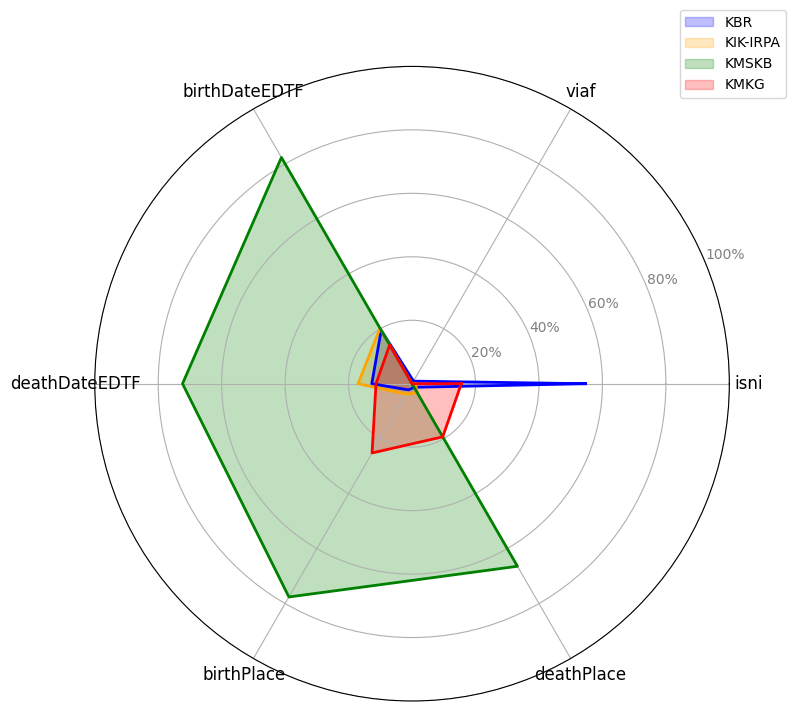

In [85]:
notebook_utils.plotRadarChartPercentage(statsDataframes, variables)

## Statistics and visualizations per datafield


### Birth date stats

In [86]:
groupedBirthDates = birthDateDf.groupby(['rule', 'dataSource']).size().reset_index(name='count').sort_values(by=['count'], ascending=False)

In [87]:
pivotBirthDates = groupedBirthDates.pivot(index='rule', columns='dataSource', values='count').fillna(0).astype(int)

In [88]:
pivotBirthDates

dataSource                   KBR  KIK-IRPA  KMKG  KMSKB
rule                                                   
after_year                    10         0     0      0
before_dash_date               0         0     2      0
before_year                   20         0     7      0
between_years                  0         0     2      0
century                    10473         0     0      0
circa_year                 16229         0    99    176
flourish_century              23         0     0      0
flourish_year               8988         0     0      0
one_of_two_years_dash          3         0     4     17
one_of_two_years_slash         2         0    10     80
simplePattern             145183     16572   894   2574
uncertain_year                 1         0     2      2
written_month_year             5         0    25      0
year_and_text               1805        23     3      3
year_month                    67         0     0      0
year_or                        0         0     4      1
years_slash_abbreviation       1         0     4      5

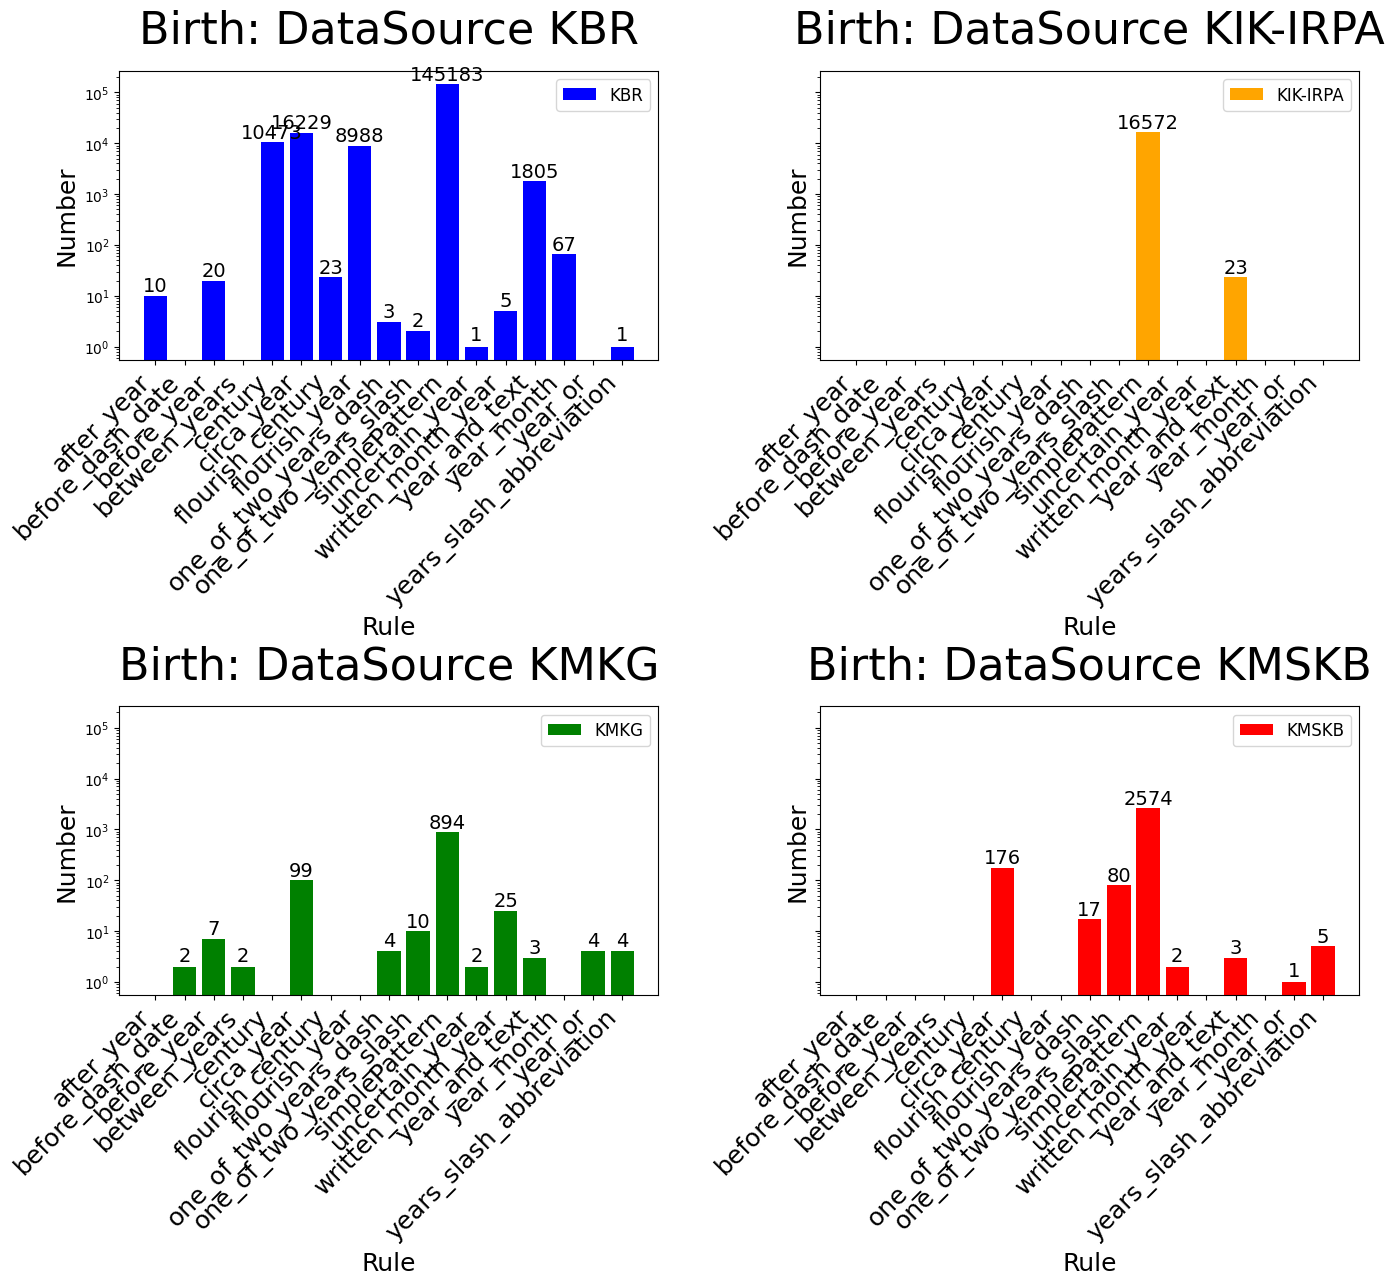

In [89]:
notebook_utils.plotDatePatternsPercentages(pivotBirthDates, 
                                           'Birth',
                                           is_percentage=False,
                                           save_path_pdf='birthDate-rules_plot.pdf', 
                                           save_path_png='birthDate-rules_plot.png')

In [90]:
birthDateDf

birthDateEDTF birthDate-original           rule dataSource
autID                                                                  
kbr|10038111          1883                     simplePattern        KBR
kbr|10038121          1885                     simplePattern        KBR
kbr|10038133          1897                     simplePattern        KBR
kbr|10038139          1844                     simplePattern        KBR
kbr|10038142          1850                     simplePattern        KBR
...                    ...                ...            ...        ...
kmskb|509/95          1859                     simplePattern      KMSKB
kmskb|509/96          1873                     simplePattern      KMSKB
kmskb|509/97          1883                     simplePattern      KMSKB
kmskb|509/98          1809                     simplePattern      KMSKB
kmskb|509/99          1797                     simplePattern      KMSKB

[203319 rows x 4 columns]

In [91]:
birthDateDf['certainBirthDate'] = birthDateDf['birthDateEDTF'].apply(notebook_utils.isCertainEDTFDate)
birthDateDf['birthDatePrecision'] = birthDateDf['birthDateEDTF'].apply(notebook_utils.getDatePrecision)

In [92]:
birthDateDf['birthDatePrecision'].shape[0]

203319

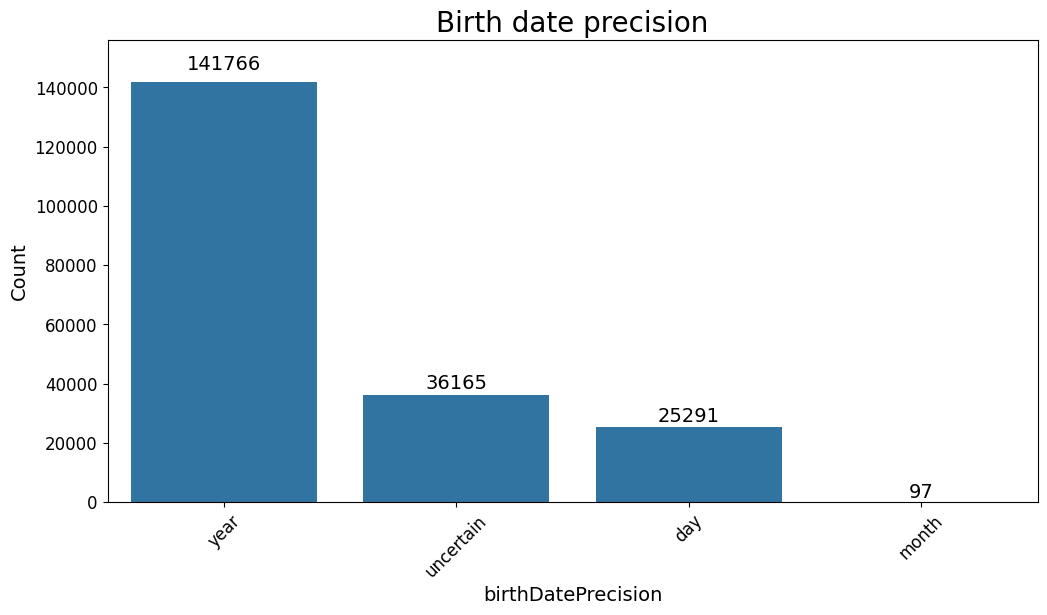

In [93]:
notebook_utils.plotBarChart(birthDateDf, 
                            x_column='birthDatePrecision',
                            title='Birth date precision',
                           save_path_pdf='birth-date-precision.pdf',
                           save_path_png='birth-date-precision.png')

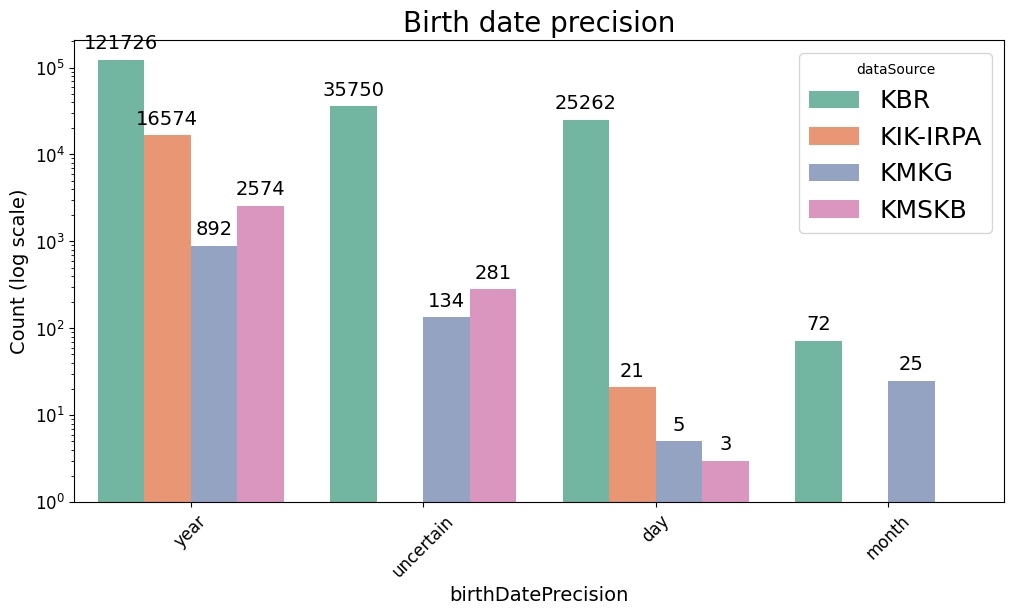

In [94]:
notebook_utils.plotBarChart(birthDateDf, 
                            x_column='birthDatePrecision',
                            group_column='dataSource',
                            title='Birth date precision',
                            log_scale=True,
                           save_path_pdf='birth-date-precision-per-data-source.pdf',
                           save_path_png='birth-date-precision-per-data-source.png')

In [95]:
birthDateDf[['birthDatePrecision', 'dataSource']]

birthDatePrecision dataSource
autID                                     
kbr|10038111               year        KBR
kbr|10038121               year        KBR
kbr|10038133               year        KBR
kbr|10038139               year        KBR
kbr|10038142               year        KBR
...                         ...        ...
kmskb|509/95               year      KMSKB
kmskb|509/96               year      KMSKB
kmskb|509/97               year      KMSKB
kmskb|509/98               year      KMSKB
kmskb|509/99               year      KMSKB

[203319 rows x 2 columns]

In [96]:
# Normalize the data by dataSource to get percentages
#percentage_data_birth = pivotBirthDates.div(pivotBirthDates.sum(axis=0), axis=1) * 100

In [97]:
#percentage_data_birth

In [98]:
#notebook_utils.plotDatePatternsPercentages(percentage_data_birth, 
#                                           'Birth',
#                                           is_percentage=True,
#                                           save_path_pdf='birthDate-rules_percentage_plot.pdf', 
#                                           save_path_png='birthDate-rules_percentage_plot.png')

In [99]:
# Extract the decade from birthDate
def extract_decade(date):
    if isinstance(date, str) and date[:4].isdigit():
        year = int(date[:4])
        return (year // 10) * 10  # Calculate decade
    else:
        return np.nan  # Handle non-numeric cases

birthDateDf['decade'] = birthDateDf['birthDateEDTF'].apply(extract_decade)

# Group data by dataSource and decade
decade_counts_birth = (birthDateDf.groupby(['dataSource', 'decade'])
                 .size()
                 .reset_index(name='count'))

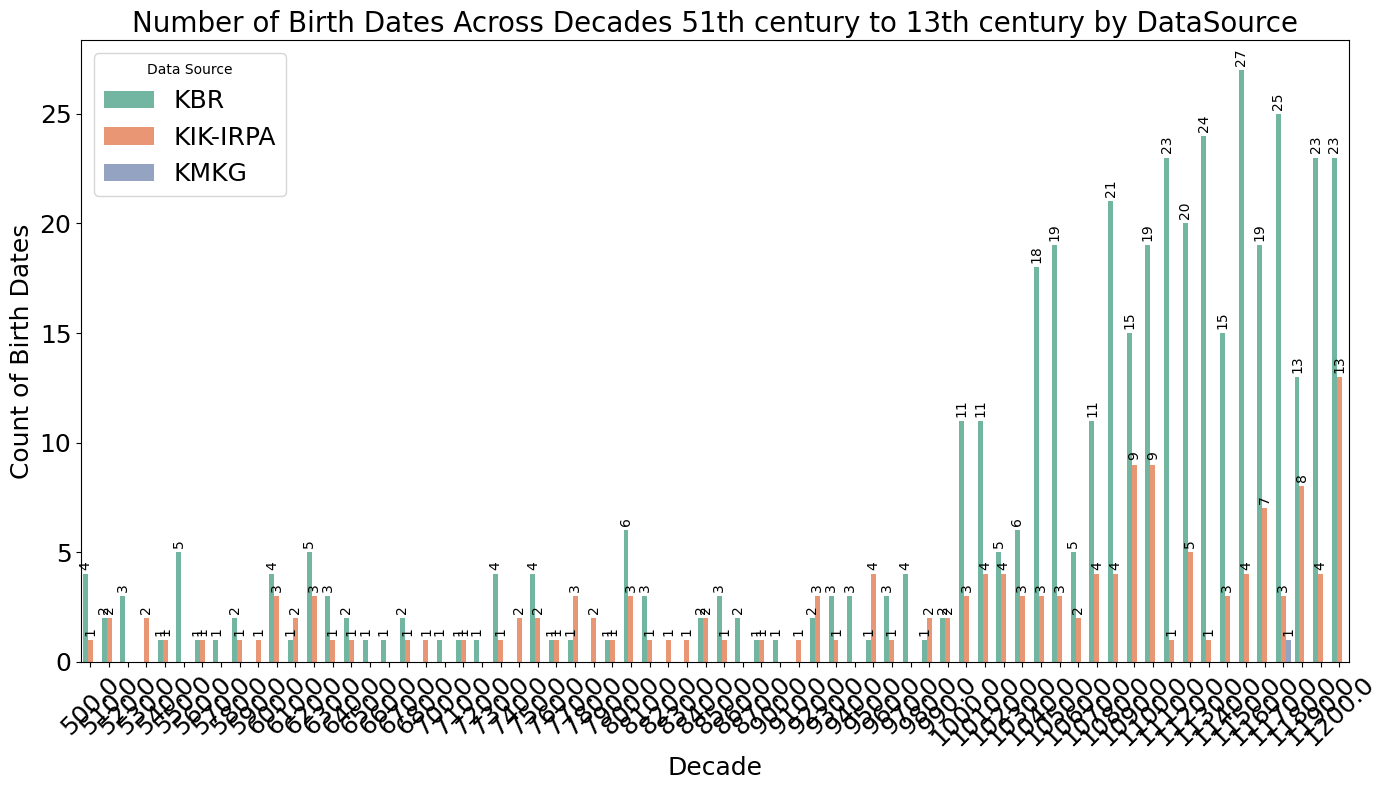

In [100]:
notebook_utils.plotDecade(decade_counts_birth, 'Birth', min_decade=500, max_decade=1200)

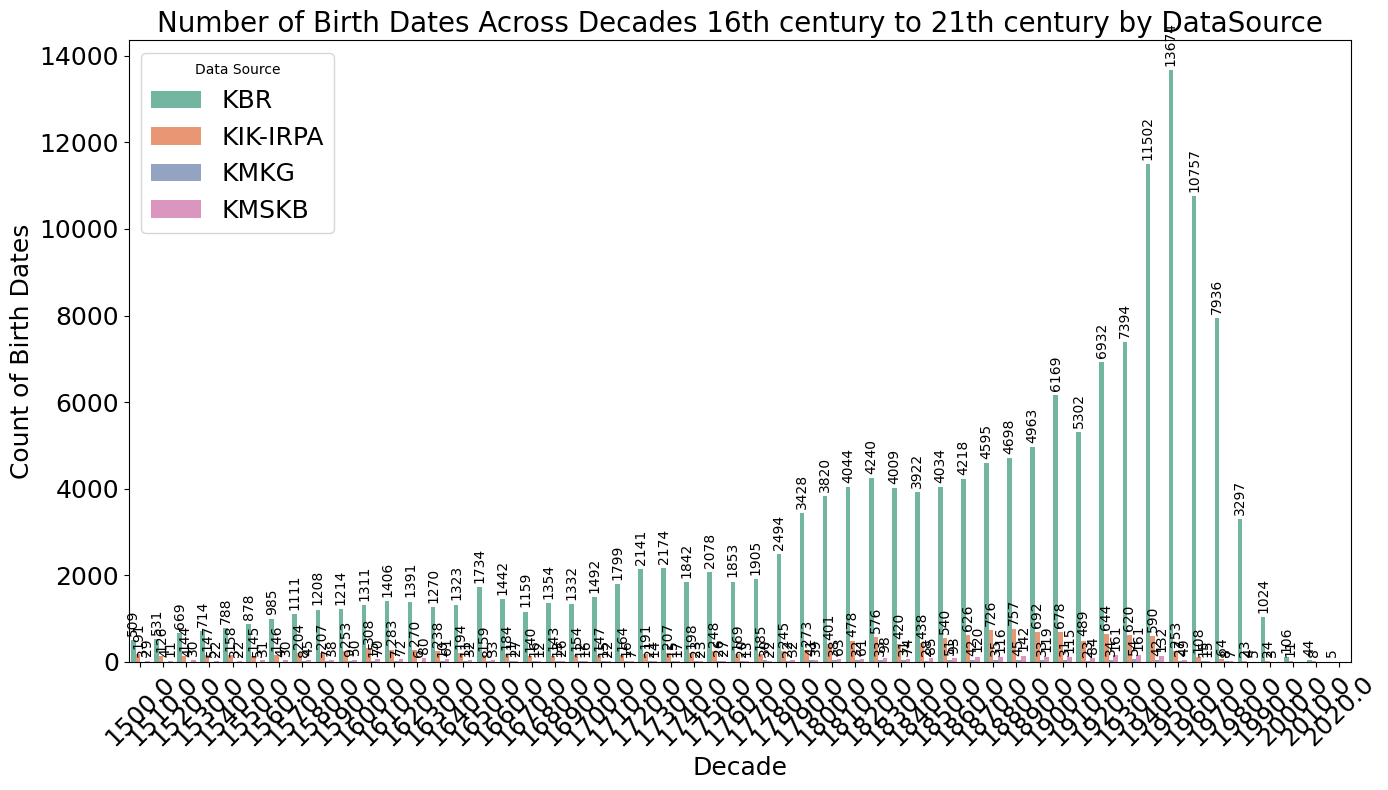

In [101]:
notebook_utils.plotDecade(decade_counts_birth, 'Birth', min_decade=1500, max_decade=2020)

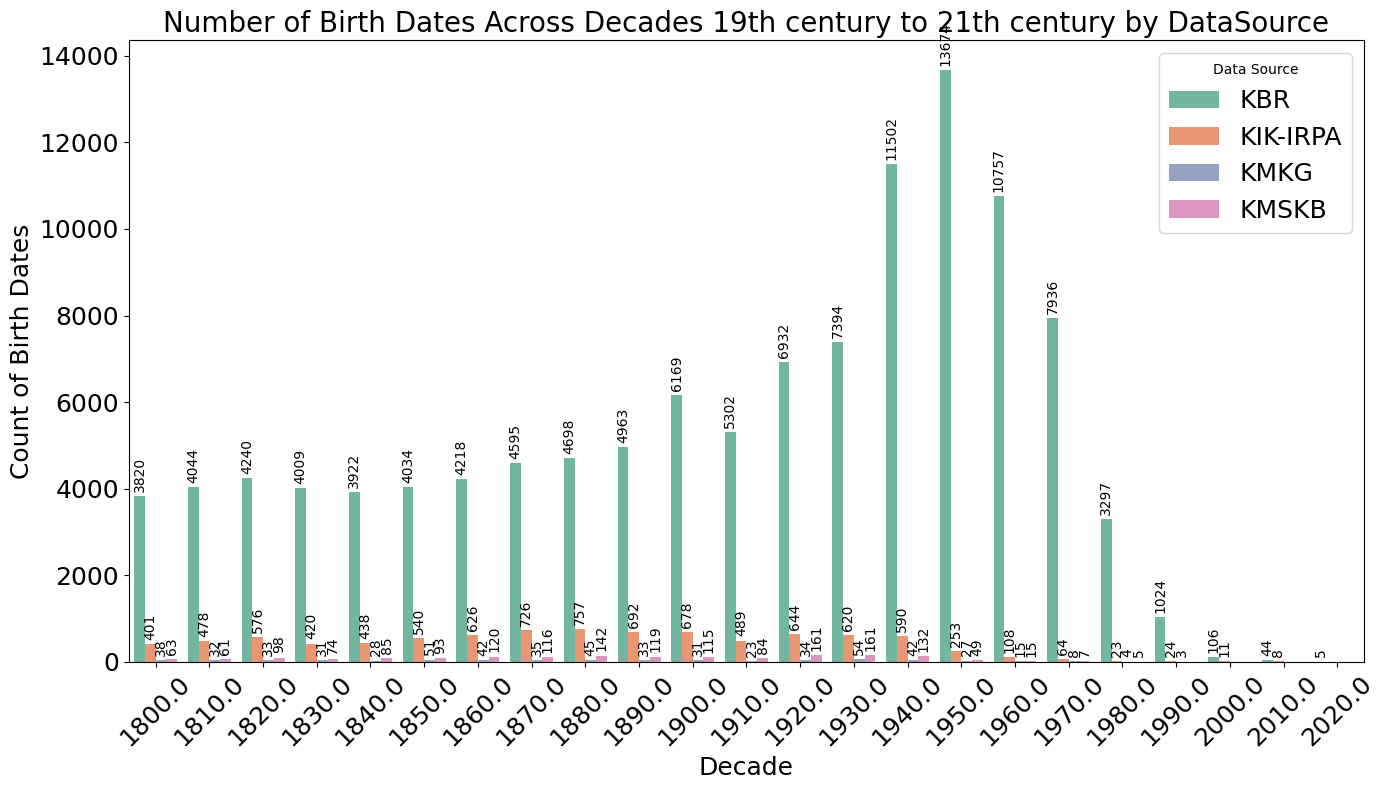

In [102]:
notebook_utils.plotDecade(decade_counts_birth, 'Birth', min_decade=1800, max_decade=2020)

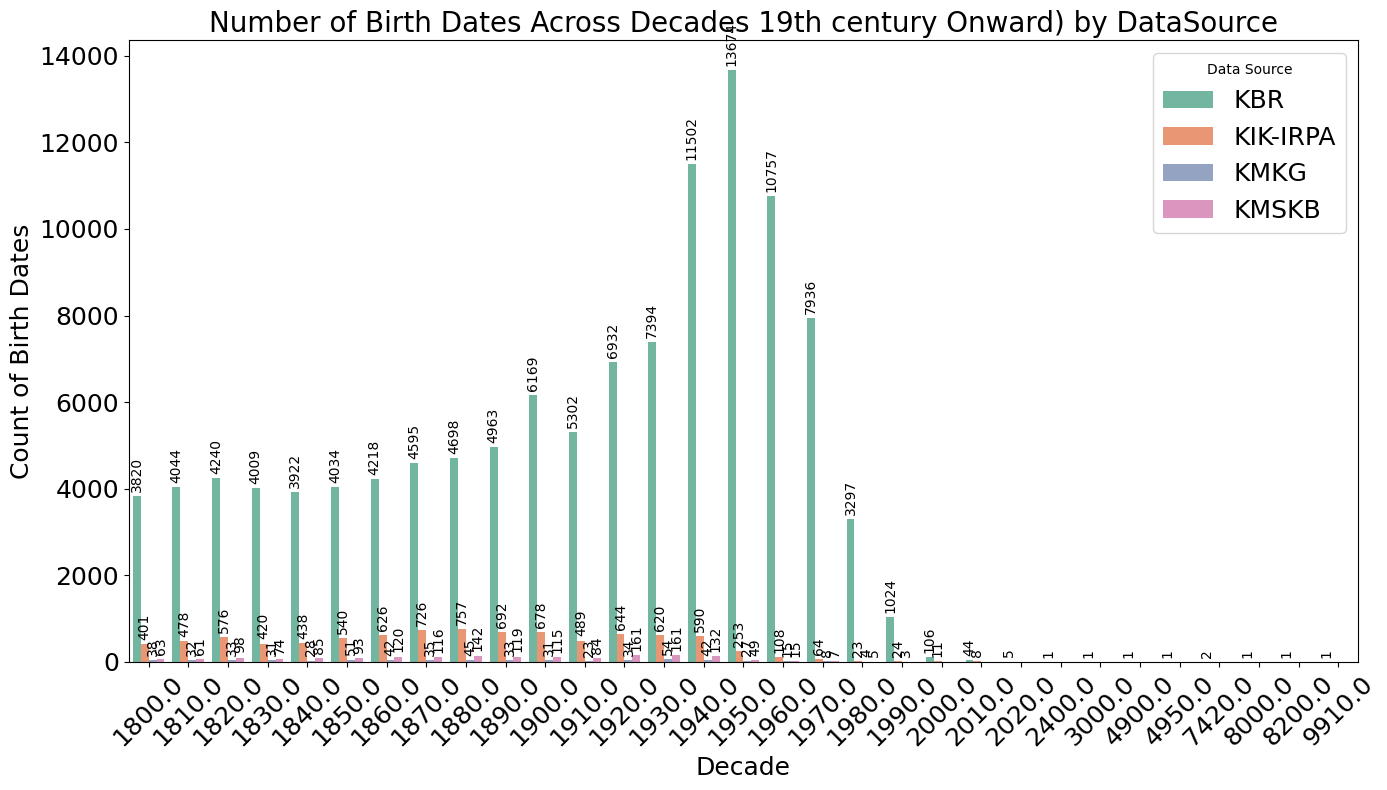

In [103]:
notebook_utils.plotDecade(decade_counts_birth, 'Birth', 1800)

### Death date stats

In [104]:
groupedDeathDates = deathDateDf.groupby(['rule', 'dataSource']).size().reset_index(name='count').sort_values(by=['count'], ascending=False)

In [105]:
pivotDeathDates = groupedDeathDates.pivot(index='rule', columns='dataSource', values='count').fillna(0).astype(int)

In [106]:
pivotDeathDates

dataSource                   KBR  KIK-IRPA  KMKG  KMSKB
rule                                                   
after_written_month_year       0         0     1      0
after_year                    79         0    47      0
before_year                   24         0     4      0
between_years                  0         0     6      0
century                     3100         0     1      0
circa_year                   560         0    39     94
flourish_century              35         0     0      0
flourish_year               6387         0     0      0
one_of_two_years_dash        144         0     2      6
one_of_two_years_slash        52         0     7     37
simplePattern             101629     13930   698   2366
uncertain_year                11         0     2      1
written_month_year            22         0    21      0
year_and_text               7064        18    19      4
year_month                   115         1     0      0
year_or                       13         0     3      0
year_or_brackets               2         0     0      0
years_slash_abbreviation      65         0     0      3

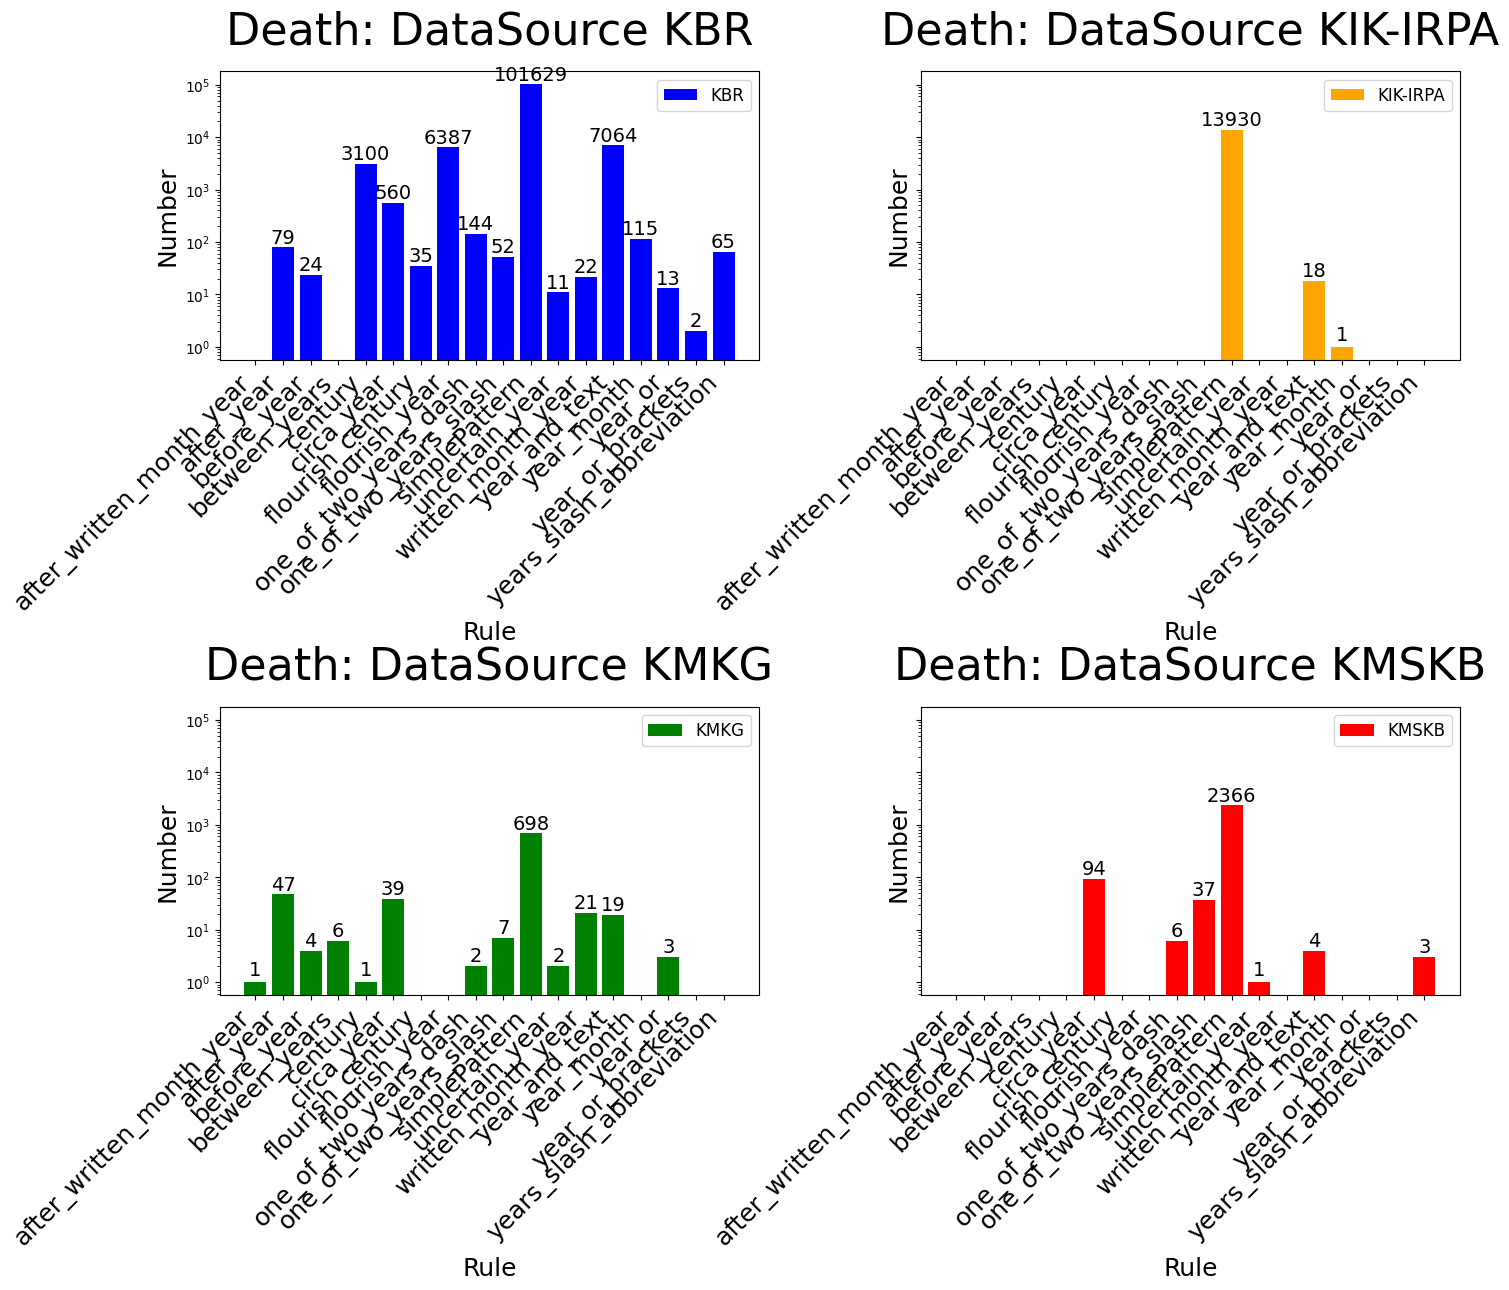

In [107]:
notebook_utils.plotDatePatternsPercentages(pivotDeathDates, 
                                           'Death',
                                           is_percentage=False,
                                           save_path_pdf='deathDate-rules_plot.pdf', 
                                           save_path_png='deathDate-rules_plot.png')

In [108]:
deathDateDf['certainDeathDate'] = deathDateDf['deathDateEDTF'].apply(notebook_utils.isCertainEDTFDate)
deathDateDf['deathDatePrecision'] = deathDateDf['deathDateEDTF'].apply(notebook_utils.getDatePrecision)

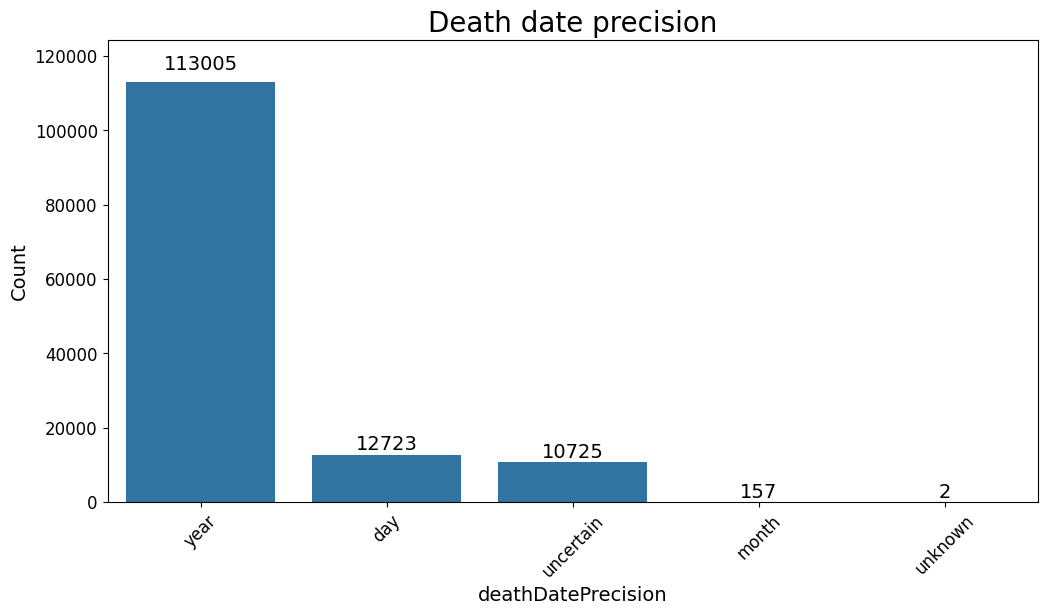

In [109]:
notebook_utils.plotBarChart(deathDateDf, 
                            x_column='deathDatePrecision',
                            title='Death date precision',
                           save_path_pdf='death-date-precision.pdf',
                           save_path_png='death-date-precision.png')

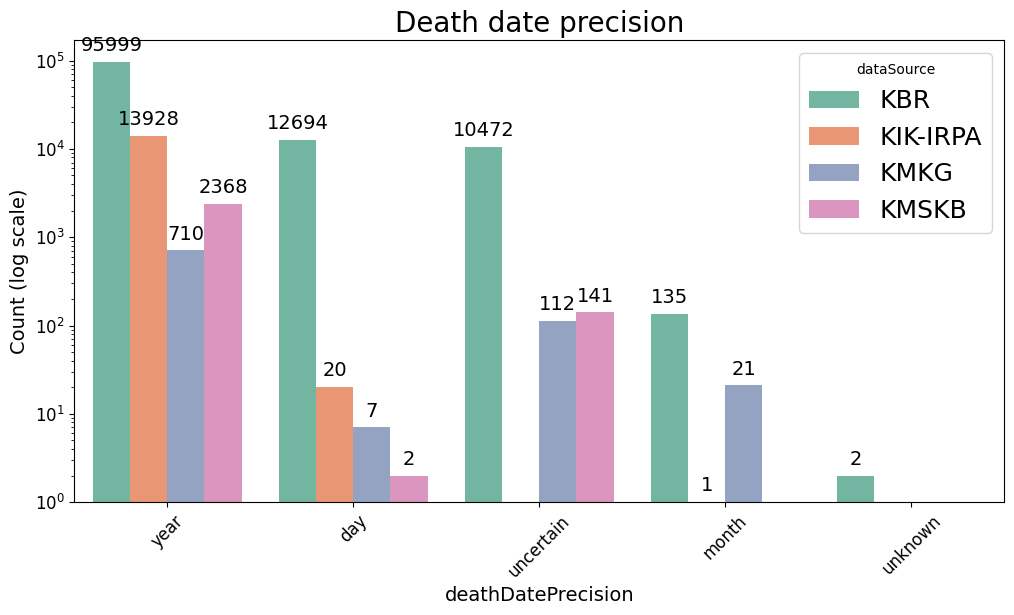

In [110]:
notebook_utils.plotBarChart(deathDateDf, 
                            x_column='deathDatePrecision',
                            group_column='dataSource',
                            title='Death date precision',
                            log_scale=True,
                           save_path_pdf='death-date-precision-per-data-source.pdf',
                           save_path_png='death-date-precision-per-data-source.png')

In [111]:
# Normalize the data by dataSource to get percentages
#percentage_data_death = pivotDeathDates.div(pivotDeathDates.sum(axis=0), axis=1) * 100

In [112]:
#notebook_utils.plotDatePatternsPercentages(percentage_data_death, 
#                                           'Death',
#                                           is_percentage=True,
#                                           save_path_pdf='deathDate-rules_percentage_plot.pdf', 
#                                           save_path_png='deathDate-rules_percentage_plot.png')

In [113]:
deathDateDf['decade'] = deathDateDf['deathDateEDTF'].apply(extract_decade)

# Group data by dataSource and decade
decade_counts_death = (deathDateDf.groupby(['dataSource', 'decade'])
                 .size()
                 .reset_index(name='count'))

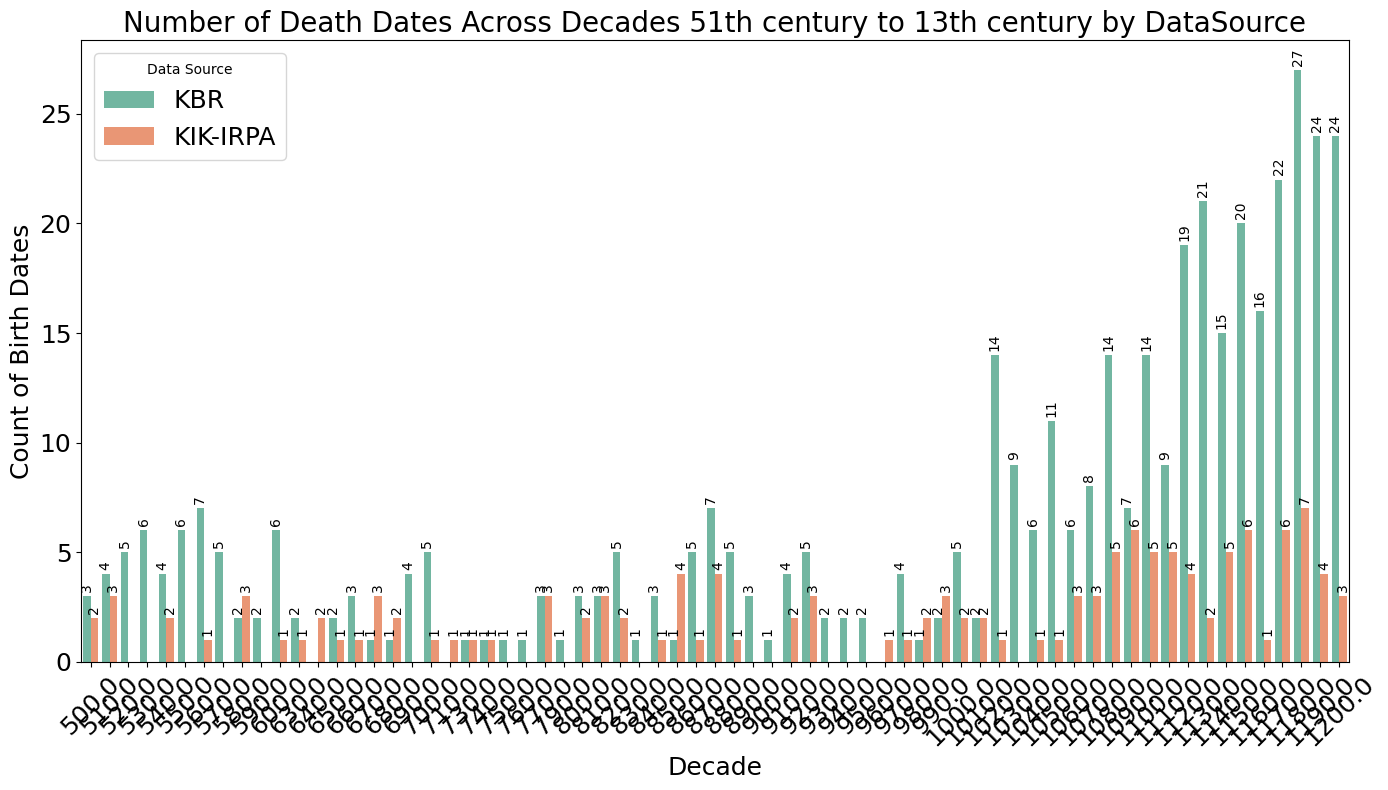

In [114]:
notebook_utils.plotDecade(decade_counts_death, 'Death', min_decade=500, max_decade=1200)

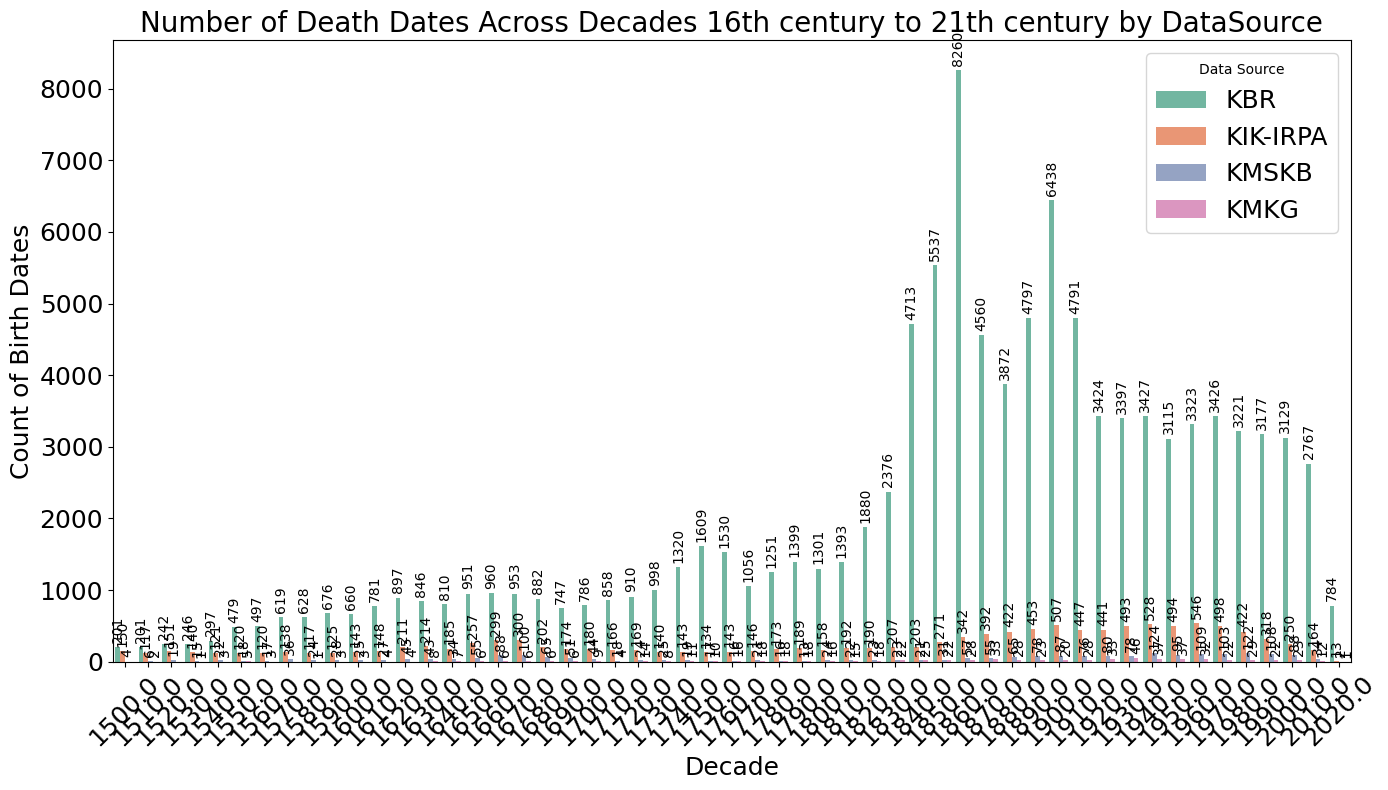

In [115]:
notebook_utils.plotDecade(decade_counts_death, 'Death', min_decade=1500, max_decade=2020)

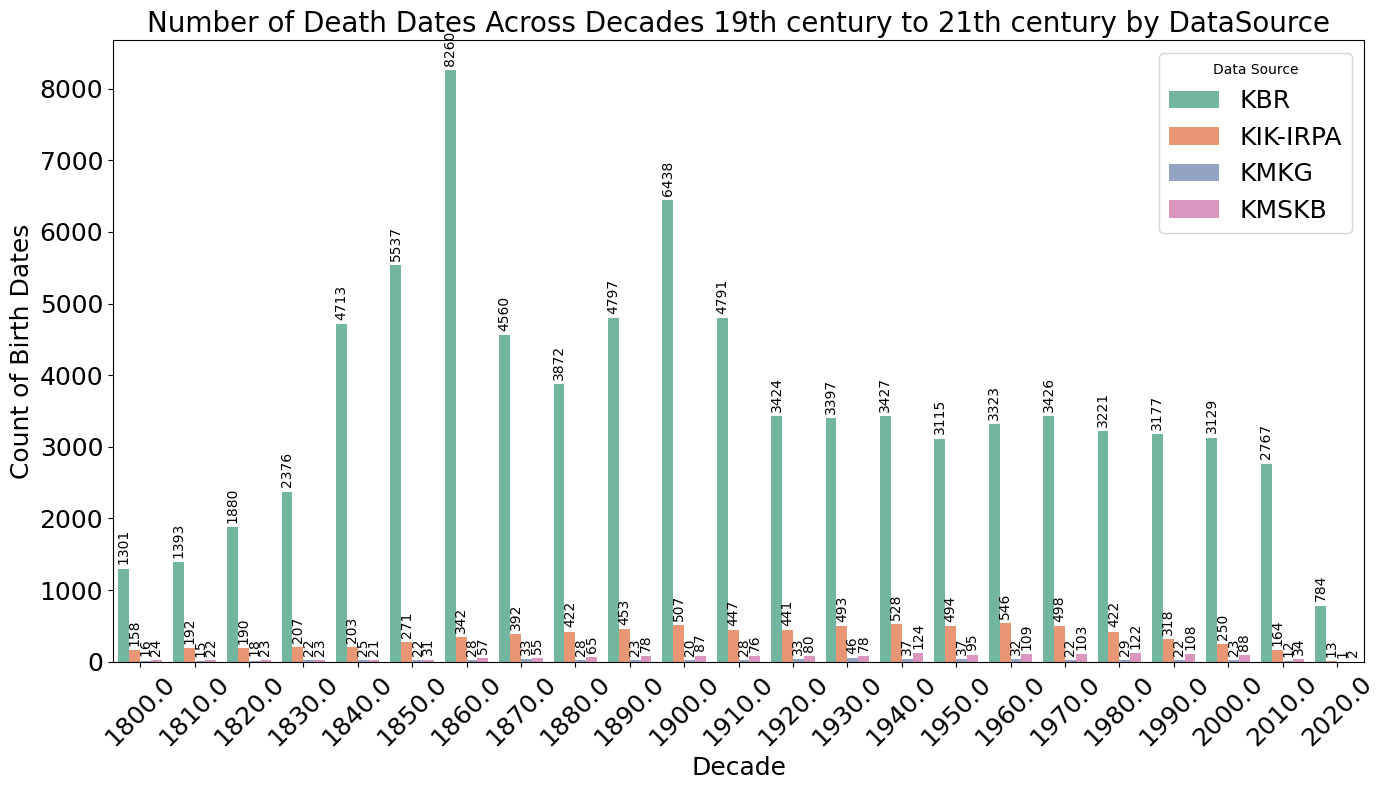

In [116]:
notebook_utils.plotDecade(decade_counts_death, 'Death', min_decade=1800, max_decade=2020)

### Date parsing stats

In [117]:
dateParsingFrames = []
for dataSource, info in extractInfo.items():
    logFileName = os.path.join(os.path.dirname(info['outputFilename']), f'{info["prefix"]}.log')
    if os.path.getsize(logFileName) > 0:
        print(f'processing {logFileName}')
        currentDf = pd.read_csv(logFileName, keep_default_na=False)
        # explicitly indicate the data source in a separate column
        currentDf['dataSource'] = dataSource

        dateParsingFrames.append(currentDf)
    else:
        print(f'empty logfile {logFileName}')
dateParsingDf = pd.concat(dateParsingFrames)

processing kik-irpa/kik-irpa-data.log
processing kbr/kbr-data.log
processing kmskb/kmskb-data.log
processing kmkg/kmkg-data.log


In [118]:
dateParsingDf

time    level              name   message_type  \
0   2025-02-28 14:04:25.849  WARNING  XML_TO_CSV.utils  invalid_value   
1   2025-02-28 14:04:25.854  WARNING  XML_TO_CSV.utils  invalid_value   
2   2025-02-28 14:04:25.854  WARNING  XML_TO_CSV.utils  invalid_value   
3   2025-02-28 14:04:25.855  WARNING  XML_TO_CSV.utils  invalid_value   
4   2025-02-28 14:04:25.913  WARNING  XML_TO_CSV.utils  invalid_value   
..                      ...      ...               ...            ...   
6   2025-03-31 13:37:29.889    ERROR  XML_TO_CSV.utils  invalid_value   
7   2025-03-31 13:37:30.036    ERROR  XML_TO_CSV.utils  invalid_value   
8   2025-03-31 13:37:30.781    ERROR  XML_TO_CSV.utils  invalid_value   
9   2025-03-31 13:37:31.363    ERROR  XML_TO_CSV.utils  invalid_value   
10  2025-03-31 13:37:31.378    ERROR  XML_TO_CSV.utils  invalid_value   

   identifier                                            message dataSource  
0    14632099  14632099: placeholder value "--" found instead...        KBR  
1    21678679  21678679: placeholder value "--" found instead...        KBR  
2    21678679  21678679: placeholder value "--" found instead...        KBR  
3    21678676  21678676: placeholder value "--" found instead...        KBR  
4    21465202  21465202: placeholder value "--" found instead...        KBR  
..        ...                                                ...        ...  
6        3688  3688: no match with parseDate or parseComplexD...       KMKG  
7      522480  522480: no match with parseDate or parseComple...       KMKG  
8         643  643: no match with parseDate or parseComplexDa...       KMKG  
9      299441  299441: no match with parseDate or parseComple...       KMKG  
10     340450  340450: no match with parseDate or parseComple...       KMKG  

[13619 rows x 7 columns]

In [119]:
dateParsingDf['message_type'].value_counts()

message_type
invalid_value                 7299
script_configuration_error    6320
Name: count, dtype: int64

In [120]:
dateParsingDf[dateParsingDf['message_type'] == 'script_configuration_error']

time    level              name  \
0     2025-02-28 14:09:14.153  WARNING  XML_TO_CSV.utils   
1     2025-02-28 14:09:14.153  WARNING  XML_TO_CSV.utils   
2     2025-02-28 14:09:14.165  WARNING  XML_TO_CSV.utils   
3     2025-02-28 14:09:14.165  WARNING  XML_TO_CSV.utils   
4     2025-02-28 14:09:14.165  WARNING  XML_TO_CSV.utils   
...                       ...      ...               ...   
6318  2025-02-28 14:09:15.174  WARNING  XML_TO_CSV.utils   
6319  2025-02-28 14:09:15.174  WARNING  XML_TO_CSV.utils   
6320  2025-02-28 14:09:15.174  WARNING  XML_TO_CSV.utils   
6321  2025-02-28 14:09:15.174  WARNING  XML_TO_CSV.utils   
6322  2025-02-28 14:09:15.175  WARNING  XML_TO_CSV.utils   

                    message_type identifier  \
0     script_configuration_error              
1     script_configuration_error              
2     script_configuration_error              
3     script_configuration_error              
4     script_configuration_error              
...                          ...        ...   
6318  script_configuration_error              
6319  script_configuration_error              
6320  script_configuration_error              
6321  script_configuration_error              
6322  script_configuration_error              

                                                message dataSource  
0     multiple values for subfield lastName in recor...      KMSKB  
1     multiple values for subfield firstName in reco...      KMSKB  
2     multiple values for subfield lastName in recor...      KMSKB  
3     multiple values for subfield firstName in reco...      KMSKB  
4     multiple values for subfield lastName in recor...      KMSKB  
...                                                 ...        ...  
6318  multiple values for subfield lastName in recor...      KMSKB  
6319  multiple values for subfield lastName in recor...      KMSKB  
6320  multiple values for subfield lastName in recor...      KMSKB  
6321  multiple values for subfield lastName in recor...      KMSKB  
6322  multiple values for subfield lastName in recor...      KMSKB  

[6320 rows x 7 columns]

### Stats for enriching of geo information

In [121]:
# todo: execute geoname enrichment, I already have bash scripts for this, 
# because of time pressure I don't need to add this now, 
# I can continue with the analysis of the already created files
if enrichGeoAgain:
    pass

In [122]:
placeEnrichmentLogs = []
for dataSource, info in extractInfo.items():

        enrichLogfileNameBirth = os.path.join(os.path.dirname(info['outputFilename']), f'{info["prefix"]}-birthPlace-enriched.log')
        enrichLogfileNameDeath = os.path.join(os.path.dirname(info['outputFilename']), f'{info["prefix"]}-deathPlace-enriched.log')
        birthPlaceLogDf = pd.read_csv(enrichLogfileNameBirth)
        deathPlaceLogDf = pd.read_csv(enrichLogfileNameDeath)
        
        birthPlaceLogDf['dataSource'] = dataSource
        deathPlaceLogDf['dataSource'] = dataSource
        birthPlaceLogDf['variableType'] = 'birthPlace'
        deathPlaceLogDf['variableType'] = 'deathPlace'
        placeEnrichmentLogs.extend([birthPlaceLogDf, deathPlaceLogDf])
        
placeLogDf = pd.concat(placeEnrichmentLogs)

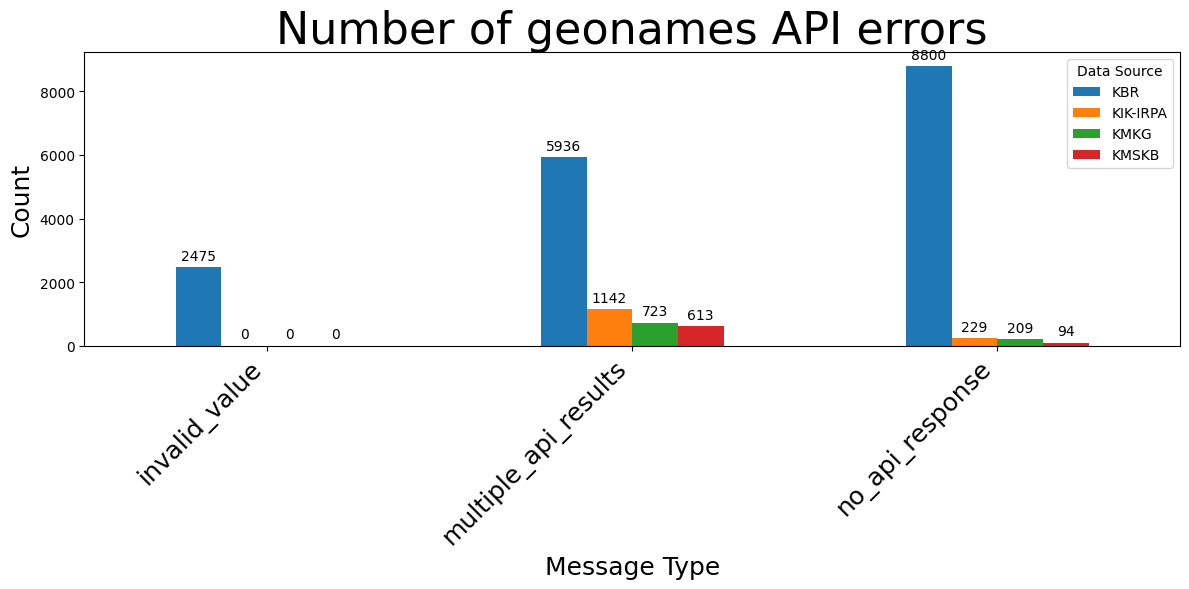

In [123]:
grouped_df = placeLogDf.groupby(['message_type', 'dataSource']).size().to_frame('size').reset_index()

# Pivot the DataFrame: rows = message_type, columns = dataSource, values = size
pivot_df = grouped_df.pivot(index='message_type', columns='dataSource', values='size')

# Plot a grouped bar chart
ax = pivot_df.plot(kind='bar', figsize=(12,6))

# Set labels and title
ax.set_xlabel("Message Type", fontsize=18)
ax.set_ylabel("Count", fontsize=18)
ax.set_title("Number of geonames API errors", fontsize=32)
plt.legend(title="Data Source")

# Annotate bars with their values
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type="edge", padding=3, fontsize=10)

plt.xticks(rotation=45, fontsize=18, ha='right')
plt.margins(x=0.02) 
plt.tight_layout()
plt.savefig('geonames-enrichment-errors.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.savefig('geonames-enrichment-errors.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

In [124]:
placeLogDf[placeLogDf['message_type'] == 'invalid_value']

time    level                name   message_type  \
93    2025-01-14 16:41:30.899  WARNING  GEONAME_ENRICHMENT  invalid_value   
125   2025-01-14 16:41:34.685  WARNING  GEONAME_ENRICHMENT  invalid_value   
197   2025-01-14 16:41:48.612  WARNING  GEONAME_ENRICHMENT  invalid_value   
254   2025-01-14 16:41:56.871  WARNING  GEONAME_ENRICHMENT  invalid_value   
311   2025-01-14 16:42:04.712  WARNING  GEONAME_ENRICHMENT  invalid_value   
...                       ...      ...                 ...            ...   
6845  2025-01-14 17:12:53.162  WARNING  GEONAME_ENRICHMENT  invalid_value   
6847  2025-01-14 17:12:53.415  WARNING  GEONAME_ENRICHMENT  invalid_value   
6850  2025-01-14 17:12:53.602  WARNING  GEONAME_ENRICHMENT  invalid_value   
6851  2025-01-14 17:12:53.602  WARNING  GEONAME_ENRICHMENT  invalid_value   
6854  2025-01-14 17:12:53.775  WARNING  GEONAME_ENRICHMENT  invalid_value   

     identifier                             message dataSource variableType  
93     21070217  Invalid placename (21070217): "--"        KBR   birthPlace  
125    21957916  Invalid placename (21957916): "--"        KBR   birthPlace  
197    21986984  Invalid placename (21986984): "--"        KBR   birthPlace  
254    21672554  Invalid placename (21672554): "--"        KBR   birthPlace  
311    21836378  Invalid placename (21836378): "--"        KBR   birthPlace  
...         ...                                 ...        ...          ...  
6845   14692633  Invalid placename (14692633): "--"        KBR   deathPlace  
6847   14745339  Invalid placename (14745339): "--"        KBR   deathPlace  
6850   14048847  Invalid placename (14048847): "--"        KBR   deathPlace  
6851   14093249  Invalid placename (14093249): "--"        KBR   deathPlace  
6854   22178639  Invalid placename (22178639): "--"        KBR   deathPlace  

[2475 rows x 8 columns]

In [125]:
placeLogDf['multiple_result_list'] = None

placeLogDf['multiple_result_list'] = placeLogDf.apply(
    lambda row: row['message'].split(':', 1)[1].strip() if row['message_type'] == 'multiple_api_results' else None,
    axis=1
)

#placeLogDf.loc[placeLogDf['message_type'] == 'multiple_api_results', 'multiple_result_list'] = (
#  placeLogDf.loc[placeLogDf['message_type'] == 'multiple_api_results', 'multiple_result_list']
#    .str.split(':')
#    .str[1]
#    .str.strip()
#)


In [126]:
multiplePlaceStatsDf = placeLogDf[placeLogDf['message_type'] == 'multiple_api_results'][['multiple_result_list']].groupby(['multiple_result_list']).size().reset_index(name='count').set_index('multiple_result_list').sort_values(by=['count'], ascending=False)

In [127]:
multiplePlaceStatsDf

count
multiple_result_list                                     
chosen "Paris (FR,2988507)" from Les Paris (FR,...   2679
chosen "London (GB,2643743)" from London (GB, 2...    611
Mechelen-Bovelingen (BE, 2791532, population: 1...    264
Berlin (DE, 2950159, population: 3426354), Berl...    185
Marseille-en-Beauvaisis (FR, 2995463, populatio...    108
...                                                   ...
De Horst (NL, 2757491, population: 0), De Horst...      1
Montbray (FR, 2992894, population: 415), Montbr...      1
Montbrison-sur-Lez (FR, 2992887, population: 33...      1
Montepulciano (IT, 3172794, population: 3446), ...      1
Ново Село (MK, 787562, population: 0), Novo Sel...      1

[1315 rows x 1 columns]

In [128]:
multiplePlaceStatsDf[multiplePlaceStatsDf['count'] > 20]

count
multiple_result_list                                     
chosen "Paris (FR,2988507)" from Les Paris (FR,...   2679
chosen "London (GB,2643743)" from London (GB, 2...    611
Mechelen-Bovelingen (BE, 2791532, population: 1...    264
Berlin (DE, 2950159, population: 3426354), Berl...    185
Marseille-en-Beauvaisis (FR, 2995463, populatio...    108
Schaerbeek (BE, 2787149, population: 132761), S...    104
't Hasselt (BE, 2785598, population: 0), Hassel...     95
Aalst (BE, 2803450, population: 0), Aalst (BE, ...     89
New York City (US, 5128581, population: 8804190...     87
Bordeaux-en-Gâtinais (FR, 3031579, population: ...     82
Nancy-sur-Cluses (FR, 2990997, population: 391)...     75
Roeselare (BE, 2787889, population: 56016), Roe...     71
Borgerhout (BE, 2801472, population: 0), Borger...     65
Saint-Nicolas (BE, 2787356, population: 22586),...     64
Toulouse-le-Château (FR, 2972313, population: 1...     62
Milan (IT, 3173435, population: 1371498), Milan...     56
Nantes-en-Ratier (FR, 2990967, population: 429)...     54
Dijon (FR, 3021372, population: 158002), Dijon ...     47
Berchem (BE, 2802251, population: 2423), Berche...     45
Naples (IT, 3172394, population: 909048), Napol...     45
Buenos Aires (AR, 3435910, population: 2891082)...     43
Montpellier-de-Médillan (FR, 2992163, populatio...     41
Milan (IT, 3173435, population: 1371498), Milan...     40
Bologna (IT, 3181928, population: 394843), Bolo...     37
Tokyo (JP, 1850147, population: 8336599), Edo (...     36
Tielt (BE, 2785476, population: 19299), Tielt (...     34
Halet (BE, 2796711, population: 0), Hal (BE, 27...     34
Venice (IT, 3164603, population: 51298), Venezi...     33
Bologna (IT, 3181928, population: 394843), Bolo...     33
Metz-Tessy (FR, 2994150, population: 3051), Met...     32
Turin (IT, 3165524, population: 847287), Turin ...     29
Verona (IT, 3164527, population: 258031), Veron...     29
Cannes-et-Clairan (FR, 3028805, population: 336...     29
Mons (BE, 2790869, population: 95299), Bergen (...     29
Tours-sur-Meymont (FR, 2972185, population: 550...     28
Deurne (BE, 2799478, population: 78747), Deurne...     28
Reims-la-Brulée (FR, 2984111, population: 0), R...     26
Rennes-sur-Loue (FR, 2983984, population: 94), ...     26
Toulon-sur-Arroux (FR, 2972320, population: 165...     25
Rome (IT, 3169070, population: 2318895), Roma (...     22
Cambridge (GB, 2653941, population: 145674), Ca...     22
Knok (BE, 2794219, population: 0), Knokke (BE, ...     22
Sèvres-Anxaumont (FR, 2974677, population: 1957...     21
Pau (FR, 2988358, population: 82697), Pau (FR, ...     21

<Axes: xlabel='multiple_result_list'>

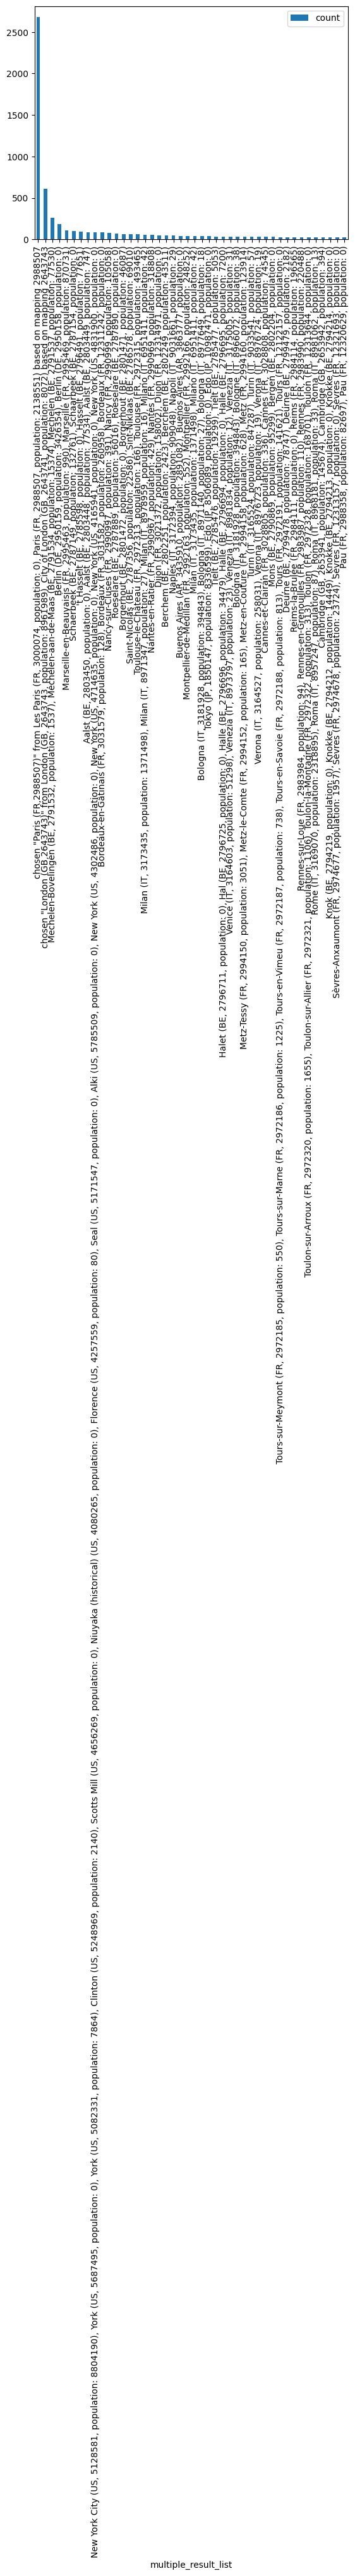

In [129]:
multiplePlaceStatsDf[multiplePlaceStatsDf['count'] > 20].plot(kind='bar')

In [130]:
multiplePlaceStatsDf.to_csv('multiple-api-results-occurrences-list.csv')
multiplePlaceStatsDf[multiplePlaceStatsDf.index.str.contains('BE,')].to_csv('multiple-api-results-occurrences-list-belgium.csv')

In [131]:
groupedBirthPlacesLogs = placeLogDf[placeLogDf['variableType'] == 'birthPlace'].groupby(['message_type', 'dataSource']).size().reset_index(name='count').sort_values(by=['count'], ascending=False)
groupedBirthPlacesLogs

message_type dataSource  count
5       no_api_response        KBR   6021
1  multiple_api_results        KBR   3548
0         invalid_value        KBR    821
2  multiple_api_results   KIK-IRPA    550
3  multiple_api_results       KMKG    394
4  multiple_api_results      KMSKB    373
7       no_api_response       KMKG    127
6       no_api_response   KIK-IRPA    117
8       no_api_response      KMSKB     62

In [132]:
groupedDeathPlaces = placeLogDf[placeLogDf['variableType'] == 'deathPlace'].groupby(['message_type', 'dataSource']).size().reset_index(name='count').sort_values(by=['count'], ascending=False)
groupedDeathPlaces

message_type dataSource  count
5       no_api_response        KBR   2779
1  multiple_api_results        KBR   2388
0         invalid_value        KBR   1654
2  multiple_api_results   KIK-IRPA    592
3  multiple_api_results       KMKG    329
4  multiple_api_results      KMSKB    240
6       no_api_response   KIK-IRPA    112
7       no_api_response       KMKG     82
8       no_api_response      KMSKB     32

### Geo stats

In [133]:
placeEnrichmentDfs = []
birthPlacesDfs = []
for dataSource, info in extractInfo.items():
    birthPlaceDf = pd.read_csv(info['geo-enriched-birth-place'])
    deathPlaceDf = pd.read_csv(info['geo-enriched-death-place'])
    
    birthPlaceDf['dataSource'] = dataSource
    deathPlaceDf['dataSource'] = dataSource
    birthPlaceDf['variableType'] = 'birthPlace'
    deathPlaceDf['variableType'] = 'deathPlace'
    placeEnrichmentDfs.extend([birthPlaceDf, deathPlaceDf])
    birthPlacesDfs.append(birthPlaceDf)

placeDf = pd.concat(placeEnrichmentDfs)
placeDf['autID'] = placeDf['dataSource'].str.lower() + '|' + placeDf['autID'].astype(str)
placeDf = placeDf.set_index('autID')

allBirthPlacesDf = pd.concat(birthPlacesDfs).set_index('autID')

In [134]:
placeDf

geonameID       placename countryCode dataSource variableType
autID                                                                         
kik-irpa|69        2795011  Ixelles-Elsene          BE   KIK-IRPA   birthPlace
kik-irpa|115       2791964         Maaseik          BE   KIK-IRPA   birthPlace
kik-irpa|240       2988507           Paris          FR   KIK-IRPA   birthPlace
kik-irpa|248       3024090       Commentry          FR   KIK-IRPA   birthPlace
kik-irpa|347       2785470          Tienen          BE   KIK-IRPA   birthPlace
...                    ...             ...         ...        ...          ...
kmkg|kmkg|329      2747373       The Hague          NL       KMKG   deathPlace
kmkg|kmkg|7199    10865987    Shimo’ochiai          JP       KMKG   deathPlace
kmkg|kmkg|38470    3172394          Naples          IT       KMKG   deathPlace
kmkg|kmkg|2491     2988507           Paris          FR       KMKG   deathPlace
kmkg|kmkg|2578     2792413           Liège          BE       KMKG   deathPlace

[31175 rows x 5 columns]

In [135]:
birthPlaceGeonamesDf = allBirthPlacesDf['dataSource'].value_counts(dropna=False).reset_index().rename(columns={'count': 'geonameCount'})

In [136]:
birthPlaceGeonamesDf

dataSource  geonameCount
0        KBR         12490
1   KIK-IRPA          2631
2      KMSKB          2275
3       KMKG          1366

In [137]:
birthPlaceCounts = totals_with_100d_enrichment[totals_with_100d_enrichment['Feature'] == 'with birth place value']
birthPlaceCounts

Feature                                                KBR  \
5  with birth place value  {'count': 21148, 'percentage': 2.2498877609425...   

                                            KIK-IRPA  \
5  {'count': 3100, 'percentage': 3.77776965354196...   

                                               KMSKB  \
5  {'count': 2694, 'percentage': 77.6145203111495...   

                                                KMKG  
5  {'count': 1886, 'percentage': 25.2037952692770...

In [138]:
# Extract the 'count' value for each column
counts_dict = {col: birthPlaceCounts[col].iloc[0]['count'] for col in df['dataSource']}

# Convert to DataFrame
counts_df = pd.DataFrame(list(counts_dict.items()), columns=['dataSource', 'birthPlaceTextCount'])

# Merge with df
birthPlaceGeonamesDf = birthPlaceGeonamesDf.merge(counts_df, on='dataSource')

In [139]:
birthPlaceGeonamesDf['geonamePercentage'] = birthPlaceGeonamesDf['geonameCount'] * 100 / birthPlaceGeonamesDf['birthPlaceTextCount'] 
birthPlaceGeonamesDf['geonamePercentage'] = birthPlaceGeonamesDf['geonamePercentage'].round(2)

In [140]:
birthPlaceGeonamesDf

dataSource  geonameCount  birthPlaceTextCount  geonamePercentage
0        KBR         12490                21148              59.06
1   KIK-IRPA          2631                 3100              84.87
2      KMSKB          2275                 2694              84.45
3       KMKG          1366                 1886              72.43

In [141]:
# Filter for birthPlace and group by dataSource and placename
birth_places = placeDf[placeDf['variableType'] == 'birthPlace']
top_birthplaces = (birth_places.groupby(['dataSource', 'placename'])
                   .size()
                   .reset_index(name='count')
                   .sort_values(['dataSource', 'count'], ascending=[True, False]))

# Get top 10 placenames per dataSource
top_10_birthplaces = top_birthplaces.groupby('dataSource').head(10)
top_10_birthplaces

dataSource       placename  count
1999        KBR           Paris    838
403         KBR        Brussels    787
111         KBR         Antwerp    471
944         KBR           Ghent    339
1506        KBR           Liège    292
1518        KBR          London    256
1474        KBR          Leuven    202
400         KBR          Bruges    177
85          KBR       Amsterdam    128
1202        KBR  Ixelles-Elsene    126
3035   KIK-IRPA        Brussels    277
2957   KIK-IRPA         Antwerp    222
3440   KIK-IRPA           Paris    181
3306   KIK-IRPA           Liège    101
3187   KIK-IRPA           Ghent     79
3577   KIK-IRPA         Tournai     59
3399   KIK-IRPA           Namur     54
3034   KIK-IRPA          Bruges     50
3233   KIK-IRPA  Ixelles-Elsene     38
3489   KIK-IRPA            Rome     36
4038       KMKG           Paris    122
3731       KMKG        Brussels    120
3680       KMKG         Antwerp     87
3842       KMKG           Ghent     48
3942       KMKG           Liège     37
3730       KMKG          Bruges     23
3988       KMKG       Mirecourt     21
3805       KMKG             Edo     20
3946       KMKG          London     20
3894       KMKG  Ixelles-Elsene     16
4228      KMSKB         Antwerp    291
4297      KMSKB        Brussels    264
4629      KMSKB           Paris    108
4411      KMSKB           Ghent     88
4216      KMSKB       Amsterdam     70
4430      KMSKB         Haarlem     50
4520      KMSKB           Liège     50
4296      KMSKB          Bruges     30
4462      KMSKB  Ixelles-Elsene     30
4504      KMSKB          Leiden     29

In [142]:
top_10_birthplaces = notebook_utils.getTop10Place(placeDf, 'birthPlace')

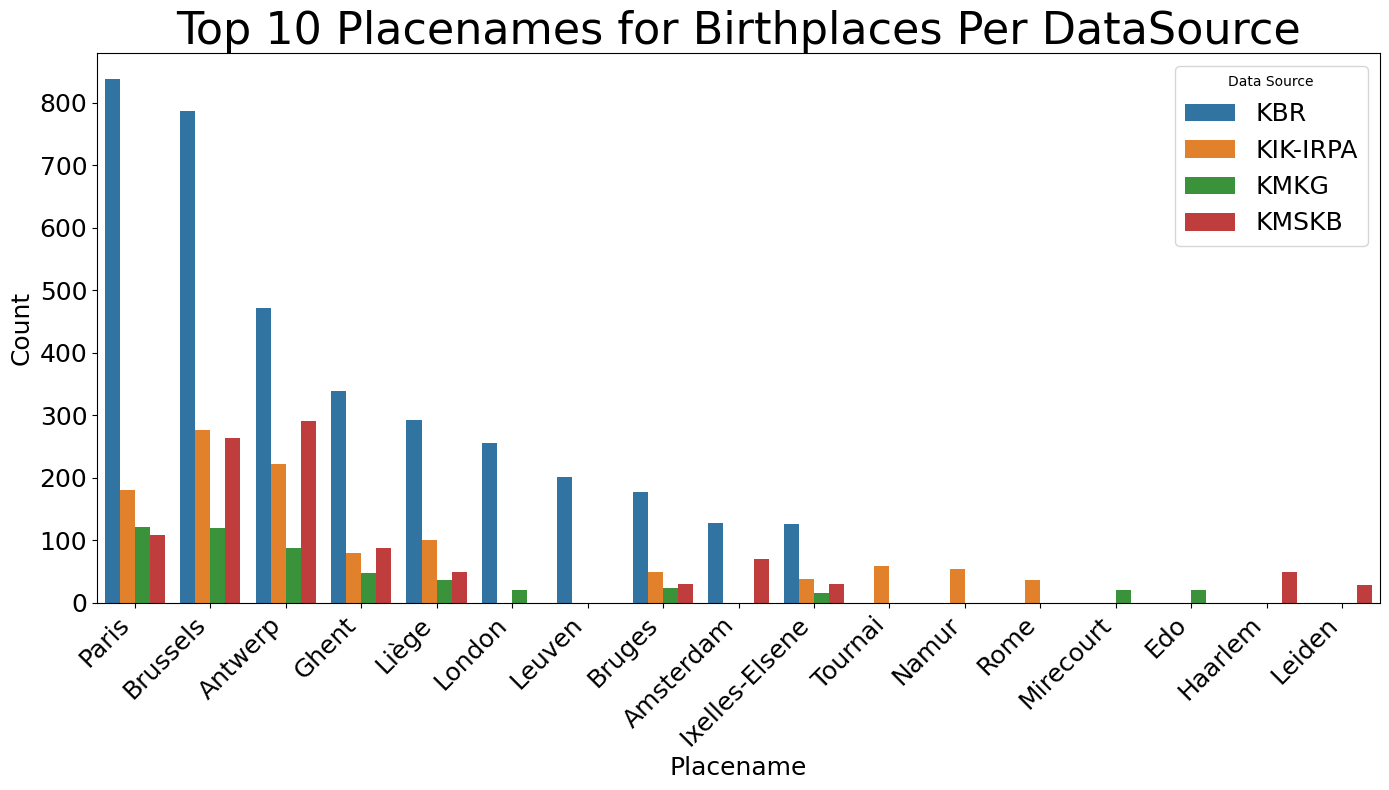

In [143]:
# Create a grouped bar chart
plt.figure(figsize=(14, 8))
sns.barplot(data=top_10_birthplaces, x='placename', y='count', hue='dataSource', dodge=True)

# Customize plot
plt.title('Top 10 Placenames for Birthplaces Per DataSource', fontsize=32)
plt.xlabel('Placename', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.xticks(rotation=45, ha='right', fontsize=18)  # Enlarged tick labels
plt.yticks(rotation=0, fontsize=18)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Data Source', fontsize=18, loc='upper right')
plt.tight_layout()

plt.savefig('top10-birth-places.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.savefig('top10-birth-places.png', format='png', dpi=300, bbox_inches='tight')

plt.show()

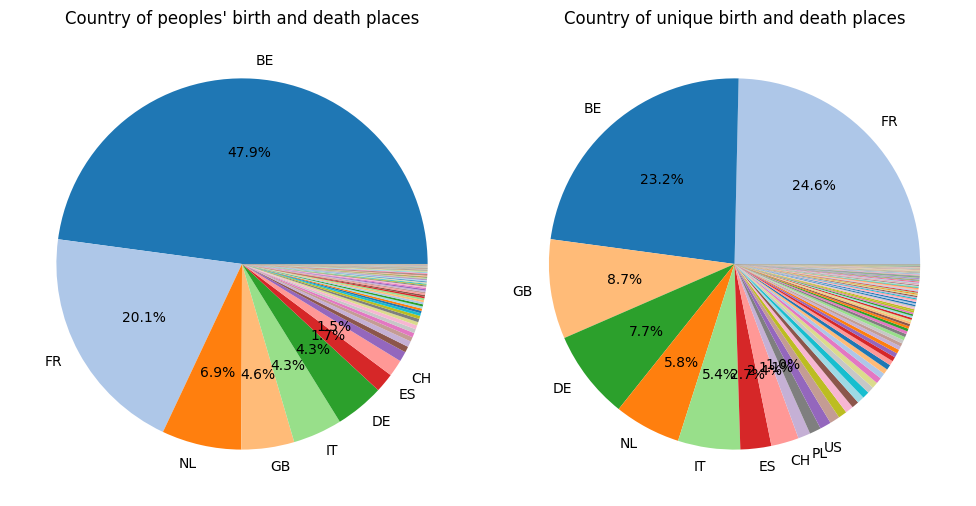

In [144]:

# Compute counts
country_counts_size = placeDf.groupby('countryCode')['placename'].size().sort_values(ascending=False)
country_counts_nunique = placeDf.groupby('countryCode')['placename'].nunique().sort_values(ascending=False)

# Combine and sum counts to get a frequency-based ranking
combined_counts = country_counts_size.add(country_counts_nunique, fill_value=0).sort_values(ascending=False)

# Get countries sorted by overall frequency
sorted_countries = combined_counts.index.tolist()

# Assign colors: Give unique colors to most frequent countries, reuse for less common ones
num_colors = min(len(sorted_countries), 20)  # Limit distinct colors to top 20
palette = sns.color_palette("tab20", num_colors)  # Use "tab20" for distinct colors
color_map = {country: palette[i % num_colors] for i, country in enumerate(sorted_countries)}

# Define function to filter small percentages
def autopct_format(pct):
    return f'{pct:.1f}%' if pct > 1 else ''

# Plot first pie chart (size-based)
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)  # First subplot
plt.title("Country of peoples' birth and death places")
plt.pie(
    country_counts_size, 
    labels=[label if pct > 1 else '' for label, pct in zip(country_counts_size.index, (country_counts_size / country_counts_size.sum()) * 100)],
    autopct=autopct_format, 
    colors=[color_map[country] for country in country_counts_size.index]
)

# Plot second pie chart (nunique-based)
plt.subplot(1, 2, 2)  # Second subplot
plt.title('Country of unique birth and death places')
plt.pie(
    country_counts_nunique, 
    labels=[label if pct > 1 else '' for label, pct in zip(country_counts_nunique.index, (country_counts_nunique / country_counts_nunique.sum()) * 100)],
    autopct=autopct_format, 
    colors=[color_map[country] for country in country_counts_nunique.index]
)

plt.tight_layout()
plt.savefig('placename-by-country.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.savefig('placename-by-country.png', format='png', dpi=300, bbox_inches='tight')
plt.show()


In [145]:
# Aggregate counts by variableType and countryCode
place_type_counts = (placeDf.groupby(['variableType', 'countryCode'])
                     .size()
                     .unstack(level=0)
                     .fillna(0)
                     .astype(int))

# Add a total column and get the top 10 countries
place_type_counts['total'] = place_type_counts.sum(axis=1)
top_10_countries = place_type_counts.nlargest(10, 'total')
top_10_countries

variableType  birthPlace  deathPlace  total
countryCode                                
BE                  9503        5421  14924
FR                  3264        3011   6275
NL                  1306         857   2163
GB                   771         663   1434
IT                   674         665   1339
DE                   807         525   1332
ES                   298         226    524
CH                   247         208    455
AT                   139         133    272
JP                   106          55    161

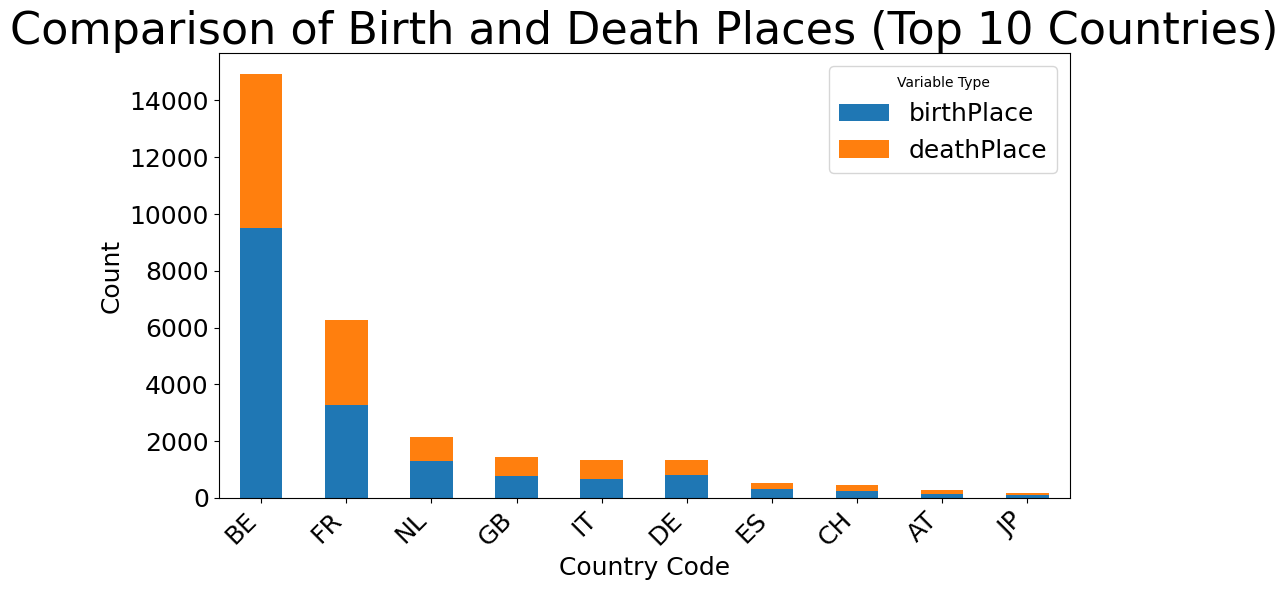

In [146]:

# Plot the top 10 countries
top_10_countries.drop(columns='total').plot(kind='bar', stacked=True, figsize=(10, 6), color=['#1f77b4', '#ff7f0e'])
plt.title('Comparison of Birth and Death Places (Top 10 Countries)', fontsize=32)
plt.xlabel('Country Code', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.legend(title='Variable Type', fontsize=18)
plt.xticks(rotation=45, ha='right', fontsize=18)  # Enlarged tick labels
plt.yticks(rotation=0, fontsize=18)
plt.tight_layout()

plt.savefig('top10-birth-death-places.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.savefig('top10-birth-death-places.png', format='png', dpi=300, bbox_inches='tight')

plt.show()

In [147]:
top_10_deathplaces = notebook_utils.getTop10Place(placeDf, 'deathPlace')

In [148]:
top_10_deathplaces

dataSource       placename  count
1040        KBR           Paris   1121
227         KBR        Brussels    637
803         KBR          London    271
46          KBR         Antwerp    213
528         KBR           Ghent    147
797         KBR           Liège    140
660         KBR  Ixelles-Elsene    105
33          KBR       Amsterdam    104
226         KBR          Bruges     97
1363        KBR           Uccle     97
1876   KIK-IRPA           Paris    311
1616   KIK-IRPA        Brussels    279
1555   KIK-IRPA         Antwerp    160
1908   KIK-IRPA            Rome    101
1782   KIK-IRPA           Liège     73
1842   KIK-IRPA           Namur     53
1547   KIK-IRPA       Amsterdam     49
1739   KIK-IRPA  Ixelles-Elsene     49
1703   KIK-IRPA           Ghent     47
1935   KIK-IRPA      Schaarbeek     43
2273       KMKG           Paris    162
2079       KMKG        Brussels    134
2050       KMKG         Antwerp     81
2153       KMKG           Ghent     35
2185       KMKG  Ixelles-Elsene     32
2219       KMKG          London     31
2328       KMKG           Uccle     23
2217       KMKG           Liège     21
2129       KMKG             Edo     20
2287       KMKG            Rome     20
2415      KMSKB        Brussels    274
2615      KMSKB           Paris    240
2373      KMSKB         Antwerp    229
2366      KMSKB       Amsterdam    107
2629      KMSKB            Rome     82
2513      KMSKB  Ixelles-Elsene     63
2488      KMSKB           Ghent     52
2496      KMSKB         Haarlem     44
2679      KMSKB           Uccle     44
2669      KMSKB       The Hague     39

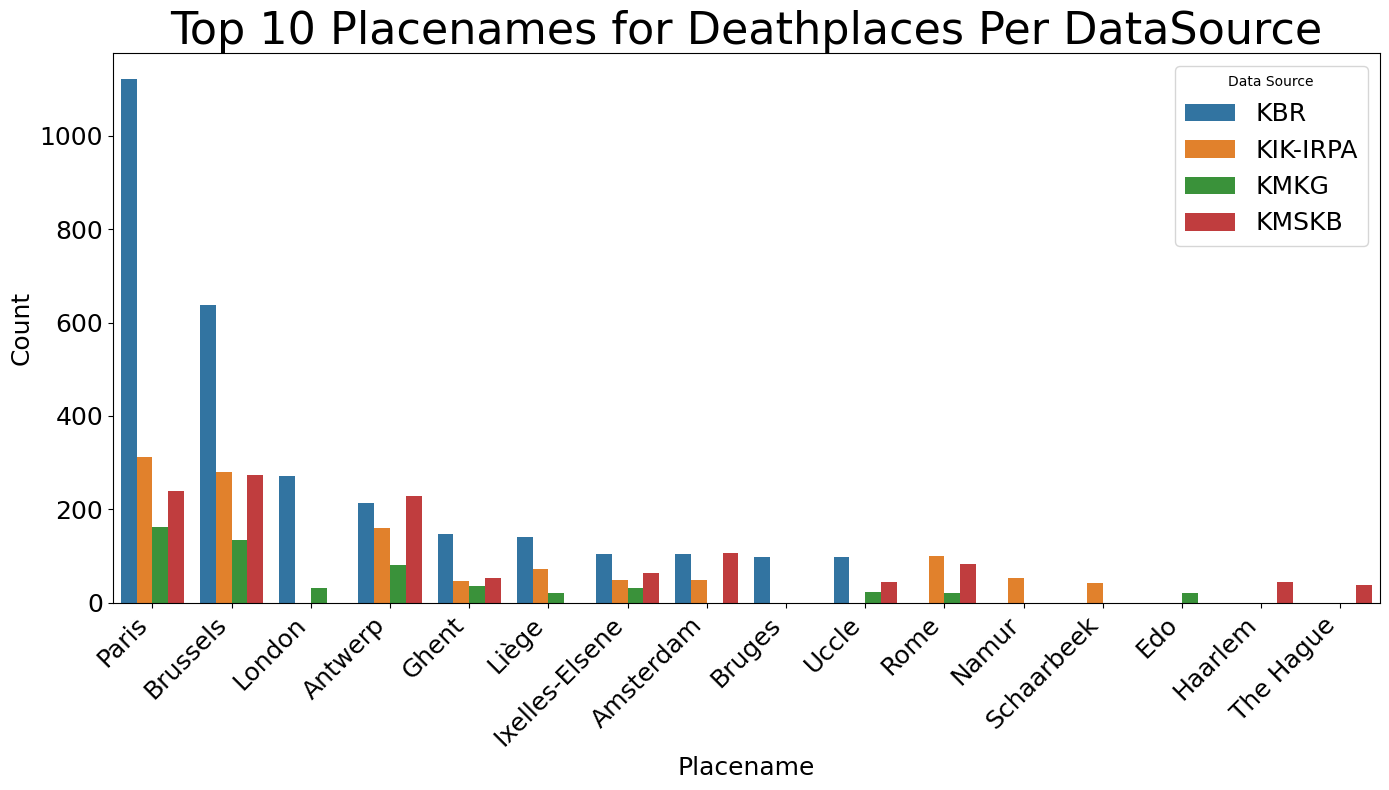

In [149]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a grouped bar chart
plt.figure(figsize=(14, 8))
sns.barplot(data=top_10_deathplaces, x='placename', y='count', hue='dataSource', dodge=True)

# Customize plot
plt.title('Top 10 Placenames for Deathplaces Per DataSource', fontsize=32)
plt.xlabel('Placename', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.xticks(rotation=45, ha='right', fontsize=18)  # Enlarged tick labels
plt.yticks(rotation=0, fontsize=18)
plt.legend(title='Data Source', fontsize=18, loc='upper right')
plt.tight_layout()

# Save the figure
plt.savefig('top10-death-places.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.savefig('top10-death-places.png', format='png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

## datafield stats for records without standard identifiers
We count how often data fields are filled in for records that do *not* have ISNI or VIAF identifiers.

In [150]:
statsDf.loc[statsDf['isni'].isna() & statsDf['viaf'].isna()].explode('birthDateEDTF').groupby(['dataSource']).count()

isni    name  alternateNames  birthDate-original  birthDate  \
dataSource                                                                
KBR            0  424443           12892              424453       2950   
KIK-IRPA       0   81191            6024               81191      15759   
KMKG           0    5790             479                6321        763   
KMSKB          0    3470               0                3471       2858   

            deathDate-original  deathDate  birthPlace-original  birthPlace  \
dataSource                                                                   
KBR                     424453       2464               424453        3419   
KIK-IRPA                 81191      13185                81191        2719   
KMKG                      6321        661                    0         873   
KMSKB                     3471       2511                    0        2694   

            deathPlace-original  ...  deathDate_value  deathDate_rule  \
dataSource                       ...                                    
KBR                      424453  ...            55598            2464   
KIK-IRPA                  81191  ...            13185           13185   
KMKG                          0  ...              661             661   
KMSKB                         0  ...             2511            2511   

            birthDate100dEDTF  birthDate100dType  birthDate100dEDTFRule  \
dataSource                                                                
KBR                     59948              91796                  59948   
KIK-IRPA                    0                  0                      0   
KMKG                        0                  0                      0   
KMSKB                       0                  0                      0   

            deathDate100dEDTF  deathDate100dType  deathDate100dEDTFRule  \
dataSource                                                                
KBR                     53134              91796                  53134   
KIK-IRPA                    0                  0                      0   
KMKG                        0                  0                      0   
KMSKB                       0                  0                      0   

            birthDateEDTF  deathDateEDTF  
dataSource                                
KBR                 62898          55598  
KIK-IRPA            15759          13185  
KMKG                  763            661  
KMSKB                2858           2511  

[4 rows x 30 columns]

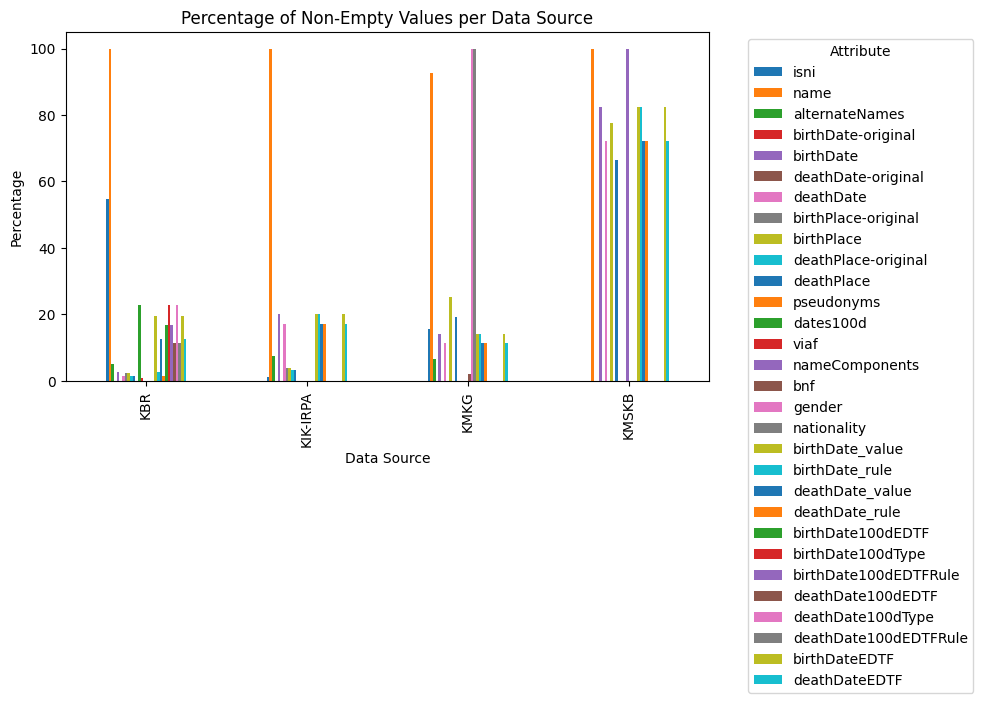

In [151]:
# Specify the columns to exclude from visualization
exclude_columns = ['dataSource']

# Group by 'dataSource' and apply the non_empty_percentage function to each column except the excluded ones
percentages = statsDf.groupby('dataSource').apply(lambda group: group.drop(columns=exclude_columns).apply(utils.non_empty_percentage))

# Plot the stacked bars with the same color palette
percentages.plot.bar()

# Add labels and title
plt.title('Percentage of Non-Empty Values per Data Source')
plt.xlabel('Data Source')
plt.ylabel('Percentage')

# Add legend
plt.legend(title='Attribute', bbox_to_anchor=(1.05, 1), loc='upper left')

# Set the size of the current figure
plt.gcf().set_size_inches(10, 6)  # Width: 10 inches, Height: 6 inches

# Show the plot
plt.tight_layout()
plt.show()

In [152]:
percentages

isni        name  alternateNames  birthDate-original  \
dataSource                                                              
KBR         54.664677   99.998936        5.022139                 0.0   
KIK-IRPA     1.057776  100.000000        7.583568                 0.0   
KMKG        15.528531   92.770279        6.521449                 0.0   
KMSKB        0.000000   99.971190        0.000000                 0.0   

            birthDate  deathDate-original  deathDate  birthPlace-original  \
dataSource                                                                  
KBR          2.538411                 0.0   1.451448             2.249888   
KIK-IRPA    20.223254                 0.0  16.998745             3.777770   
KMKG        14.111987                 0.0  11.359081             0.000000   
KMSKB       82.339383                 0.0  72.342264             0.000000   

            birthPlace  deathPlace-original  ...  deathDate_value  \
dataSource                                   ...                    
KBR           2.249888             1.306335  ...        12.692269   
KIK-IRPA      3.777770             3.296409  ...        16.998745   
KMKG         25.203795             0.000000  ...        11.359081   
KMSKB        77.614520             0.000000  ...        72.342264   

            deathDate_rule  birthDate100dEDTF  birthDate100dType  \
dataSource                                                         
KBR               1.451448           16.91033          22.945174   
KIK-IRPA         16.998745            0.00000           0.000000   
KMKG             11.359081            0.00000           0.000000   
KMSKB            72.342264            0.00000           0.000000   

            birthDate100dEDTFRule  deathDate100dEDTF  deathDate100dType  \
dataSource                                                                
KBR                      16.91033          11.240821          22.945174   
KIK-IRPA                  0.00000           0.000000           0.000000   
KMKG                      0.00000           0.000000           0.000000   
KMSKB                     0.00000           0.000000           0.000000   

            deathDate100dEDTFRule  birthDateEDTF  deathDateEDTF  
dataSource                                                       
KBR                     11.240821      19.448741      12.692269  
KIK-IRPA                 0.000000      20.223254      16.998745  
KMKG                     0.000000      14.111987      11.359081  
KMSKB                    0.000000      82.339383      72.342264  

[4 rows x 30 columns]

In [153]:
#df = pd.read_csv('kik-irpa/kik-irpa-data.csv', converters={'name':jsonParser}, dtype=str, keep_default_na=False)

In [154]:
#df.name = df.name.tolist()

In [155]:
statsDf[statsDf.index == "kik-irpa|3"]['name'][0][0]

'Flammarion'

## Data quality categories

In [156]:
mainDfCategories = statsDf.copy()
placeDfCategories = placeDf.copy()

birthDateDfCategories = birthDateDf
deathDateDfCategories = deathDateDf

In [157]:
placeDfCategories[(placeDfCategories["dataSource"] == "KBR") & (placeDfCategories["variableType"] == "birthPlace")]

geonameID      placename countryCode dataSource variableType
autID                                                                     
kbr|21392424    3194828         Mostar          BA        KBR   birthPlace
kbr|21493900    2988507          Paris          FR        KBR   birthPlace
kbr|21411654    2147714    Sydney City          AU        KBR   birthPlace
kbr|21393425    2643567   Loughborough          GB        KBR   birthPlace
kbr|21411397    2643743         London          GB        KBR   birthPlace
...                 ...            ...         ...        ...          ...
kbr|14370297    2988507          Paris          FR        KBR   birthPlace
kbr|14625939    2803138        Antwerp          BE        KBR   birthPlace
kbr|14625939    2803138        Antwerp          BE        KBR   birthPlace
kbr|21427318    2788765  Pont-à-Celles          BE        KBR   birthPlace
kbr|21427318    2788765  Pont-à-Celles          BE        KBR   birthPlace

[12490 rows x 5 columns]

In [158]:
birthPlaceDfCategories = placeDfCategories[placeDfCategories['variableType'] == 'birthPlace'].copy()
deathPlaceDfCategories = placeDfCategories[placeDfCategories['variableType'] == 'deathPlace'].copy()

birthPlaceDfCategories['geonameID'] = birthPlaceDfCategories['geonameID'].astype(str)
deathPlaceDfCategories['geonameID'] = deathPlaceDfCategories['geonameID'].astype(str)
#df.merge(placeDf, how='left', left_on='autID', right_on='autID')

In [159]:
# all dataframes that we will merge soon (main dataframe with enriched 1:n dataframes)
allInfoDataframes = [mainDfCategories, birthPlaceDfCategories, deathPlaceDfCategories, 
                     birthDateDfCategories, deathDateDfCategories]


In [160]:
birthPlaceDfCategories[birthPlaceDfCategories.index == "kbr|21392424"]

geonameID placename countryCode dataSource variableType
autID                                                               
kbr|21392424   3194828    Mostar          BA        KBR   birthPlace

In [161]:
from functools import reduce

# Define which columns to keep from each dataframe
columns_to_keep = {
    "birthPlaceDf": ["geonameIDBirth", "countryCodeBirth", "placenameBirth"],
    "deathPlaceDf": ["geonameIDDeath", "countryCodeDeath", "placenameDeath"],
    "birthDate": ["birthDateEDTF"],
    "deathDate": ["deathDateEDTF"]
}

columns_rename = {
    "birthPlaceDf": {'geonameID': 'geonameIDBirth', 'countryCode': 'countryCodeBirth', 'placename': 'placenameBirth'},
    "deathPlaceDf": {'geonameID': 'geonameIDDeath', 'countryCode': 'countryCodeDeath', 'placename': 'placenameDeath'}
}

# Function to preprocess a dataframe before merging
def prepare_df(df, keep_columns, columns_rename=None):
    preparedDf = df.copy()
    if columns_rename:
        preparedDf = preparedDf.rename(columns=columns_rename)
    """Select only the needed columns and aggregate duplicates"""
    preparedDf = preparedDf[keep_columns]  # Keep only relevant columns
    #if len(keep_columns) > 2:  # If more than just autID and one column, aggregate
    #    preparedDf = preparedDf.groupby("autID").agg(lambda x: "; ".join(map(str, x))).reset_index()
    return preparedDf

# Prepare all additional dataframes
birthPlaceDfForMerge = prepare_df(birthPlaceDfCategories, columns_to_keep["birthPlaceDf"], columns_rename["birthPlaceDf"])
deathPlaceDfForMerge = prepare_df(deathPlaceDfCategories, columns_to_keep["deathPlaceDf"], columns_rename["deathPlaceDf"])

birthDf = prepare_df(birthDateDfCategories, columns_to_keep["birthDate"])
deathDf = prepare_df(deathDateDfCategories, columns_to_keep["deathDate"])

# Merge step by step
allInfoDf = mainDfCategories.copy()  # Start with the main df
allInfoDf = allInfoDf.rename(columns={'birthDateEDTF': 'birthDate', 'deathDateEDTF': 'deathDate'})
for right_df in [birthPlaceDfForMerge, deathPlaceDfForMerge, birthDf, deathDf]:
    allInfoDf = allInfoDf.merge(right_df, left_index=True, right_index=True, how="left")

In [162]:
allInfoDf.index[allInfoDf.index.duplicated()]

Index(['kbr|10038486', 'kbr|10038567', 'kbr|10038567', 'kbr|10038567',
       'kbr|10039040', 'kbr|10039040', 'kbr|10039040', 'kbr|10039073',
       'kbr|10039073', 'kbr|10039073',
       ...
       'kmskb|509/2843', 'kmskb|509/3075', 'kmskb|509/318', 'kmskb|509/3333',
       'kmskb|509/366', 'kmskb|509/3729', 'kmskb|509/593', 'kmskb|509/728',
       'kmskb|509/740', 'kmskb|509/758'],
      dtype='object', name='autID', length=3049)

In [163]:
#allInfoDf = allInfoDf.reset_index()[allInfoDf.reset_index().astype(str).duplicated()].set_index('autID')
#allInfoDf = allInfoDf.reset_index().astype(str).drop_duplicates().set_index('autID')
realDuplicatesMask = allInfoDf.reset_index().astype(str).duplicated()

allInfoDf = allInfoDf.reset_index()[~realDuplicatesMask].copy().set_index('autID')

In [164]:
allInfoDf.index[allInfoDf.index.duplicated()]

Index(['kbr|14113992', 'kbr|21239831', 'kbr|21637615', 'kbr|22153450',
       'kmskb|509/1326', 'kmskb|509/1326', 'kmskb|509/1326', 'kmskb|509/1460',
       'kmskb|509/1553', 'kmskb|509/1580', 'kmskb|509/1660', 'kmskb|509/2514',
       'kmskb|509/2843', 'kmskb|509/3075', 'kmskb|509/318', 'kmskb|509/3333',
       'kmskb|509/366', 'kmskb|509/3729', 'kmskb|509/593', 'kmskb|509/728',
       'kmskb|509/740', 'kmskb|509/758'],
      dtype='object', name='autID')

In [165]:
# example of a case where real duplicates were removed and a single record remained
allInfoDf[allInfoDf.index == 'kbr|10038567']

isni          name  \
autID                                               
kbr|10038567  [0000 0003 8204 8376]  [Leopold II]   

                                                 alternateNames  \
autID                                                             
kbr|10038567  [Brabant (Léopold; duc de), II Leopold, II. Li...   

             birthDate-original  \
autID                             
kbr|10038567                      

                                                      birthDate  \
autID                                                             
kbr|10038567  [{'birthDate': '1835-04-09', 'rule': 'simplePa...   

             deathDate-original  \
autID                             
kbr|10038567                      

                                                      deathDate  \
autID                                                             
kbr|10038567  [{'deathDate': '1909-12-17', 'rule': 'simplePa...   

                                birthPlace-original  \
autID                                                 
kbr|10038567  ['Bruxelles (Belgique)', 'Bruxelles']   

                                     birthPlace  \
autID                                             
kbr|10038567  [Bruxelles (Belgique), Bruxelles]   

                          deathPlace-original  ...   birthDate   deathDate  \
autID                                          ...                           
kbr|10038567  ['Laeken (Belgique)', 'Laeken']  ...  1835-04-09  1909-12-17   

             geonameIDBirth countryCodeBirth placenameBirth geonameIDDeath  \
autID                                                                        
kbr|10038567        2800866               BE       Brussels        2793656   

             countryCodeDeath placenameDeath birthDateEDTF deathDateEDTF  
autID                                                                     
kbr|10038567               BE          Laken    1835-04-09    1909-12-17  

[1 rows x 39 columns]

In [166]:
# example of a case where the combination of index and columns results in a duplicate autID, but different rows
allInfoDf[allInfoDf.index == 'kmskb|509/366']

isni                     name alternateNames birthDate-original  \
autID                                                                           
kmskb|509/366  NaN  [VAN DER HAAGEN, Joris]            NaN                      
kmskb|509/366  NaN  [VAN DER HAAGEN, Joris]            NaN                      

                                                       birthDate  \
autID                                                              
kmskb|509/366  [{'birthDate': '1615~', 'rule': 'circa_year', ...   
kmskb|509/366  [{'birthDate': '1615~', 'rule': 'circa_year', ...   

              deathDate-original  \
autID                              
kmskb|509/366                      
kmskb|509/366                      

                                                       deathDate  \
autID                                                              
kmskb|509/366  [{'deathDate': '1669', 'rule': 'simplePattern'...   
kmskb|509/366  [{'deathDate': '1669', 'rule': 'simplePattern'...   

              birthPlace-original  \
autID                               
kmskb|509/366                 NaN   
kmskb|509/366                 NaN   

                                                      birthPlace  \
autID                                                              
kmskb|509/366  [Dordrecht (Nederland) [dut], Arnhem (Nederlan...   
kmskb|509/366  [Dordrecht (Nederland) [dut], Arnhem (Nederlan...   

              deathPlace-original  ... birthDate deathDate geonameIDBirth  \
autID                              ...                                      
kmskb|509/366                 NaN  ...     1615~      1669        2756669   
kmskb|509/366                 NaN  ...     1615~      1669        2759661   

              countryCodeBirth placenameBirth geonameIDDeath countryCodeDeath  \
autID                                                                           
kmskb|509/366               NL      Dordrecht        2747373               NL   
kmskb|509/366               NL         Arnhem        2747373               NL   

              placenameDeath birthDateEDTF deathDateEDTF  
autID                                                     
kmskb|509/366      The Hague         1615~          1669  
kmskb|509/366      The Hague         1615~          1669  

[2 rows x 39 columns]

In [167]:
duplicates_indices = allInfoDf.index[allInfoDf.index.duplicated()].unique()
allInfoDf[allInfoDf.index.isin(duplicates_indices)].to_csv(duplicateAutIDofMainDfCategories)
allInfoDf = allInfoDf[~allInfoDf.index.isin(duplicates_indices)]

In [168]:
# column with lists is now a string after I had to cast everything for duplicate deletion
#allInfoDf[allInfoDf.index == 'kbr|10038105']['name'][0][0]

In [169]:
mainDfCategories['birthDateEDTF'].isna().value_counts()

birthDateEDTF
True     829652
False    203319
Name: count, dtype: int64

In [170]:
allInfoDf['birthDateEDTF'].isna().value_counts()

birthDateEDTF
True     829652
False    203299
Name: count, dtype: int64

In [171]:
allInfoDf[allInfoDf.index == 'kmskb|509/2557']

isni                 name alternateNames birthDate-original  \
autID                                                                        
kmskb|509/2557  NaN  van Imschoot, Jules            NaN                      

                                                        birthDate  \
autID                                                               
kmskb|509/2557  [{'birthDate': '1821', 'rule': 'simplePattern'...   

               deathDate-original  \
autID                               
kmskb|509/2557                      

                                                        deathDate  \
autID                                                               
kmskb|509/2557  [{'deathDate': '1884', 'rule': 'simplePattern'...   

               birthPlace-original birthPlace deathPlace-original  ...  \
autID                                                              ...   
kmskb|509/2557                 NaN        NaN                 NaN  ...   

               birthDate deathDate geonameIDBirth countryCodeBirth  \
autID                                                                
kmskb|509/2557      1821      1884            NaN              NaN   

               placenameBirth geonameIDDeath countryCodeDeath placenameDeath  \
autID                                                                          
kmskb|509/2557            NaN            NaN              NaN            NaN   

               birthDateEDTF deathDateEDTF  
autID                                       
kmskb|509/2557          1821          1884  

[1 rows x 39 columns]

In [172]:
birthPlaceDfForMerge[birthPlaceDfForMerge['geonameIDBirth'].notna()]

geonameIDBirth countryCodeBirth  placenameBirth
autID                                                          
kik-irpa|69            2795011               BE  Ixelles-Elsene
kik-irpa|115           2791964               BE         Maaseik
kik-irpa|240           2988507               FR           Paris
kik-irpa|248           3024090               FR       Commentry
kik-irpa|347           2785470               BE          Tienen
...                        ...              ...             ...
kmkg|kmkg|7199         1858088               JP          Kurume
kmkg|kmkg|74441        2911298               DE         Hamburg
kmkg|kmkg|2491         3164039               IT         Viterbo
kmkg|kmkg|2578         2747561               NL       Schimmert
kmkg|kmkg|5750          723082               SK           Ždiar

[18762 rows x 3 columns]

In [173]:
# debugging merging in case something does not work as expected after changes
#
#testDf = mainDfCategories.merge(birthPlaceDfForMerge, left_on="autID", right_on="autID", how="left")
#testDf[testDf["autID"] == 'KBR|21392424']
#birthPlaceDfCategories[birthPlaceDfCategories["autID"] == "KBR|21392424"]
#testDf[testDf['autID'].str.startswith('KBR')]

In [174]:
allInfoDf.columns

Index(['isni', 'name', 'alternateNames', 'birthDate-original', 'birthDate',
       'deathDate-original', 'deathDate', 'birthPlace-original', 'birthPlace',
       'deathPlace-original', 'deathPlace', 'dataSource', 'pseudonyms',
       'dates100d', 'viaf', 'nameComponents', 'bnf', 'gender', 'nationality',
       'birthDate_value', 'birthDate_rule', 'deathDate_value',
       'deathDate_rule', 'birthDate100dEDTF', 'birthDate100dType',
       'birthDate100dEDTFRule', 'deathDate100dEDTF', 'deathDate100dType',
       'deathDate100dEDTFRule', 'birthDate', 'deathDate', 'geonameIDBirth',
       'countryCodeBirth', 'placenameBirth', 'geonameIDDeath',
       'countryCodeDeath', 'placenameDeath', 'birthDateEDTF', 'deathDateEDTF'],
      dtype='object')

In [175]:
allInfoDfCategories = allInfoDf[['name', 'alternateNames', 'isni', 'viaf',
                                  'geonameIDBirth', 'geonameIDDeath', 'birthPlace', 'deathPlace',
                                  'placenameBirth', 'placenameDeath', 'dataSource',
                                  'birthDateEDTF', 'deathDateEDTF', 'countryCodeBirth', 'countryCodeDeath']].copy()  # Add .copy() to avoid SettingWithCopyWarning

#allInfoDfCategories['name'] = allInfoDfCategories['name'].apply(nanToList)
#allInfoDfCategories['alternateNames'] = allInfoDfCategories['alternateNames'].apply(nanToList)


In [176]:
allInfoDfCategories.shape[0]

1032951

In [177]:
# remove duplicates
#allInfoDfCategories = allInfoDfCategories.loc[allInfoDfCategories.astype(str).drop_duplicates().index]

In [178]:
allInfoDfCategories['birthDateEDTF'].isna().value_counts()

birthDateEDTF
True     829652
False    203299
Name: count, dtype: int64

In [179]:
# test duplicate removal for one specific instance
allInfoDfCategories[allInfoDfCategories.index =='kmskb|509/2557']

name alternateNames isni viaf geonameIDBirth  \
autID                                                                         
kmskb|509/2557  van Imschoot, Jules            NaN  NaN  NaN            NaN   

               geonameIDDeath birthPlace deathPlace placenameBirth  \
autID                                                                
kmskb|509/2557            NaN        NaN        NaN            NaN   

               placenameDeath dataSource birthDateEDTF deathDateEDTF  \
autID                                                                  
kmskb|509/2557            NaN      KMSKB          1821          1884   

               countryCodeBirth countryCodeDeath  
autID                                             
kmskb|509/2557              NaN              NaN

In [180]:
pd.set_option('display.max_colwidth', 500)
allInfoDf[allInfoDf.index =='kmskb|509/2557']

isni                 name alternateNames birthDate-original  \
autID                                                                        
kmskb|509/2557  NaN  van Imschoot, Jules            NaN                      

                                                                                                                                                                   birthDate  \
autID                                                                                                                                                                          
kmskb|509/2557  [{'birthDate': '1821', 'rule': 'simplePattern', 'birthDate-original': '1821'}, {'birthDate': '1821', 'rule': 'simplePattern', 'birthDate-original': '1821'}]   

               deathDate-original  \
autID                               
kmskb|509/2557                      

                                                                                                                                                                   deathDate  \
autID                                                                                                                                                                          
kmskb|509/2557  [{'deathDate': '1884', 'rule': 'simplePattern', 'deathDate-original': '1884'}, {'deathDate': '1884', 'rule': 'simplePattern', 'deathDate-original': '1884'}]   

               birthPlace-original birthPlace deathPlace-original  ...  \
autID                                                              ...   
kmskb|509/2557                 NaN        NaN                 NaN  ...   

               birthDate deathDate geonameIDBirth countryCodeBirth  \
autID                                                                
kmskb|509/2557      1821      1884            NaN              NaN   

               placenameBirth geonameIDDeath countryCodeDeath placenameDeath  \
autID                                                                          
kmskb|509/2557            NaN            NaN              NaN            NaN   

               birthDateEDTF deathDateEDTF  
autID                                       
kmskb|509/2557          1821          1884  

[1 rows x 39 columns]

In [181]:
allInfoDfCategories[allInfoDfCategories.index == 'kmskb|509/875']['birthDateEDTF']

autID
kmskb|509/875    [1460,1470]
Name: birthDateEDTF, dtype: object

In [182]:
#allInfoDfCategories[allInfoDfCategories['birthDateEDTF']

In [183]:
# define named filters (masks) to have a more readable classification into quality categories afterwards

atLeastOneStandardIdentifier = (allInfoDfCategories["isni"].notna() | (allInfoDfCategories["viaf"]).notna())
noStandardIdentifier = allInfoDfCategories["isni"].isna() & (allInfoDfCategories["viaf"]).isna()
atLeastOneName = (allInfoDfCategories["name"].notna() | allInfoDfCategories["alternateNames"].notna())

hasBirthPlace = allInfoDfCategories["birthPlace"].notna()
hasDeathPlace = allInfoDfCategories["deathPlace"].notna()
hasGeonameBirthPlace = allInfoDfCategories["geonameIDBirth"].notna()
hasGeonameDeathPlace = allInfoDfCategories["geonameIDDeath"].notna()
hasBirthDate = allInfoDfCategories["birthDateEDTF"].notna()
hasDeathDate = allInfoDfCategories["deathDateEDTF"].notna()

hasPlaces = hasBirthPlace & hasDeathPlace
hasGeonamePlaces = hasGeonameBirthPlace & hasGeonameDeathPlace
hasDates = hasBirthDate & hasDeathDate

noName = (allInfoDfCategories["name"].isna() & allInfoDfCategories["alternateNames"].isna())
noBirthPlace = ~hasBirthPlace
noDeathPlace = ~hasDeathPlace
noGeonameBirthPlace = ~hasGeonameBirthPlace
noGeonameDeathPlace = ~hasGeonameDeathPlace
noBirthDate = ~hasBirthDate
noDeathDate = ~hasDeathDate

noDates = noBirthDate & noDeathDate
noPlaces = noBirthPlace & noDeathPlace
noGeonamePlaces = noGeonameBirthPlace & noGeonameDeathPlace
noNames = (allInfoDfCategories["name"].isna() & allInfoDfCategories["alternateNames"].isna())

In [184]:
# External identifier and complete standardized metadata
mbq1Mask = atLeastOneStandardIdentifier & atLeastOneName & hasPlaces & hasGeonamePlaces & hasDates

# External identifier but incomplete metadata
mbq2Mask = atLeastOneStandardIdentifier & \
  (noName | noBirthDate | noDeathDate | noBirthPlace | noDeathPlace | noGeonameBirthPlace | noGeonameDeathPlace)

# Complete standardized metadata but missing external identifier
mbq3Mask = noStandardIdentifier & atLeastOneName & hasPlaces & hasGeonamePlaces & hasDates

# Unstandardized place
mbq4Mask = (hasBirthPlace & noGeonameBirthPlace) | (hasDeathPlace & noGeonameDeathPlace)

# Date but no place and no external identifier
mbq5Mask = noStandardIdentifier & (hasBirthDate & noBirthPlace & noGeonameBirthPlace) | (hasDeathDate & noDeathPlace & noGeonameDeathPlace)

# Place but no date and no external identifier
mbq6Mask = noStandardIdentifier & (hasBirthPlace & hasGeonameBirthPlace & noBirthDate) | (hasDeathPlace & hasGeonameDeathPlace & noDeathDate)

# Missing metadata and no external identifier
mbq7Mask = noStandardIdentifier & atLeastOneName & \
  (noBirthDate | noDeathDate | noBirthPlace | noDeathPlace | noGeonameBirthPlace | noGeonameDeathPlace)

# Only  name, no metadata and no external identifier
mbq8Mask = atLeastOneName & noStandardIdentifier & noPlaces & noGeonamePlaces & noDates

# Not even a name
mbq9Mask = noStandardIdentifier & noNames



In [185]:
qualityMasks = [
    (mbq1Mask, 'mbq1'), 
    (mbq2Mask, 'mbq2'), 
    (mbq3Mask, 'mbq3'), 
    (mbq7Mask, 'mbq7'), # mbq7 should be applied before mbq5 and mbq6
    (mbq5Mask, 'mbq5'), 
    (mbq6Mask, 'mbq6'),
    (mbq8Mask, 'mbq8'),
    (mbq9Mask, 'mbq9'),
    (mbq4Mask, 'mbq4')] # mbq4 needs to be applied last

In [186]:
allInfoDfCategories.shape[0]

1032951

In [187]:
qualityColumn = "qualityCategory"

# initialize column
allInfoDfCategories[qualityColumn] = np.nan

for mask, category in qualityMasks:
    #allInfoDfCategories.loc[mask & allInfoDfCategories[qualityColumn].isna(), qualityColumn] = category  # Only assign if still NaN
    allInfoDfCategories.loc[mask, qualityColumn] = category



In [188]:
allInfoDfCategories[qualityColumn].value_counts(dropna=False)

qualityCategory
mbq2    446888
mbq8    407057
mbq5    154392
mbq4     15228
mbq1      4233
mbq3      4140
mbq7       831
mbq6       116
mbq9        66
Name: count, dtype: int64

In [189]:
mainDfCategories[mainDfCategories.index == 'kbr|14143868']

isni name alternateNames birthDate-original birthDate  \
autID                                                                
kbr|14143868  NaN  NaN            NaN                          NaN   

             deathDate-original deathDate birthPlace-original birthPlace  \
autID                                                                      
kbr|14143868                          NaN                            NaN   

             deathPlace-original  ... deathDate_value deathDate_rule  \
autID                             ...                                  
kbr|14143868                      ...             NaN            NaN   

             birthDate100dEDTF birthDate100dType birthDate100dEDTFRule  \
autID                                                                    
kbr|14143868               NaN               NaN                   NaN   

             deathDate100dEDTF deathDate100dType deathDate100dEDTFRule  \
autID                                                                    
kbr|14143868               NaN               NaN                   NaN   

             birthDateEDTF deathDateEDTF  
autID                                     
kbr|14143868           NaN           NaN  

[1 rows x 31 columns]

In [190]:
allInfoDfCategories[allInfoDfCategories['qualityCategory'].isna()][['name', 'alternateNames', 'isni', 'viaf', 'placenameBirth', 'geonameIDBirth', 'placenameDeath', 'geonameIDDeath', 'birthDateEDTF', 'deathDateEDTF']]

Empty DataFrame
Columns: [name, alternateNames, isni, viaf, placenameBirth, geonameIDBirth, placenameDeath, geonameIDDeath, birthDateEDTF, deathDateEDTF]
Index: []

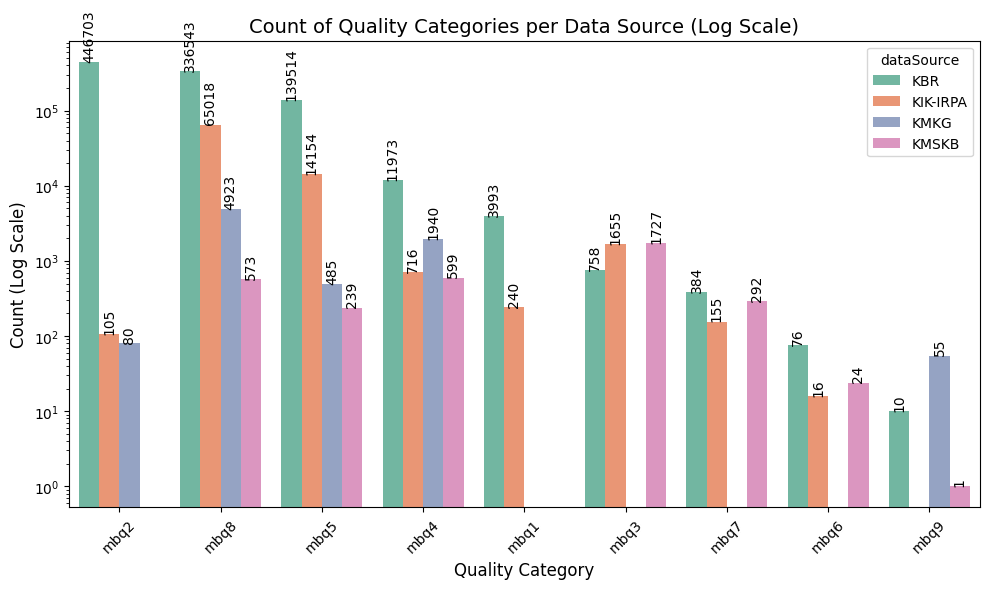

In [191]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


# Create the bar plot
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=allInfoDfCategories, x='qualityCategory', hue='dataSource', palette='Set2')

# Add the total count labels on top of each bar
for p in ax.patches:
    # Get the height (count) of each bar
    height = int(p.get_height())
    # Get the x position for placing the label (centered above the bar)
    x = p.get_x() + p.get_width() / 2
    # Add the label with the count
    ax.annotate(f'{height}', (x, height), ha='center', va='bottom', fontsize=10, rotation=90)

# Set logarithmic scale for the y-axis
ax.set_yscale('log')

# Customize the plot labels and title
ax.set_xlabel('Quality Category', fontsize=12)
ax.set_ylabel('Count (Log Scale)', fontsize=12)
ax.set_title('Count of Quality Categories per Data Source (Log Scale)', fontsize=14)

# Show the plot
plt.xticks(rotation=45)  # Rotate x-ticks if necessary
plt.tight_layout()

plt.savefig('quality-categories-logarithmic-totals.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.savefig('quality-categories-logarithmic-totals.png', format='png', dpi=300, bbox_inches='tight')
plt.show()


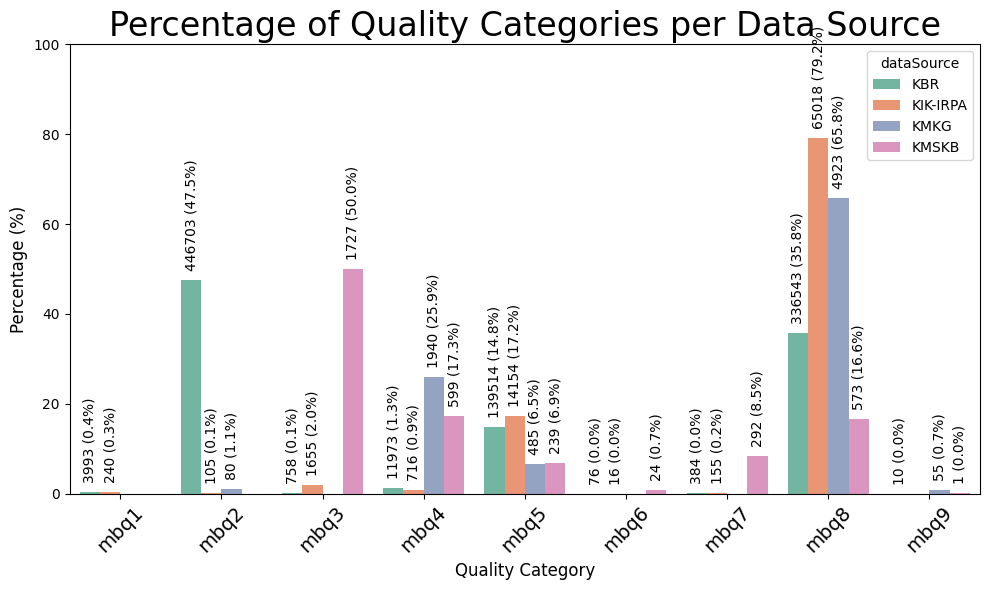

In [192]:
# Assuming 'allInfoDfCategories' is your DataFrame

# Calculate the count of each combination of 'qualityCategory' and 'dataSource'
category_counts = allInfoDfCategories.groupby(['qualityCategory', 'dataSource']).size().reset_index(name='count')

# Calculate the total count for each 'dataSource'
total_counts_per_source = allInfoDfCategories['dataSource'].value_counts().reset_index(name='total_count').rename(columns={'index': 'dataSource'})

# Merge the category counts with the total counts to calculate percentages
category_counts = category_counts.merge(total_counts_per_source, on='dataSource')

# Calculate the percentage of each qualityCategory per dataSource
category_counts['percentage'] = (category_counts['count'] / category_counts['total_count']) * 100

# Create the bar plot with percentages
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=category_counts, x='qualityCategory', y='percentage', hue='dataSource', palette='Set2')

# Add the labels on top of each bar
for p, (count, percentage) in zip(ax.patches, zip(category_counts['count'], category_counts['percentage'])):
    height = p.get_height()
    x = p.get_x() + p.get_width() / 2
    offset = max(2, height * 0.02)  # Ensures at least 2% distance but scales with height
    
    # Format as "2417 (17.3%)"
    label = f"{count} ({percentage:.1f}%)"
    
    # Add the annotation
    ax.annotate(label, (x, height + offset), ha='center', va='bottom', fontsize=10, rotation=90)

# Customize the plot labels and title
ax.set_xlabel('Quality Category', fontsize=12)
ax.set_ylabel('Percentage (%)', fontsize=12)
ax.set_title('Percentage of Quality Categories per Data Source', fontsize=24)

# Fix y-axis to 100%
ax.set_ylim(0, 100)

# Rotate x-ticks for better readability
plt.xticks(rotation=45, fontsize=14)

# Ensure layout doesn't cut off labels
plt.tight_layout()

plt.savefig('quality-categories-percentages.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.savefig('quality-categories-percentages.png', format='png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()



In [193]:
allInfoDfCategories[allInfoDfCategories['name'].isna()]['qualityCategory'].value_counts(dropna=False)

qualityCategory
mbq8    473
mbq9     66
mbq4     11
mbq2      2
Name: count, dtype: int64

In [194]:
allInfoDfCategories[allInfoDfCategories["qualityCategory"] == 'mbq9']

name alternateNames isni viaf geonameIDBirth geonameIDDeath  \
autID                                                                        
kbr|14143868    NaN            NaN  NaN  NaN            NaN            NaN   
kbr|14199906    NaN            NaN  NaN  NaN            NaN            NaN   
kbr|14263752    NaN            NaN  NaN  NaN            NaN            NaN   
kbr|14300572    NaN            NaN  NaN  NaN            NaN            NaN   
kbr|14390984    NaN            NaN  NaN  NaN            NaN            NaN   
...             ...            ...  ...  ...            ...            ...   
kmkg|9030       NaN            NaN  NaN  NaN            NaN            NaN   
kmkg|9060       NaN            NaN  NaN  NaN            NaN            NaN   
kmkg|9334       NaN            NaN  NaN  NaN            NaN            NaN   
kmkg|9340       NaN            NaN  NaN  NaN            NaN            NaN   
kmskb|509/3852  NaN            NaN  NaN  NaN            NaN            NaN   

               birthPlace deathPlace placenameBirth placenameDeath dataSource  \
autID                                                                           
kbr|14143868          NaN        NaN            NaN            NaN        KBR   
kbr|14199906          NaN        NaN            NaN            NaN        KBR   
kbr|14263752          NaN        NaN            NaN            NaN        KBR   
kbr|14300572          NaN        NaN            NaN            NaN        KBR   
kbr|14390984          NaN        NaN            NaN            NaN        KBR   
...                   ...        ...            ...            ...        ...   
kmkg|9030             NaN        NaN            NaN            NaN       KMKG   
kmkg|9060             NaN        NaN            NaN            NaN       KMKG   
kmkg|9334             NaN        NaN            NaN            NaN       KMKG   
kmkg|9340             NaN        NaN            NaN            NaN       KMKG   
kmskb|509/3852        NaN        NaN            NaN            NaN      KMSKB   

               birthDateEDTF deathDateEDTF countryCodeBirth countryCodeDeath  \
autID                                                                          
kbr|14143868             NaN           NaN              NaN              NaN   
kbr|14199906             NaN           NaN              NaN              NaN   
kbr|14263752            16XX           NaN              NaN              NaN   
kbr|14300572             NaN           NaN              NaN              NaN   
kbr|14390984             NaN           NaN              NaN              NaN   
...                      ...           ...              ...              ...   
kmkg|9030                NaN           NaN              NaN              NaN   
kmkg|9060                NaN           NaN              NaN              NaN   
kmkg|9334                NaN           NaN              NaN              NaN   
kmkg|9340                NaN           NaN              NaN              NaN   
kmskb|509/3852           NaN           NaN              NaN              NaN   

               qualityCategory  
autID                           
kbr|14143868              mbq9  
kbr|14199906              mbq9  
kbr|14263752              mbq9  
kbr|14300572              mbq9  
kbr|14390984              mbq9  
...                        ...  
kmkg|9030                 mbq9  
kmkg|9060                 mbq9  
kmkg|9334                 mbq9  
kmkg|9340                 mbq9  
kmskb|509/3852            mbq9  

[66 rows x 16 columns]

In [195]:
# debug adding of quality category one by one and inspect after each assignment 
# to see if one category all of a sudden swallows another
#
#allInfoDfCategories['qualityCategoryTest'] = np.nan
#allInfoDfCategories.loc[mbq1Mask, 'qualityCategoryTest'] = 'mbq1'
#allInfoDfCategories.loc[mbq2Mask, 'qualityCategoryTest'] = 'mbq2'
#allInfoDfCategories.loc[mbq3Mask, 'qualityCategoryTest'] = 'mbq3'
#allInfoDfCategories.loc[mbq4Mask, 'qualityCategoryTest'] = 'mbq4'
#allInfoDfCategories.loc[mbq5Mask, 'qualityCategoryTest'] = 'mbq5'
#allInfoDfCategories.loc[mbq6Mask, 'qualityCategoryTest'] = 'mbq6'
#allInfoDfCategories.loc[mbq7Mask, 'qualityCategoryTest'] = 'mbq7'

In [196]:
#allInfoDfCategories['qualityCategoryTest'].value_counts()

### spatio temporal stats

In [197]:
allInfoDfCategories['birthDateEDTF'].isna().value_counts()

birthDateEDTF
True     829652
False    203299
Name: count, dtype: int64

In [198]:
allInfoDfCategories.columns

Index(['name', 'alternateNames', 'isni', 'viaf', 'geonameIDBirth',
       'geonameIDDeath', 'birthPlace', 'deathPlace', 'placenameBirth',
       'placenameDeath', 'dataSource', 'birthDateEDTF', 'deathDateEDTF',
       'countryCodeBirth', 'countryCodeDeath', 'qualityCategory'],
      dtype='object')

In [199]:
allInfoDfCategories['certainBirthDate'] = allInfoDfCategories['birthDateEDTF'].apply(notebook_utils.isCertainEDTFDate)

In [200]:
allInfoDfCategories[(allInfoDfCategories['countryCodeBirth'] == 'BE') & ((allInfoDfCategories['certainBirthDate'] == True) & (allInfoDfCategories['birthDateEDTF'] < '1830')) ]

name  \
autID                                                 
kbr|10039097                    [Simon, Jean-Henri]   
kbr|10039434   [Philippe le Beau, Filips de Schone]   
kbr|10039589                 [Hart, Laurent Joseph]   
kbr|10039630                [Braemt, Joseph-Pierre]   
kbr|10164935                [Sigart, Joseph-Désiré]   
...                                             ...   
kmskb|509/857                  [VRANCX, Sebastiaen]   
kmskb|509/866                        [WILDENS, Jan]   
kmskb|509/870                    [VAN WINGHE, Joos]   
kmskb|509/93                     [SIMONIS, EugÃ¨ne]   
kmskb|509/99          [VAN ASSCHE, Auguste Lambert]   

                                                                                                alternateNames  \
autID                                                                                                            
kbr|10039097                                                                                               NaN   
kbr|10039434   [Filips I, Koning van Castilië, Philippe le Beau, Philip the fair, Philippe I, roi de Castille]   
kbr|10039589                                                                                               NaN   
kbr|10039630                                                                                               NaN   
kbr|10164935                                                                                               NaN   
...                                                                                                        ...   
kmskb|509/857                                                                                              NaN   
kmskb|509/866                                                                                              NaN   
kmskb|509/870                                                                                              NaN   
kmskb|509/93                                                                                               NaN   
kmskb|509/99                                                                                               NaN   

                                isni viaf geonameIDBirth geonameIDDeath  \
autID                                                                     
kbr|10039097   [0000 0003 9022 4026]  NaN        2800866        2800866   
kbr|10039434   [0000 0001 0823 5048]  NaN        2800931        3127461   
kbr|10039589                     NaN  NaN        2803138        2800866   
kbr|10039630   [0000 0003 9284 1888]  NaN        2797656        2800866   
kbr|10164935                     NaN  NaN        2790869        2795011   
...                              ...  ...            ...            ...   
kmskb|509/857                    NaN  NaN        2803138        2803138   
kmskb|509/866                    NaN  NaN        2803138        2803138   
kmskb|509/870                    NaN  NaN        2800866        2925533   
kmskb|509/93                     NaN  NaN        2792413            NaN   
kmskb|509/99                     NaN  NaN        2800866        2800866   

                                    birthPlace  \
autID                                            
kbr|10039097                       [Bruxelles]   
kbr|10039434               [Bruges (Belgique)]   
kbr|10039589   [Antwerpen (België), Antwerpen]   
kbr|10039630                            [Gand]   
kbr|10164935                            [Mons]   
...                                        ...   
kmskb|509/857                [Antwerpen [dut]]   
kmskb|509/866                [Antwerpen [dut]]   
kmskb|509/870                  [Brussel [dut]]   
kmskb|509/93                      [Luik [dut]]   
kmskb|509/99                   [Brussel [dut]]   

                                                  deathPlace placenameBirth  \
autID                                                                         
kbr|10039097                                     [Bruxelles]   

<Figure size 1400x800 with 0 Axes>

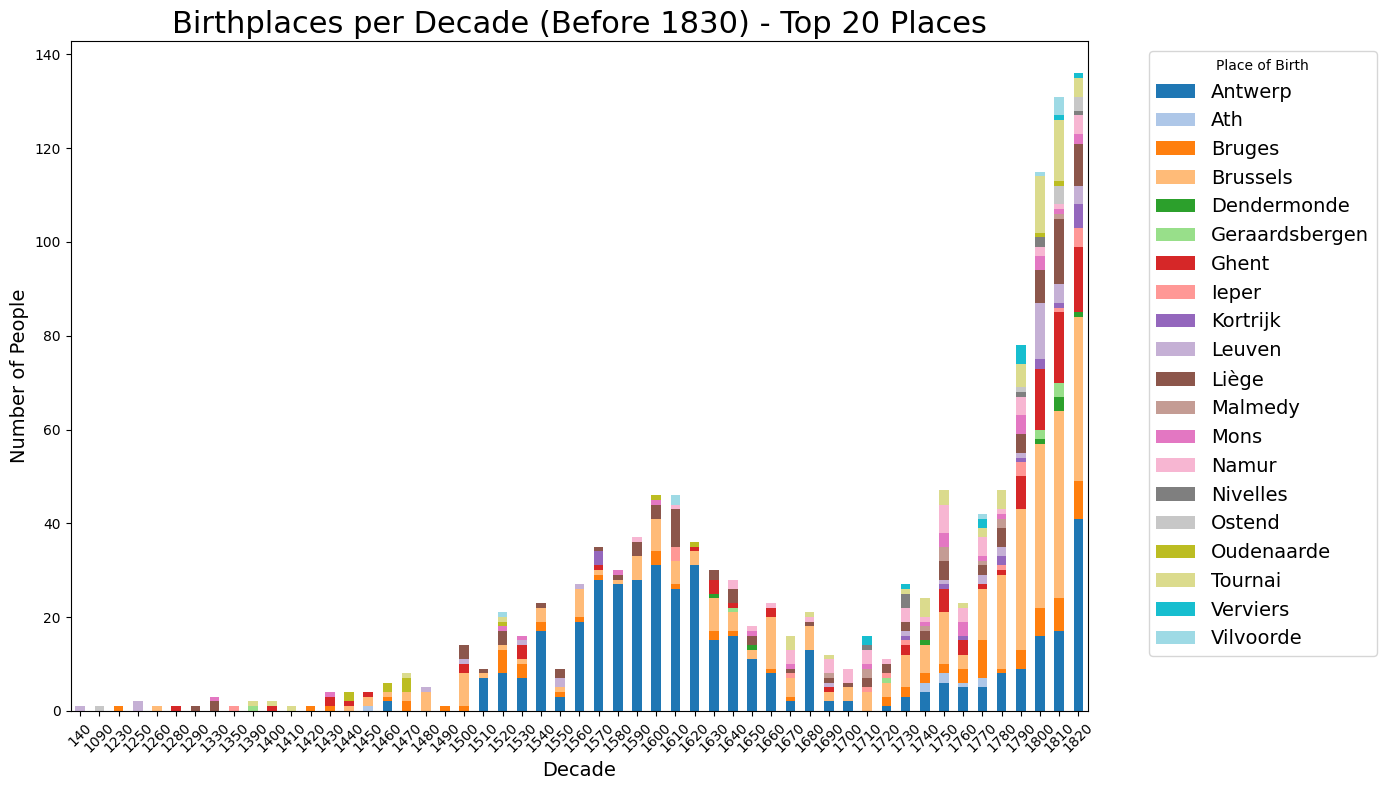

In [201]:
# Set the number of top places to include
TOP_X = 20  # Change this to the desired number

# Filter dataset for people born in Belgium before 1830
filtered_df = allInfoDfCategories[
    (allInfoDfCategories['countryCodeBirth'] == 'BE') &
    (allInfoDfCategories['certainBirthDate'] == True) &
    (allInfoDfCategories['birthDateEDTF'] < '1830')
].copy()

# Extract birth year safely
filtered_df['birthYear'] = pd.to_numeric(filtered_df['birthDateEDTF'].str[:4], errors='coerce')

# Remove NaN values and convert to integer
filtered_df = filtered_df.dropna(subset=['birthYear'])
filtered_df['birthYear'] = filtered_df['birthYear'].astype(int)

# Calculate decade
filtered_df['decade'] = (filtered_df['birthYear'] // 10) * 10

# Get top X places with most occurrences
top_places = filtered_df['placenameBirth'].value_counts().nlargest(TOP_X).index

# Filter dataset to include only top X places
filtered_df = filtered_df[filtered_df['placenameBirth'].isin(top_places)]

# Count occurrences per decade and place name
decade_counts = filtered_df.groupby(['decade', 'placenameBirth']).size().reset_index(name='count')

# Pivot to wide format for stacked bar chart
pivot_df = decade_counts.pivot(index='decade', columns='placenameBirth', values='count').fillna(0)

# Plot stacked bar chart
plt.figure(figsize=(14, 8))
pivot_df.plot(kind='bar', stacked=True, colormap='tab20', figsize=(14, 8))

plt.title(f'Birthplaces per Decade (Before 1830) - Top {TOP_X} Places', fontsize=22)
plt.xlabel('Decade', fontsize=14)
plt.ylabel('Number of People', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Place of Birth', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=14)
plt.tight_layout()

plt.savefig(f'birthplace-per-decade-before-1830-top-{TOP_X}.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.savefig(f'birthplace-per-decade-before-1830-top-{TOP_X}.png', format='png', dpi=300, bbox_inches='tight')
plt.show()


In [202]:
allInfoDfCategories

name  \
autID                                                                                                                                   
kbr|10038105                                                                                                         [Steppé, Julien]   
kbr|10038106                                                                                                             [Falise, E.]   
kbr|10038107                                                                                                            [Stienon, J.]   
kbr|10038108                                                                                                         [Fauconnier, E.]   
kbr|10038109                                                                                                          [Sturbelle, G.]   
...                                                                                                                               ...   
kmskb|509/995            [ECOLE DES PAYS-BAS MERIDIONAUX, GAND // ZUID-NEDERLANDSE SCHOOL, GENT // SOUTH NETHERLANDISH SCHOOL, GHENT]   
kmskb|509/996  [ECOLE DES PAYS-BAS MERIDIONAUX / LIEGE ? // ZUID-NEDERLANDSE SCHOOL / LUIK ? // SOUTH NETHERLANDISH SCHOOL / LIEGE ?]   
kmskb|509/997                                 [ECOLE DES PAYS-BAS MERIDIONAUX / ZUID-NEDERLANDSE SCHOOL / SOUTH NETHERLANDISH SCHOOL]   
kmskb|509/998                                 [ECOLE DES PAYS-BAS MERIDIONAUX / ZUID-NEDERLANDSE SCHOOL / SOUTH NETHERLANDISH SCHOOL]   
kmskb|509/999                              [ZUID-NEDERLANDSE SCHOOL / ECOLE DES PAYS-BAS MERIDIONAUX / SOUTHERN NETHERLANDISH SCHOOL]   

              alternateNames  isni viaf geonameIDBirth geonameIDDeath  \
autID                                                                   
kbr|10038105             NaN  [--]  NaN            NaN            NaN   
kbr|10038106             NaN   NaN  NaN            NaN            NaN   
kbr|10038107             NaN   NaN  NaN            NaN            NaN   
kbr|10038108             NaN   NaN  NaN            NaN            NaN   
kbr|10038109             NaN   NaN  NaN            NaN            NaN   
...                      ...   ...  ...            ...            ...   
kmskb|509/995            NaN   NaN  NaN            NaN            NaN   
kmskb|509/996            NaN   NaN  NaN            NaN            NaN   
kmskb|509/997            NaN   NaN  NaN            NaN            NaN   
kmskb|509/998            NaN   NaN  NaN            NaN            NaN   
kmskb|509/999            NaN   NaN  NaN            NaN            NaN   

              birthPlace deathPlace placenameBirth placenameDeath dataSource  \
autID                                                                          
kbr|10038105         NaN        NaN            NaN            NaN        KBR   
kbr|10038106         NaN        NaN            NaN            NaN        KBR   
kbr|10038107         NaN        NaN            NaN            NaN        KBR   
kbr|10038108         NaN        NaN            NaN            NaN        KBR   
kbr|10038109         NaN        NaN            NaN            NaN        KBR   
...                  ...        ...            ...            ...        ...   
kmskb|509/995        NaN        NaN            NaN            NaN      KMSKB   
kmskb|509/996        NaN        NaN            NaN            NaN      KMSKB   
kmskb|509/997        NaN        NaN            NaN            NaN      KMSKB   
kmskb|509/998        NaN        NaN            NaN            NaN      KMSKB   
kmskb|509/999        NaN        NaN            NaN            NaN      KMSKB   

              birthDateEDTF deathDateEDTF countryCodeBirth countryCodeDeath  \
autID                                                                         
kbr|10038105            NaN           NaN              NaN              NaN   
kbr|10038106            NaN           NaN              NaN              NaN   
kbr|10038107            NaN           Na